# House Prices Prediction

In [ ]:
!pip install category-encoders

In [2]:
 !pip install -q kaggle

# Copy Kaggle.json to Colab "/content" directory and run Cells

In [3]:
!mkdir /root/.kaggle

In [4]:
!cp /content/kaggle.json /root/.kaggle

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

# Imports and Consts

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import CatBoostEncoder, OrdinalEncoder
from scipy.stats import norm
from sklearn.metrics import mean_squared_log_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.nn.utils import prune

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# Final number of features, after adding some new ones, excluding the target variable
NUM_FEATURES = 80

# Data exploration
Loading the Data from the test and train csv's

In [7]:
# Load train test dataframes
train = pd.read_csv('./train.csv')

# Sort by time and drop target and id columns
train_X = train.sort_values(['YrSold', 'MoSold'], axis=0).reset_index(drop=True)
train_y = train_X['SalePrice']
train_X = train_X.drop(['SalePrice', 'Id'], axis=1)
test_X = pd.read_csv('./test.csv', index_col='Id')
test_X = test_X.sort_values(['YrSold', 'MoSold'], axis=0)

In [8]:
train_X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RL,78.0,11645,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,1300,Unf,0,434,1734,GasA,Ex,Y,SBrkr,1734,0,0,1734,1,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2005.0,Fin,2,660,TA,TA,Y,160,24,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal
1,20,RL,NaN,16669,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,8,6,1981,1981,Hip,WdShake,Plywood,Plywood,BrkFace,653.0,Gd,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1686,1686,GasA,TA,Y,SBrkr,1707,0,0,1707,0,0,2,1,2,1,TA,6,Typ,1,TA,Attchd,1981.0,RFn,2,511,TA,TA,Y,574,64,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal
2,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,150.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1541,1541,GasA,Ex,Y,SBrkr,1541,0,0,1541,0,0,2,0,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,3,843,TA,TA,Y,468,81,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal
3,60,RL,NaN,8121,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,711,0,1664,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,2000.0,RFn,2,460,TA,TA,Y,100,40,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal
4,190,RL,100.0,34650,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,Gilbert,Norm,Norm,2fmCon,1Story,5,5,1955,1955,Hip,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,Mn,Rec,1056,Unf,0,0,1056,GasA,TA,N,SBrkr,1056,0,0,1056,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1955.0,Fin,2,572,TA,TA,Y,264,0,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal


In [9]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

As we see many columns has Na values. We replace all NA in categorical columns with None or similar value and numerical features with 0

In [10]:
class CustomImputer:
    def __init__(self):
        pass
    
    def fit(self, data):
        cat_cols = data.columns[data.dtypes == 'object']
        self.impute_cols = cat_cols[data[cat_cols].isna().sum() > 0] 
    
    def transform(self, data):
        for column in self.impute_cols:
            if data[column].isin(['None', 'No', 'Othr']).sum() > 0:
                replace_value = data.loc[data[column].isin(['None', 'No', 'Othr']), column].unique()[0]
                data[column] = data[column].fillna(replace_value)
            else:
                data[column] = data[column].fillna('None')
        
        return data
                
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    def get_params(self):
        pass

In [11]:
na_cols = train_X.columns[(train_X.isna().sum() > 0).values]
print(f'Columns with NA: {na_cols}')

# Replace NA values in categorical features with None and similar values        
train_X.loc[:, na_cols] = CustomImputer().fit_transform(train_X.loc[:, na_cols])
test_X.loc[:, na_cols] = CustomImputer().fit_transform(test_X.loc[:, na_cols])

# Replace NA values in continuos features with 0 value
train_X.loc[:, na_cols[train_X.loc[:, na_cols].dtypes == 'float64']] = train_X.loc[:, na_cols[train_X.loc[:, na_cols].dtypes == 'float64']].fillna(0)

Columns with NA: Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [12]:
train_X.columns[train_X.isna().sum() > 0]

Index([], dtype='object')

# Feature Generation

Feature engineering is a very important step to improve our model

In [13]:
def get_sold_last_mnth(df):
    """ Generates sold houses lats month feature """
    timeline = pd.to_datetime(df['YrSold'].astype('str') + '-' + df['MoSold'].astype('str'), format='%Y-%m')
    tm_ln_indexed = pd.Series(data=timeline.index ,index=timeline.values)
    tm_ln_sold_last_mnth = tm_ln_indexed.rolling('62d').count() - tm_ln_indexed.rolling('31d').count()
    sold_lst_mnth = pd.Series(data=tm_ln_sold_last_mnth.values, index=tm_ln_indexed.values).reindex(df.index)
    return sold_lst_mnth

def get_fireplaces_per_room(df):
    """ Generates number of fireplaces per room feature """
    fp_per_house = df['Fireplaces'] / df['TotRmsAbvGrd']
    return fp_per_house

def get_quality_per_room(df):
    """ Generates quality per room feature """
    qual_per_room = df['OverallQual'] / df['TotRmsAbvGrd']
    return qual_per_room

In [14]:
# Add sold houses last month feature
train_X = train_X.assign(Sold_Lst_Mnth=lambda df: get_sold_last_mnth(df))
test_X = test_X.assign(Sold_Lst_Mnth=lambda df: get_sold_last_mnth(df))

# Add number of fireplaces per room feature
train_X = train_X.assign(FireplacesPerRm=lambda df: get_fireplaces_per_room(df))
test_X = test_X.assign(FireplacesPerRm=lambda df: get_fireplaces_per_room(df))

# Add quality per room feature
train_X = train_X.assign(QualPerRm=lambda df: get_quality_per_room(df))
test_X = test_X.assign(QualPerRm=lambda df: get_quality_per_room(df))

# Target leakage

As we look at the data and check whether is there target leakage, It seems that **YrSold(Year when house is sold)** and **MoSold(Month when house is sold)** will cause target leakage, as we will not have such values when predicting real world house prices.

In [15]:
ta_leakage_cols = ['YrSold', 'MoSold']
train_X = train_X.drop(ta_leakage_cols, axis=1)
test_X = test_X.drop(ta_leakage_cols, axis=1)

In [16]:
# Define catgerical and numerical features
cat_features = train_X.columns[train_X.dtypes == 'object']
num_features = train_X.columns[(train_X.dtypes == 'int64') | (train_X.dtypes == 'float64')]

# Data Visualization

Plotting wrapper class for statistics and visualization

In [17]:
class Plot(object):
    def __init__(self, nrows=20, ncols=4, figsize=(35,200), fontsize=30):
        self.nrows = nrows
        self.ncols = ncols
        self.figsize = figsize
        self.fontsize=fontsize


    def plot_grid(self, data, target_key, from_key, to_key):
        """
        Given a dataset, plots data feature distributions, corresponding to the 
        target starting from the specified key to the deserved one
        """
        
        assert to_key > from_key and to_key <= len(data.keys()), 'Invalid arguments!'

        plt.figure()
        fig, axes = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize)
        keys = data.keys()[from_key:to_key+1]

        for x in range(axes.shape[0]):
            for y in range(axes.shape[1]):
                if x*self.ncols+y < len(keys) and x*self.ncols+y <= to_key:
                    axes[x][y].set_ylabel(target_key, fontsize=self.fontsize)
                    axes[x][y].set_xlabel(keys[x*self.ncols+y], fontsize=self.fontsize)
                    notnan_filter = data[keys[x*self.ncols+y]].notna()

                    if not isinstance(data[keys[x*self.ncols+y]][0], str): # Numerical feature
                        axes[x][y].scatter(x=data.loc[notnan_filter, keys[x*self.ncols+y]], y=data.loc[notnan_filter, target_key])
                    else: # Categorical feature --> numerical conversion for plotting purposes
                        axes[x][y].scatter(x=data.loc[notnan_filter, keys[x*self.ncols+y]].astype('category').cat.codes, y=data.loc[notnan_filter, target_key])
                    plt.grid(True)

        plt.show()


    def plot_norm_dists(self, data, from_key, to_key):
        """
        Given a dataset, plots the data feature normal distributions
        """

        assert to_key > from_key and to_key <= len(data.keys()), 'Invalid arguments!'

        plt.figure()
        fig, axes = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize)
        keys = data.keys()[from_key:to_key+1]

        for x in range(axes.shape[0]):
            for y in range(axes.shape[1]):
                if x*self.ncols+y < len(keys) and x*self.ncols+y <= to_key:
                    current = data[keys[x*self.ncols+y]]
                    notnan_filter = current.notna()
                    notnan = data.loc[notnan_filter, keys[x*self.ncols+y]]

                    notnanzero = None
                    if not isinstance(notnan.tolist()[0], str): # Numerical feature
                        notnanzero_filter = current.where(current > 0).notna()
                        notnanzero = data.loc[notnanzero_filter, keys[x*self.ncols+y]]
                    else: # Categorical feature --> numerical conversion for plotting purposes
                        notnanzero = notnan.astype('category').cat.codes + 1 # Starting from class no' 1

                    # Plot the distribution
                    sns.distplot(notnanzero, fit=norm, ax=axes[x][y])

                    # Get the fitted parameters used by the function
                    (mu, sigma) = norm.fit(notnanzero)

                    # Some plot features
                    axes[x][y].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                                loc='best')
                    axes[x][y].set_ylabel('Frequency', fontsize=self.fontsize)
                    axes[x][y].set_xlabel(f'{keys[x*self.ncols+y]} distribution', fontsize=self.fontsize)
                    plt.grid(True)
                    
        plt.show()


    def plot_qq(self, data, from_key, to_key):
        """
        Given a dataset, plots the data feature QQ graphs
        """

        assert to_key > from_key and to_key <= len(data.keys()), 'Invalid arguments!'

        plt.figure()
        fig, axes = plt.subplots(nrows=self.nrows, ncols=self.ncols, figsize=self.figsize)
        keys = data.keys()[from_key:to_key+1]

        for x in range(axes.shape[0]):
            for y in range(axes.shape[1]):
                if x*self.ncols+y < len(keys) and x*self.ncols+y <= to_key:
                    current = data[keys[x*self.ncols+y]]
                    notnan_filter = current.notna()
                    notnan = data.loc[notnan_filter, keys[x*self.ncols+y]]

                    notnanzero = None
                    if not isinstance(notnan.tolist()[0], str): # Numerical feature
                        notnanzero_filter = current.where(current > 0).notna()
                        notnanzero = data.loc[notnanzero_filter, keys[x*self.ncols+y]]
                    else: # Categorical feature --> numerical conversion for plotting purposes
                        notnanzero = notnan.astype('category').cat.codes + 1 # Starting from class no' 1
 
                    # Plot the QQ graph
                    # plt.rcParams['axes.titlesize'] = self.fontsize
                    stats.probplot(notnanzero, plot=axes[x][y])
                    axes[x][y].xaxis.get_label().set_fontsize(self.fontsize)
                    axes[x][y].yaxis.get_label().set_fontsize(self.fontsize)
                    # axes[x][y].set_title(keys[x*self.ncols+y])
                    plt.grid(True)
        
        plt.show()

In [18]:
plot_wrapper = Plot()

Graphs Showing how the Sales Price is distributed by the given features

In [19]:
plot_wrapper.plot_grid(train_val, 'SalePrice', 0, NUM_FEATURES-1)

NameError: ignored

Plot the feature and the target distributions

In [20]:
plot_wrapper.plot_norm_dists(train_val, 0, NUM_FEATURES+1) # +1 --> including the target SalePrice

NameError: ignored

# Correlation Map for the target Value: SalePrice
As we can see, there are a number of features that correlate directly to the sales price such as over all quality, GrLivArea, GarageCars and more.
We can notice that other features correlate together, such as GarageYrBuilt, GarageArea, GarageCars.
Note: notice how every feature correlates 1 with itself..

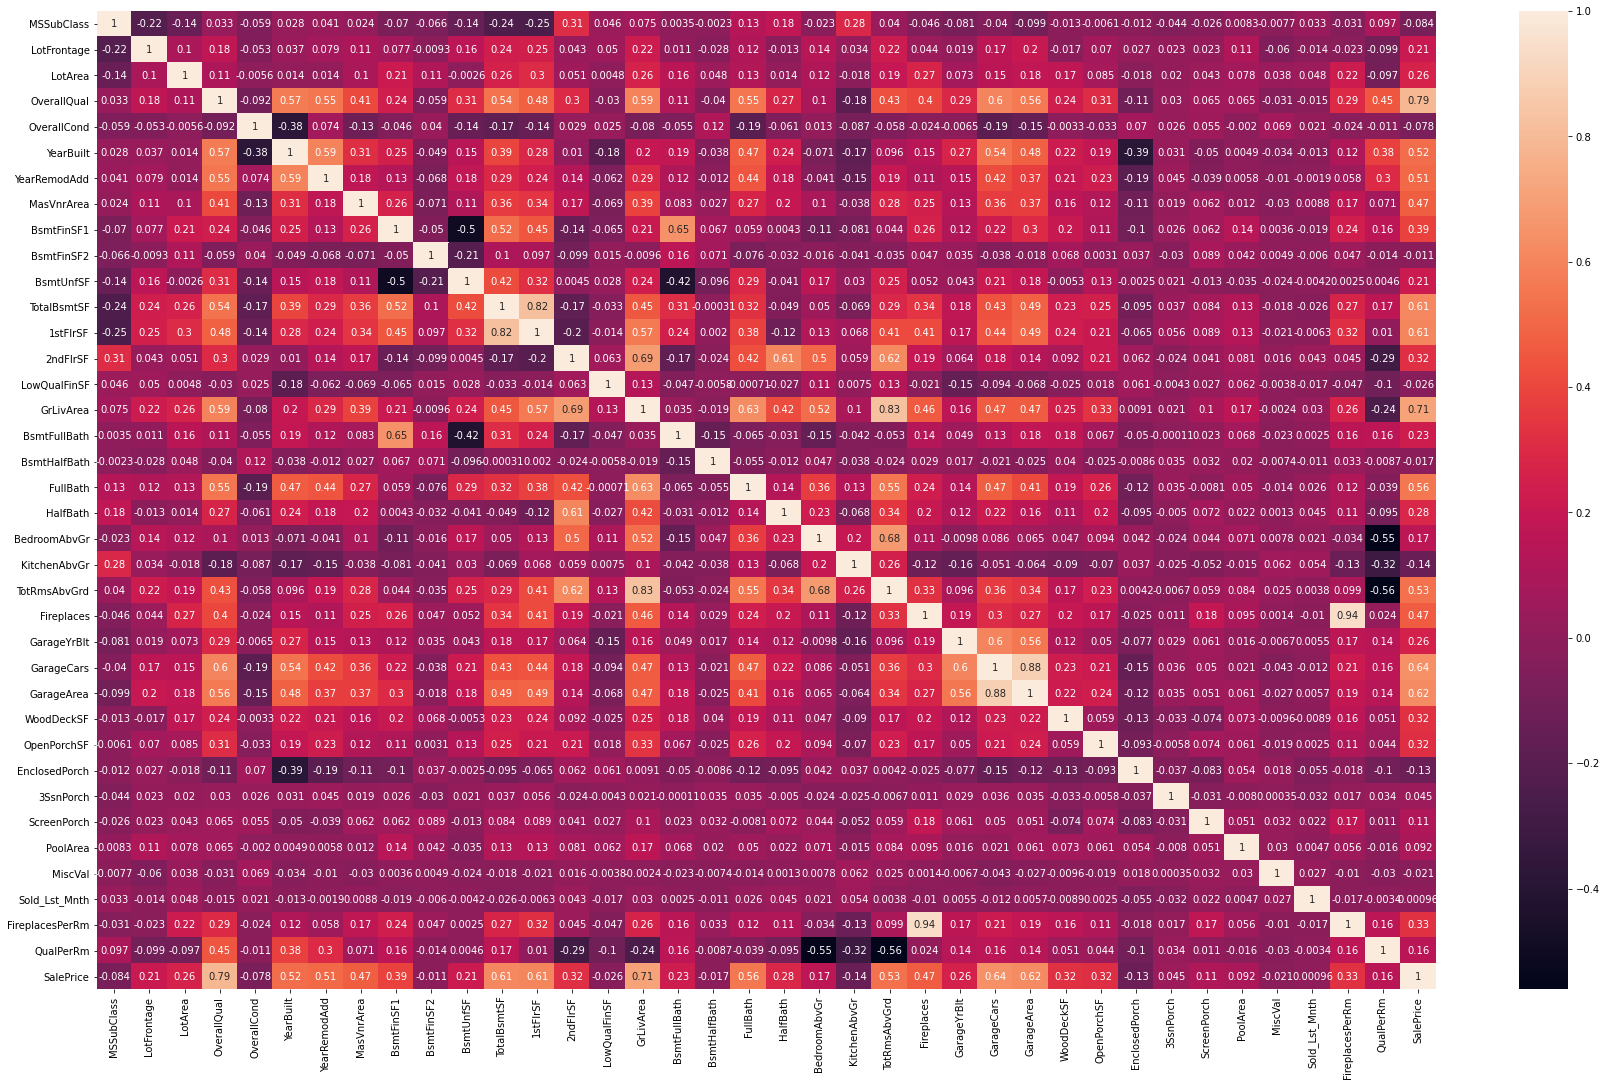

In [21]:
plt.figure(figsize=(30, 18))
sns.heatmap(pd.concat([train_X[num_features], train_y], axis=1).corr(), annot=True)

# Data Transformation

For ordinal data we will use OrdinalEncoder(as it much more apropriated for Tree-Based models) and CatBoostEncoder for nominal, and for numerical Standard Scaler

In [22]:
# Lets divide or categorical features on ordinal and nominal
ordinal_features = [
    'LandSlope',
    'Condition1',
    'Condition2',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageQual',
    'GarageCond',
    'PoolQC'
]

nominal_features = cat_features.drop(ordinal_features)
# Next define transformer of nominal features
nominal_transformer = pipeline.Pipeline(steps=[
    ('cat_boost', CatBoostEncoder()),
    ('scaler', StandardScaler())
])

# Nest feature transformations of numerical ans ordinal cols
num_transformer = pipeline.Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, missing_values=np.nan)),
    ('scaler', StandardScaler())
])

num_ord_transformer = ColumnTransformer(transformers=[
    ('ordinal_transformer', OrdinalEncoder(), ordinal_features),
    ('num_transformer', num_transformer, num_features)
])

# First transform our nominal features
train_X_nominal = nominal_transformer.fit_transform(train_X[nominal_features], train_y)
test_X_nominal = nominal_transformer.transform(test_X[nominal_features])

# Next transform ordinal and numerical features
train_X_num_ord = num_ord_transformer.fit_transform(train_X)
test_X_num_ord = num_ord_transformer.transform(test_X)

# Finally we concatenate such arrays
train_X_transformed = np.concatenate((train_X_nominal, train_X_num_ord), axis=1)
test_X_transformed = np.concatenate((test_X_nominal, test_X_num_ord), axis=1)

# Regression Neural Network

In [23]:
class DeepRegress(torch.nn.Module):
  def __init__(self, in_features_=NUM_FEATURES):
    super(DeepRegress, self).__init__()

    self.bn1 = nn.BatchNorm1d(in_features_)
    self.fc1 = nn.Linear(in_features=in_features_, out_features=512)

    self.bn2 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(in_features=512, out_features=128)

    self.bn3 = nn.BatchNorm1d(128)
    self.fc3 = nn.Linear(in_features=128, out_features=32)

    self.bn4 = nn.BatchNorm1d(32)
    self.fc4 = nn.Linear(in_features=32, out_features=1) # 1 regression output


  def forward(self, x):
    x = self.bn1(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = F.dropout(x)
    
    x = self.bn2(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = F.dropout(x)

    x = self.bn3(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = F.dropout(x)

    x = self.bn4(x)
    return self.fc4(x)

In [24]:
deep_regressor = DeepRegress().to('cuda:0')

# House_Pricing Dataset Definition

In [25]:
class House_Pricing(Dataset):
    def __init__(self, x, y, is_train):
        super(House_Pricing, self).__init__()
        self.is_train = is_train
        self.x = x[:len(x)*9//10] if self.is_train else x[len(x)*9//10:]
        y = np.log1p(y)
        self.y = y[:len(y)*9//10] if self.is_train else y[len(y)*9//10:]

    def __getitem__(self, idx):
        x = torch.as_tensor(self.x[idx]).float()
        y = torch.as_tensor(self.y[idx]).float()
        return x, y

    def __len__(self):
        return len(self.y)

In [26]:
# Training dataloader
house_pricing_train_ds = House_Pricing(train_X_transformed, train_y.to_numpy(), is_train=True)
house_pricing_train_dl = DataLoader(house_pricing_train_ds, 128, shuffle=True, num_workers=8)

# Evaluation dataloader
house_pricing_val_ds = House_Pricing(train_X_transformed, train_y.to_numpy(), is_train=False)
house_pricing_val_dl = DataLoader(house_pricing_train_ds, 8, shuffle=True, num_workers=8)

# Evaluation function for the NN regressor

In [27]:
def eval_nn(model, dataloader, criterion=nn.MSELoss()):
    model.eval()
    losses = list()

    for x, y in dataloader:
        x, y = x.to('cuda:0'), y.to('cuda:0')
        pred = model(x)
        losses.append(criterion(pred, y).cpu().detach().item())

    return np.mean(np.asarray(losses))

# Training function for the NN regressor

In [28]:
def train_nn(model, trainloader, valloader, optim, sched=None, epochs=50, criterion=nn.MSELoss()):
    losses_train, losses_val = list(), list()

    for e in range(epochs):
        i = 0
        model.train()
        for x, y in tqdm(trainloader):
            x, y = x.to('cuda:0'), y.to('cuda:0')
            pred = model(x)
            loss_train = criterion(pred, y)
            
            optim.zero_grad()
            loss_train.backward(loss_train)
            optim.step()

        if i % 5 == 0:
            losses_train.append(loss_train.detach().item())
            print(f'epoch number {e}, Training Loss = {loss_train}')
            loss_val = eval_nn(model, valloader)
            losses_val.append(loss_val)
            print(f'epoch number {e}, Validation Loss = {loss_val}')
        if sched is not None:
            sched.step()

    return losses_train, losses_val

# Optimizer / Scheduler

In [29]:
adamw = torch.optim.AdamW(deep_regressor.parameters(), lr=0.0001)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(adamw, T_max=1800)

# Training / Evaluating process

In [30]:
losses_train, losses_val = train_nn(deep_regressor, house_pricing_train_dl, house_pricing_val_dl, optim=adamw, sched=sched, epochs=1800)

100%|██████████| 11/11 [00:00<00:00, 19.10it/s]

epoch number 0, Training Loss = 138.81141662597656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 0, Validation Loss = 140.8837822191643


100%|██████████| 11/11 [00:00<00:00, 26.24it/s]

epoch number 1, Training Loss = 144.0046844482422



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1, Validation Loss = 140.59237356474904


100%|██████████| 11/11 [00:00<00:00, 26.00it/s]

epoch number 2, Training Loss = 142.36817932128906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 2, Validation Loss = 141.33867427941524


100%|██████████| 11/11 [00:00<00:00, 26.45it/s]

epoch number 3, Training Loss = 141.7191619873047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 3, Validation Loss = 141.8734736587062


100%|██████████| 11/11 [00:00<00:00, 26.44it/s]

epoch number 4, Training Loss = 142.71104431152344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 4, Validation Loss = 141.38760093920158


100%|██████████| 11/11 [00:00<00:00, 26.47it/s]

epoch number 5, Training Loss = 138.09713745117188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 5, Validation Loss = 141.07913161769056


100%|██████████| 11/11 [00:00<00:00, 26.26it/s]

epoch number 6, Training Loss = 142.49169921875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 6, Validation Loss = 140.90783247514204


100%|██████████| 11/11 [00:00<00:00, 26.54it/s]

epoch number 7, Training Loss = 140.87979125976562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 7, Validation Loss = 141.0772726347952


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 8, Training Loss = 139.22824096679688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 8, Validation Loss = 141.35863753810074


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 9, Training Loss = 142.7435302734375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 9, Validation Loss = 141.3824947010387


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 10, Training Loss = 143.7416229248047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 10, Validation Loss = 141.26293926817


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 11, Training Loss = 137.94064331054688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 11, Validation Loss = 140.4187917535955


100%|██████████| 11/11 [00:00<00:00, 26.61it/s]

epoch number 12, Training Loss = 139.18304443359375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 12, Validation Loss = 140.21414170698685


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 13, Training Loss = 138.4412078857422



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 13, Validation Loss = 140.2135722767223


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 14, Training Loss = 140.2190399169922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 14, Validation Loss = 140.38306427001953


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 15, Training Loss = 141.4928741455078



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 15, Validation Loss = 141.3193203088009


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 16, Training Loss = 139.9156494140625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 16, Validation Loss = 140.20078781590317


100%|██████████| 11/11 [00:00<00:00, 26.36it/s]

epoch number 17, Training Loss = 139.4967498779297



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 17, Validation Loss = 141.42372418027935


100%|██████████| 11/11 [00:00<00:00, 26.63it/s]

epoch number 18, Training Loss = 139.6879425048828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 18, Validation Loss = 140.31543384898794


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 19, Training Loss = 138.85137939453125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 19, Validation Loss = 140.2657182635683


100%|██████████| 11/11 [00:00<00:00, 26.25it/s]

epoch number 20, Training Loss = 137.8760528564453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 20, Validation Loss = 139.35697261925898


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 21, Training Loss = 136.8389129638672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 21, Validation Loss = 139.62347620183772


100%|██████████| 11/11 [00:00<00:00, 26.04it/s]

epoch number 22, Training Loss = 137.9099578857422



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 22, Validation Loss = 138.78510256680576


100%|██████████| 11/11 [00:00<00:00, 25.99it/s]

epoch number 23, Training Loss = 139.285888671875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 23, Validation Loss = 138.7034292047674


100%|██████████| 11/11 [00:00<00:00, 26.49it/s]

epoch number 24, Training Loss = 140.753662109375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 24, Validation Loss = 139.7340121644916


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 25, Training Loss = 139.45669555664062



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 25, Validation Loss = 138.16801831794507


100%|██████████| 11/11 [00:00<00:00, 26.44it/s]

epoch number 26, Training Loss = 135.2342529296875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 26, Validation Loss = 139.24562891179866


100%|██████████| 11/11 [00:00<00:00, 26.36it/s]

epoch number 27, Training Loss = 136.26303100585938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 27, Validation Loss = 137.85243271336412


100%|██████████| 11/11 [00:00<00:00, 24.40it/s]

epoch number 28, Training Loss = 137.86048889160156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 28, Validation Loss = 138.17275140935723


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 29, Training Loss = 137.80555725097656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 29, Validation Loss = 138.03391700513436


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 30, Training Loss = 137.9714813232422



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 30, Validation Loss = 137.9122990463719


100%|██████████| 11/11 [00:00<00:00, 26.20it/s]

epoch number 31, Training Loss = 137.81939697265625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 31, Validation Loss = 137.32907779578008


100%|██████████| 11/11 [00:00<00:00, 26.03it/s]

epoch number 32, Training Loss = 139.70208740234375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 32, Validation Loss = 137.96002525560783


100%|██████████| 11/11 [00:00<00:00, 26.23it/s]

epoch number 33, Training Loss = 140.27578735351562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 33, Validation Loss = 138.08018586129853


100%|██████████| 11/11 [00:00<00:00, 26.41it/s]

epoch number 34, Training Loss = 138.6234588623047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 34, Validation Loss = 138.05137273615057


100%|██████████| 11/11 [00:00<00:00, 26.49it/s]

epoch number 35, Training Loss = 137.1338653564453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 35, Validation Loss = 137.65821653423887


100%|██████████| 11/11 [00:00<00:00, 26.32it/s]

epoch number 36, Training Loss = 136.82986450195312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 36, Validation Loss = 136.11676649613813


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 37, Training Loss = 135.48837280273438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 37, Validation Loss = 136.63652912486683


100%|██████████| 11/11 [00:00<00:00, 26.14it/s]

epoch number 38, Training Loss = 137.53086853027344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 38, Validation Loss = 136.7157405506481


100%|██████████| 11/11 [00:00<00:00, 26.29it/s]

epoch number 39, Training Loss = 133.77334594726562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 39, Validation Loss = 136.98857121323095


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 40, Training Loss = 137.5985565185547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 40, Validation Loss = 135.62489032167377


100%|██████████| 11/11 [00:00<00:00, 26.41it/s]

epoch number 41, Training Loss = 133.83726501464844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 41, Validation Loss = 135.79902667421283


100%|██████████| 11/11 [00:00<00:00, 26.42it/s]

epoch number 42, Training Loss = 135.24594116210938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 42, Validation Loss = 135.13753504897608


100%|██████████| 11/11 [00:00<00:00, 26.59it/s]

epoch number 43, Training Loss = 135.49545288085938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 43, Validation Loss = 135.88536959561435


100%|██████████| 11/11 [00:00<00:00, 26.05it/s]

epoch number 44, Training Loss = 132.57159423828125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 44, Validation Loss = 135.17052579937558


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 45, Training Loss = 132.71749877929688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 45, Validation Loss = 134.3130422418768


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 46, Training Loss = 134.0894317626953



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 46, Validation Loss = 134.65572153727214


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 47, Training Loss = 134.12002563476562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 47, Validation Loss = 134.77323321718157


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 48, Training Loss = 134.0600128173828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 48, Validation Loss = 134.24724879409328


100%|██████████| 11/11 [00:00<00:00, 26.20it/s]

epoch number 49, Training Loss = 134.41111755371094



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 49, Validation Loss = 133.17361385461055


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 50, Training Loss = 132.85096740722656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 50, Validation Loss = 132.6944111217152


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 51, Training Loss = 134.6452178955078



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 51, Validation Loss = 133.3631791085908


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 52, Training Loss = 133.96316528320312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 52, Validation Loss = 133.1940153642134


100%|██████████| 11/11 [00:00<00:00, 26.25it/s]

epoch number 53, Training Loss = 131.3429718017578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 53, Validation Loss = 133.29575223055753


100%|██████████| 11/11 [00:00<00:00, 26.72it/s]

epoch number 54, Training Loss = 131.06768798828125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 54, Validation Loss = 132.16076849735146


100%|██████████| 11/11 [00:00<00:00, 26.01it/s]

epoch number 55, Training Loss = 130.7984619140625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 55, Validation Loss = 132.90141698663885


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 56, Training Loss = 131.50546264648438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 56, Validation Loss = 131.52579498291016


100%|██████████| 11/11 [00:00<00:00, 26.76it/s]

epoch number 57, Training Loss = 129.1733856201172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 57, Validation Loss = 130.89621087276575


100%|██████████| 11/11 [00:00<00:00, 26.26it/s]

epoch number 58, Training Loss = 134.04905700683594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 58, Validation Loss = 130.98057209361684


100%|██████████| 11/11 [00:00<00:00, 26.24it/s]

epoch number 59, Training Loss = 129.96961975097656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 59, Validation Loss = 130.91334505948154


100%|██████████| 11/11 [00:00<00:00, 26.18it/s]

epoch number 60, Training Loss = 129.11610412597656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 60, Validation Loss = 130.84083344430636


100%|██████████| 11/11 [00:00<00:00, 26.06it/s]

epoch number 61, Training Loss = 129.53463745117188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 61, Validation Loss = 129.5514825994318


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 62, Training Loss = 128.48388671875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 62, Validation Loss = 130.07916347619258


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 63, Training Loss = 129.39071655273438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 63, Validation Loss = 129.5289000077681


100%|██████████| 11/11 [00:00<00:00, 26.52it/s]

epoch number 64, Training Loss = 129.5199737548828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 64, Validation Loss = 129.56643736868193


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 65, Training Loss = 127.32137298583984



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 65, Validation Loss = 130.3880089962121


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]

epoch number 66, Training Loss = 130.08038330078125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 66, Validation Loss = 129.34459940592447


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 67, Training Loss = 128.38809204101562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 67, Validation Loss = 129.20298041141393


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 68, Training Loss = 127.67491912841797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 68, Validation Loss = 128.6001762158943


100%|██████████| 11/11 [00:00<00:00, 26.40it/s]

epoch number 69, Training Loss = 129.09173583984375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 69, Validation Loss = 126.74887385512844


100%|██████████| 11/11 [00:00<00:00, 26.49it/s]

epoch number 70, Training Loss = 129.66212463378906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 70, Validation Loss = 128.4136075106534


100%|██████████| 11/11 [00:00<00:00, 26.25it/s]

epoch number 71, Training Loss = 129.03036499023438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 71, Validation Loss = 127.00692513205789


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]

epoch number 72, Training Loss = 126.9449234008789



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 72, Validation Loss = 127.7799028338808


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 73, Training Loss = 128.56088256835938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 73, Validation Loss = 126.95215699166963


100%|██████████| 11/11 [00:00<00:00, 26.57it/s]

epoch number 74, Training Loss = 125.96548461914062



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 74, Validation Loss = 126.78251532352331


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 75, Training Loss = 123.47195434570312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 75, Validation Loss = 125.83793792724609


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 76, Training Loss = 125.30755615234375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 76, Validation Loss = 125.42102748986447


100%|██████████| 11/11 [00:00<00:00, 24.69it/s]

epoch number 77, Training Loss = 126.65093231201172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 77, Validation Loss = 125.59496913100733


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 78, Training Loss = 120.33959197998047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 78, Validation Loss = 125.15858413233902


100%|██████████| 11/11 [00:00<00:00, 26.34it/s]

epoch number 79, Training Loss = 124.17840576171875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 79, Validation Loss = 124.59313678163471


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 80, Training Loss = 123.2664566040039



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 80, Validation Loss = 125.05679607969341


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 81, Training Loss = 123.71672821044922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 81, Validation Loss = 123.04045854048296


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]

epoch number 82, Training Loss = 124.17015075683594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 82, Validation Loss = 122.82227011015921


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 83, Training Loss = 122.69071960449219



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 83, Validation Loss = 123.87818205862334


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 84, Training Loss = 123.1265869140625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 84, Validation Loss = 122.773537606904


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 85, Training Loss = 123.43020629882812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 85, Validation Loss = 122.44810083562678


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 86, Training Loss = 121.78533935546875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 86, Validation Loss = 123.9321566957416


100%|██████████| 11/11 [00:00<00:00, 26.21it/s]

epoch number 87, Training Loss = 121.38119506835938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 87, Validation Loss = 122.06376671068597


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 88, Training Loss = 120.14601135253906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 88, Validation Loss = 120.82821535052675


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 89, Training Loss = 122.10521697998047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 89, Validation Loss = 119.68710928252248


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 90, Training Loss = 122.32223510742188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 90, Validation Loss = 121.0358656912139


100%|██████████| 11/11 [00:00<00:00, 24.82it/s]

epoch number 91, Training Loss = 119.7061538696289



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 91, Validation Loss = 120.61581171209161


100%|██████████| 11/11 [00:00<00:00, 24.57it/s]

epoch number 92, Training Loss = 120.84183502197266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 92, Validation Loss = 120.03115474816525


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 93, Training Loss = 120.31876373291016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 93, Validation Loss = 121.33583725437974


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 94, Training Loss = 120.98011779785156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 94, Validation Loss = 120.41510051380504


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 95, Training Loss = 119.46603393554688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 95, Validation Loss = 119.46060236150568


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 96, Training Loss = 116.6524658203125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 96, Validation Loss = 119.28533186479048


100%|██████████| 11/11 [00:00<00:00, 26.04it/s]

epoch number 97, Training Loss = 118.09099578857422



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 97, Validation Loss = 118.67539543383049


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 98, Training Loss = 119.48808288574219



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 98, Validation Loss = 120.36823711973248


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 99, Training Loss = 117.789306640625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 99, Validation Loss = 117.82069720643939


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 100, Training Loss = 118.56201934814453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 100, Validation Loss = 116.95881722190164


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 101, Training Loss = 115.68940734863281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 101, Validation Loss = 116.90782535437381


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 102, Training Loss = 117.55091857910156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 102, Validation Loss = 116.28705929842862


100%|██████████| 11/11 [00:00<00:00, 24.94it/s]

epoch number 103, Training Loss = 117.37655639648438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 103, Validation Loss = 116.7219843084162


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 104, Training Loss = 117.18844604492188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 104, Validation Loss = 114.00587162827


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 105, Training Loss = 115.26884460449219



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 105, Validation Loss = 114.5583720814098


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 106, Training Loss = 117.39326477050781



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 106, Validation Loss = 114.49606360233192


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 107, Training Loss = 113.3453598022461



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 107, Validation Loss = 112.4788583466501


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 108, Training Loss = 115.01416778564453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 108, Validation Loss = 114.6692783240116


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 109, Training Loss = 114.72608184814453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 109, Validation Loss = 115.23569719719164


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 110, Training Loss = 114.36424255371094



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 110, Validation Loss = 112.92024975400983


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 111, Training Loss = 111.08351135253906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 111, Validation Loss = 113.15007291851622


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 112, Training Loss = 113.51611328125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 112, Validation Loss = 111.78700441302675


100%|██████████| 11/11 [00:00<00:00, 24.17it/s]

epoch number 113, Training Loss = 111.71057891845703



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 113, Validation Loss = 111.30642936012961


100%|██████████| 11/11 [00:00<00:00, 26.07it/s]

epoch number 114, Training Loss = 114.0222396850586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 114, Validation Loss = 111.93784045595112


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 115, Training Loss = 110.7278060913086



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 115, Validation Loss = 111.5277772845644


100%|██████████| 11/11 [00:00<00:00, 26.09it/s]

epoch number 116, Training Loss = 111.05382537841797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 116, Validation Loss = 110.78436274673


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 117, Training Loss = 111.90813446044922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 117, Validation Loss = 111.1645401463364


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 118, Training Loss = 109.64470672607422



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 118, Validation Loss = 109.80084311745384


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 119, Training Loss = 109.3075942993164



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 119, Validation Loss = 111.26736857096354


100%|██████████| 11/11 [00:00<00:00, 25.70it/s]

epoch number 120, Training Loss = 108.52619171142578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 120, Validation Loss = 109.30915550463128


100%|██████████| 11/11 [00:00<00:00, 26.35it/s]

epoch number 121, Training Loss = 110.34211730957031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 121, Validation Loss = 109.85031090938683


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 122, Training Loss = 107.52796936035156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 122, Validation Loss = 108.60641613584576


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]

epoch number 123, Training Loss = 110.06587219238281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 123, Validation Loss = 108.42410176595052


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 124, Training Loss = 107.8722152709961



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 124, Validation Loss = 108.570385834665


100%|██████████| 11/11 [00:00<00:00, 26.38it/s]

epoch number 125, Training Loss = 108.88459014892578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 125, Validation Loss = 107.16806108879321


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 126, Training Loss = 106.6628189086914



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 126, Validation Loss = 108.56002086292614


100%|██████████| 11/11 [00:00<00:00, 26.19it/s]

epoch number 127, Training Loss = 106.99369049072266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 127, Validation Loss = 107.72096511378433


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 128, Training Loss = 105.08860778808594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 128, Validation Loss = 107.11595653187145


100%|██████████| 11/11 [00:00<00:00, 26.17it/s]

epoch number 129, Training Loss = 104.73377227783203



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 129, Validation Loss = 106.0594131007339


100%|██████████| 11/11 [00:00<00:00, 26.01it/s]

epoch number 130, Training Loss = 104.87068176269531



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 130, Validation Loss = 104.73585725264115


100%|██████████| 11/11 [00:00<00:00, 26.55it/s]

epoch number 131, Training Loss = 106.78858947753906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 131, Validation Loss = 104.73439187714548


100%|██████████| 11/11 [00:00<00:00, 25.70it/s]

epoch number 132, Training Loss = 105.5359878540039



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 132, Validation Loss = 104.32102947813092


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 133, Training Loss = 103.93373107910156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 133, Validation Loss = 106.27296836159447


100%|██████████| 11/11 [00:00<00:00, 26.44it/s]

epoch number 134, Training Loss = 101.65218353271484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 134, Validation Loss = 105.34233504786636


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 135, Training Loss = 102.95354461669922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 135, Validation Loss = 106.31753609397195


100%|██████████| 11/11 [00:00<00:00, 26.01it/s]

epoch number 136, Training Loss = 102.68626403808594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 136, Validation Loss = 104.95587995124586


100%|██████████| 11/11 [00:00<00:00, 26.15it/s]

epoch number 137, Training Loss = 102.64778137207031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 137, Validation Loss = 103.62940858783143


100%|██████████| 11/11 [00:00<00:00, 26.51it/s]

epoch number 138, Training Loss = 102.8798828125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 138, Validation Loss = 101.0507276130445


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]

epoch number 139, Training Loss = 101.70355224609375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 139, Validation Loss = 103.00456020470821


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 140, Training Loss = 100.25865173339844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 140, Validation Loss = 102.6366929025361


100%|██████████| 11/11 [00:00<00:00, 26.43it/s]

epoch number 141, Training Loss = 101.13970947265625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 141, Validation Loss = 101.46511156486743


100%|██████████| 11/11 [00:00<00:00, 25.81it/s]

epoch number 142, Training Loss = 100.97295379638672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 142, Validation Loss = 101.22143018317945


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 143, Training Loss = 99.21017456054688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 143, Validation Loss = 100.68573839592212


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 144, Training Loss = 97.4415283203125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 144, Validation Loss = 100.5939458211263


100%|██████████| 11/11 [00:00<00:00, 24.51it/s]

epoch number 145, Training Loss = 99.73833465576172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 145, Validation Loss = 99.65544669411399


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 146, Training Loss = 100.34844207763672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 146, Validation Loss = 101.35257161458334


100%|██████████| 11/11 [00:00<00:00, 24.82it/s]

epoch number 147, Training Loss = 98.15216827392578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 147, Validation Loss = 100.2309770526308


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 148, Training Loss = 99.24246215820312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 148, Validation Loss = 99.84769495183771


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 149, Training Loss = 98.25146484375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 149, Validation Loss = 98.09629352453983


100%|██████████| 11/11 [00:00<00:00, 26.24it/s]

epoch number 150, Training Loss = 98.05703735351562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 150, Validation Loss = 98.85488082423355


100%|██████████| 11/11 [00:00<00:00, 26.43it/s]

epoch number 151, Training Loss = 97.30764770507812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 151, Validation Loss = 97.54461628306996


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 152, Training Loss = 97.24235534667969



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 152, Validation Loss = 97.9261733084014


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 153, Training Loss = 95.85319519042969



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 153, Validation Loss = 96.55922786828243


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 154, Training Loss = 96.82160186767578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 154, Validation Loss = 95.15064669522373


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 155, Training Loss = 96.08714294433594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 155, Validation Loss = 96.62119163744377


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 156, Training Loss = 97.21752166748047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 156, Validation Loss = 94.3736412973115


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 157, Training Loss = 95.14974212646484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 157, Validation Loss = 95.37027231852214


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 158, Training Loss = 93.71369934082031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 158, Validation Loss = 94.97983897816052


100%|██████████| 11/11 [00:00<00:00, 26.38it/s]

epoch number 159, Training Loss = 94.2020034790039



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 159, Validation Loss = 96.32185086337003


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]

epoch number 160, Training Loss = 94.72766876220703



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 160, Validation Loss = 95.43236268939394


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 161, Training Loss = 93.63571166992188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 161, Validation Loss = 93.5920790238814


100%|██████████| 11/11 [00:00<00:00, 26.05it/s]

epoch number 162, Training Loss = 92.821533203125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 162, Validation Loss = 93.92988956335819


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 163, Training Loss = 93.25941467285156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 163, Validation Loss = 93.05688874215791


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 164, Training Loss = 90.92990112304688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 164, Validation Loss = 93.003456994259


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 165, Training Loss = 90.74720764160156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 165, Validation Loss = 92.77420085560192


100%|██████████| 11/11 [00:00<00:00, 26.32it/s]

epoch number 166, Training Loss = 94.24275970458984



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 166, Validation Loss = 92.72083430434718


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 167, Training Loss = 91.44696807861328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 167, Validation Loss = 90.92985506924715


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]

epoch number 168, Training Loss = 90.41222381591797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 168, Validation Loss = 91.54407043457032


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 169, Training Loss = 91.08284759521484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 169, Validation Loss = 90.48767223936139


100%|██████████| 11/11 [00:00<00:00, 25.95it/s]

epoch number 170, Training Loss = 91.58841705322266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 170, Validation Loss = 88.91274959679806


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]

epoch number 171, Training Loss = 91.74990844726562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 171, Validation Loss = 90.69086558024088


100%|██████████| 11/11 [00:00<00:00, 26.05it/s]

epoch number 172, Training Loss = 90.47330474853516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 172, Validation Loss = 89.8233466870857


100%|██████████| 11/11 [00:00<00:00, 24.71it/s]

epoch number 173, Training Loss = 89.36949920654297



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 173, Validation Loss = 90.10752843221029


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 174, Training Loss = 90.4436264038086



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 174, Validation Loss = 88.67795988140684


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 175, Training Loss = 88.49060821533203



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 175, Validation Loss = 89.9093687577681


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 176, Training Loss = 86.03095245361328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 176, Validation Loss = 88.01680011171283


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 177, Training Loss = 89.336669921875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 177, Validation Loss = 87.71273979418206


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 178, Training Loss = 87.1586685180664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 178, Validation Loss = 87.26427478212298


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 179, Training Loss = 86.31070709228516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 179, Validation Loss = 85.76872983990293


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 180, Training Loss = 85.08141326904297



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 180, Validation Loss = 85.40367750688033


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 181, Training Loss = 85.21403503417969



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 181, Validation Loss = 87.3502089066939


100%|██████████| 11/11 [00:00<00:00, 25.89it/s]

epoch number 182, Training Loss = 85.70103454589844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 182, Validation Loss = 85.7025959592877


100%|██████████| 11/11 [00:00<00:00, 26.26it/s]

epoch number 183, Training Loss = 85.84318542480469



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 183, Validation Loss = 84.83389208244554


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]

epoch number 184, Training Loss = 88.02302551269531



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 184, Validation Loss = 83.51739640669389


100%|██████████| 11/11 [00:00<00:00, 26.55it/s]

epoch number 185, Training Loss = 84.2866439819336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 185, Validation Loss = 85.0265522812352


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 186, Training Loss = 86.19251251220703



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 186, Validation Loss = 84.97166392008464


100%|██████████| 11/11 [00:00<00:00, 25.95it/s]

epoch number 187, Training Loss = 81.61700439453125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 187, Validation Loss = 83.01373647054037


100%|██████████| 11/11 [00:00<00:00, 26.00it/s]

epoch number 188, Training Loss = 83.92338562011719



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 188, Validation Loss = 84.3573703881466


100%|██████████| 11/11 [00:00<00:00, 24.52it/s]

epoch number 189, Training Loss = 83.47750091552734



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 189, Validation Loss = 83.85342199152166


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 190, Training Loss = 80.10539245605469



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 190, Validation Loss = 82.75167499889027


100%|██████████| 11/11 [00:00<00:00, 25.03it/s]

epoch number 191, Training Loss = 80.28252410888672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 191, Validation Loss = 81.92928422870058


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 192, Training Loss = 82.9306411743164



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 192, Validation Loss = 85.23129714041045


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 193, Training Loss = 78.8645248413086



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 193, Validation Loss = 83.59973745635061


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 194, Training Loss = 82.43993377685547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 194, Validation Loss = 82.55287415475556


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 195, Training Loss = 81.89387512207031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 195, Validation Loss = 80.90784884366123


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 196, Training Loss = 79.50751495361328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 196, Validation Loss = 79.75223155166164


100%|██████████| 11/11 [00:00<00:00, 26.46it/s]

epoch number 197, Training Loss = 78.91926574707031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 197, Validation Loss = 81.47797865434127


100%|██████████| 11/11 [00:00<00:00, 25.35it/s]

epoch number 198, Training Loss = 77.9963150024414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 198, Validation Loss = 79.99649981874408


100%|██████████| 11/11 [00:00<00:00, 24.47it/s]

epoch number 199, Training Loss = 76.31523132324219



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 199, Validation Loss = 79.57270505500563


100%|██████████| 11/11 [00:00<00:00, 26.39it/s]

epoch number 200, Training Loss = 78.88748168945312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 200, Validation Loss = 80.58044932972301


100%|██████████| 11/11 [00:00<00:00, 26.37it/s]

epoch number 201, Training Loss = 78.4019775390625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 201, Validation Loss = 80.94255648526278


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 202, Training Loss = 78.83536529541016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 202, Validation Loss = 78.19292708888199


100%|██████████| 11/11 [00:00<00:00, 25.99it/s]

epoch number 203, Training Loss = 77.14136505126953



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 203, Validation Loss = 78.90194963397401


100%|██████████| 11/11 [00:00<00:00, 26.41it/s]

epoch number 204, Training Loss = 76.26496887207031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 204, Validation Loss = 78.5136930292303


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 205, Training Loss = 75.46249389648438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 205, Validation Loss = 77.01258889400597


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 206, Training Loss = 75.39659118652344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 206, Validation Loss = 76.4561928026604


100%|██████████| 11/11 [00:00<00:00, 26.62it/s]

epoch number 207, Training Loss = 75.02338409423828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 207, Validation Loss = 75.7456906636556


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 208, Training Loss = 75.375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 208, Validation Loss = 76.3361758145419


100%|██████████| 11/11 [00:00<00:00, 26.15it/s]

epoch number 209, Training Loss = 74.6550064086914



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 209, Validation Loss = 76.2182345534816


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 210, Training Loss = 77.07575225830078



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 210, Validation Loss = 74.22664880463572


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 211, Training Loss = 76.37688446044922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 211, Validation Loss = 75.49312263257576


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 212, Training Loss = 72.01387023925781



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 212, Validation Loss = 74.50542345913973


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 213, Training Loss = 77.78254699707031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 213, Validation Loss = 75.11199897997307


100%|██████████| 11/11 [00:00<00:00, 26.09it/s]

epoch number 214, Training Loss = 74.81976318359375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 214, Validation Loss = 74.36744340838808


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 215, Training Loss = 72.9564208984375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 215, Validation Loss = 73.28091765895034


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 216, Training Loss = 74.16712188720703



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 216, Validation Loss = 73.411126685865


100%|██████████| 11/11 [00:00<00:00, 26.55it/s]

epoch number 217, Training Loss = 74.03850555419922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 217, Validation Loss = 72.80782392097242


100%|██████████| 11/11 [00:00<00:00, 25.87it/s]

epoch number 218, Training Loss = 73.70819091796875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 218, Validation Loss = 70.5949462890625


100%|██████████| 11/11 [00:00<00:00, 26.31it/s]

epoch number 219, Training Loss = 72.36518859863281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 219, Validation Loss = 71.40009293989702


100%|██████████| 11/11 [00:00<00:00, 24.43it/s]

epoch number 220, Training Loss = 70.75477600097656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 220, Validation Loss = 71.10167726458926


100%|██████████| 11/11 [00:00<00:00, 26.05it/s]

epoch number 221, Training Loss = 71.10851287841797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 221, Validation Loss = 72.29854482014974


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 222, Training Loss = 72.21562194824219



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 222, Validation Loss = 71.5348735924923


100%|██████████| 11/11 [00:00<00:00, 26.46it/s]

epoch number 223, Training Loss = 69.84465026855469



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 223, Validation Loss = 69.89840069395123


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 224, Training Loss = 71.99952697753906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 224, Validation Loss = 69.551063190807


100%|██████████| 11/11 [00:00<00:00, 24.56it/s]

epoch number 225, Training Loss = 69.2453384399414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 225, Validation Loss = 69.4586005933357


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 226, Training Loss = 69.83753967285156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 226, Validation Loss = 70.65915162057587


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 227, Training Loss = 71.17960357666016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 227, Validation Loss = 67.7807456739021


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 228, Training Loss = 67.90619659423828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 228, Validation Loss = 68.67881622314454


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 229, Training Loss = 70.99360656738281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 229, Validation Loss = 69.98288722182765


100%|██████████| 11/11 [00:00<00:00, 25.36it/s]

epoch number 230, Training Loss = 68.54247283935547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 230, Validation Loss = 67.29404560435901


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 231, Training Loss = 68.80073547363281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 231, Validation Loss = 68.16952872998786


100%|██████████| 11/11 [00:00<00:00, 24.85it/s]

epoch number 232, Training Loss = 67.60194396972656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 232, Validation Loss = 68.20218982118548


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 233, Training Loss = 67.09725952148438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 233, Validation Loss = 67.93503958962181


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 234, Training Loss = 67.80694580078125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 234, Validation Loss = 66.81148166078509


100%|██████████| 11/11 [00:00<00:00, 26.19it/s]

epoch number 235, Training Loss = 65.93234252929688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 235, Validation Loss = 66.73121104384913


100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

epoch number 236, Training Loss = 66.45293426513672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 236, Validation Loss = 66.4732343269117


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 237, Training Loss = 65.87979125976562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 237, Validation Loss = 67.02849981134588


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 238, Training Loss = 64.69232940673828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 238, Validation Loss = 66.83709504098603


100%|██████████| 11/11 [00:00<00:00, 26.31it/s]

epoch number 239, Training Loss = 65.81744384765625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 239, Validation Loss = 65.4570914297393


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 240, Training Loss = 64.42667388916016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 240, Validation Loss = 66.43515673550692


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 241, Training Loss = 67.86913299560547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 241, Validation Loss = 65.52718570593632


100%|██████████| 11/11 [00:00<00:00, 26.14it/s]

epoch number 242, Training Loss = 64.38908386230469



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 242, Validation Loss = 64.56028981064306


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 243, Training Loss = 63.55168914794922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 243, Validation Loss = 63.36794126106031


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 244, Training Loss = 63.17921829223633



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 244, Validation Loss = 63.20086068818063


100%|██████████| 11/11 [00:00<00:00, 25.81it/s]

epoch number 245, Training Loss = 64.32312774658203



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 245, Validation Loss = 62.65977295384263


100%|██████████| 11/11 [00:00<00:00, 26.25it/s]

epoch number 246, Training Loss = 61.094764709472656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 246, Validation Loss = 62.62081617875533


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 247, Training Loss = 62.35036849975586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 247, Validation Loss = 63.761915079752605


100%|██████████| 11/11 [00:00<00:00, 26.09it/s]

epoch number 248, Training Loss = 61.7046012878418



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 248, Validation Loss = 62.34353621511748


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 249, Training Loss = 61.714439392089844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 249, Validation Loss = 62.47466067689838


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 250, Training Loss = 62.61949920654297



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 250, Validation Loss = 61.6748649597168


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 251, Training Loss = 60.118995666503906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 251, Validation Loss = 62.78765434496331


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 252, Training Loss = 61.44182586669922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 252, Validation Loss = 62.91067266753225


100%|██████████| 11/11 [00:00<00:00, 24.62it/s]

epoch number 253, Training Loss = 60.60082244873047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 253, Validation Loss = 61.273339520078714


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 254, Training Loss = 60.720726013183594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 254, Validation Loss = 62.04545382875385


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 255, Training Loss = 59.28116226196289



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 255, Validation Loss = 62.99181033047763


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 256, Training Loss = 61.409996032714844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 256, Validation Loss = 60.65959317756422


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 257, Training Loss = 61.69919204711914



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 257, Validation Loss = 60.895988603071736


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 258, Training Loss = 59.933372497558594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 258, Validation Loss = 58.653528571851325


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 259, Training Loss = 59.604862213134766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 259, Validation Loss = 58.82600483749852


100%|██████████| 11/11 [00:00<00:00, 24.25it/s]

epoch number 260, Training Loss = 59.42878341674805



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 260, Validation Loss = 58.628133138020836


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 261, Training Loss = 58.40342712402344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 261, Validation Loss = 58.737489157012014


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 262, Training Loss = 59.30883026123047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 262, Validation Loss = 60.21864591656309


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 263, Training Loss = 56.62861251831055



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 263, Validation Loss = 58.29454102949663


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 264, Training Loss = 58.01565933227539



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 264, Validation Loss = 56.08376372366241


100%|██████████| 11/11 [00:00<00:00, 26.18it/s]

epoch number 265, Training Loss = 56.87870407104492



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 265, Validation Loss = 56.85918461192738


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 266, Training Loss = 56.212711334228516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 266, Validation Loss = 57.65073621345289


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 267, Training Loss = 57.08393859863281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 267, Validation Loss = 57.949886506976505


100%|██████████| 11/11 [00:00<00:00, 24.17it/s]

epoch number 268, Training Loss = 56.9765625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 268, Validation Loss = 55.87245303067294


100%|██████████| 11/11 [00:00<00:00, 25.81it/s]

epoch number 269, Training Loss = 55.10042953491211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 269, Validation Loss = 56.68896498246627


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 270, Training Loss = 57.30528259277344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 270, Validation Loss = 55.67056473240708


100%|██████████| 11/11 [00:00<00:00, 24.51it/s]

epoch number 271, Training Loss = 54.90093994140625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 271, Validation Loss = 56.755256375399505


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 272, Training Loss = 55.07707214355469



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 272, Validation Loss = 55.992935088186556


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]

epoch number 273, Training Loss = 52.908348083496094



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 273, Validation Loss = 55.301489142215615


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 274, Training Loss = 54.677066802978516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 274, Validation Loss = 55.34794535781398


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 275, Training Loss = 54.845298767089844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 275, Validation Loss = 55.62135807384144


100%|██████████| 11/11 [00:00<00:00, 26.20it/s]

epoch number 276, Training Loss = 53.067115783691406



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 276, Validation Loss = 55.38218473954634


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 277, Training Loss = 53.863372802734375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 277, Validation Loss = 52.7270481225216


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 278, Training Loss = 52.20750045776367



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 278, Validation Loss = 52.73568892045454


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 279, Training Loss = 52.85934066772461



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 279, Validation Loss = 52.95909125588157


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 280, Training Loss = 55.598636627197266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 280, Validation Loss = 54.41471650094697


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]

epoch number 281, Training Loss = 53.41728973388672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 281, Validation Loss = 53.63067657008315


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 282, Training Loss = 53.659393310546875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 282, Validation Loss = 53.15849575851903


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 283, Training Loss = 51.48716735839844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 283, Validation Loss = 52.173908811627015


100%|██████████| 11/11 [00:00<00:00, 24.35it/s]

epoch number 284, Training Loss = 51.651702880859375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 284, Validation Loss = 51.93669502951882


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 285, Training Loss = 54.22077941894531



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 285, Validation Loss = 52.23242111206055


100%|██████████| 11/11 [00:00<00:00, 25.87it/s]

epoch number 286, Training Loss = 52.18875503540039



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 286, Validation Loss = 51.44416924678918


100%|██████████| 11/11 [00:00<00:00, 24.71it/s]

epoch number 287, Training Loss = 53.99203109741211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 287, Validation Loss = 50.79956923976089


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 288, Training Loss = 52.67475509643555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 288, Validation Loss = 51.07310256958008


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 289, Training Loss = 49.7347297668457



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 289, Validation Loss = 51.250364846894236


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 290, Training Loss = 50.252891540527344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 290, Validation Loss = 51.07791204741507


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 291, Training Loss = 51.04719161987305



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 291, Validation Loss = 49.65913462783351


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 292, Training Loss = 49.122432708740234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 292, Validation Loss = 51.77764520356149


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 293, Training Loss = 49.207237243652344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 293, Validation Loss = 50.25272182117809


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 294, Training Loss = 48.255767822265625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 294, Validation Loss = 49.90263958555279


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 295, Training Loss = 49.47930908203125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 295, Validation Loss = 50.10814204360499


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 296, Training Loss = 48.11241912841797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 296, Validation Loss = 49.414108368844694


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 297, Training Loss = 49.1065559387207



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 297, Validation Loss = 49.52021084409772


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 298, Training Loss = 46.55571746826172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 298, Validation Loss = 48.721615461869675


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 299, Training Loss = 48.26483154296875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 299, Validation Loss = 48.538381865530305


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 300, Training Loss = 47.376068115234375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 300, Validation Loss = 47.89938396107067


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 301, Training Loss = 47.74288558959961



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 301, Validation Loss = 47.043137683290425


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 302, Training Loss = 47.856571197509766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 302, Validation Loss = 47.79824357466264


100%|██████████| 11/11 [00:00<00:00, 25.99it/s]

epoch number 303, Training Loss = 46.054405212402344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 303, Validation Loss = 48.109599789706145


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 304, Training Loss = 45.95832061767578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 304, Validation Loss = 46.33624757708925


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 305, Training Loss = 45.64583969116211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 305, Validation Loss = 46.2666871619947


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 306, Training Loss = 47.89850616455078



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 306, Validation Loss = 46.690352538137724


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 307, Training Loss = 45.48756790161133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 307, Validation Loss = 46.36895459493001


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 308, Training Loss = 49.408287048339844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 308, Validation Loss = 45.84910916415128


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]

epoch number 309, Training Loss = 45.67620086669922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 309, Validation Loss = 47.27365045258493


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 310, Training Loss = 48.19742965698242



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 310, Validation Loss = 47.28183498960553


100%|██████████| 11/11 [00:00<00:00, 25.85it/s]

epoch number 311, Training Loss = 43.72884750366211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 311, Validation Loss = 45.840938279123016


100%|██████████| 11/11 [00:00<00:00, 23.98it/s]

epoch number 312, Training Loss = 47.24763870239258



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 312, Validation Loss = 47.18758358810887


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 313, Training Loss = 44.499237060546875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 313, Validation Loss = 44.648882640491834


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 314, Training Loss = 43.695335388183594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 314, Validation Loss = 44.83694663770271


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 315, Training Loss = 45.27617645263672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 315, Validation Loss = 45.17355523542924


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]

epoch number 316, Training Loss = 42.74534606933594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 316, Validation Loss = 44.71971005526456


100%|██████████| 11/11 [00:00<00:00, 24.68it/s]

epoch number 317, Training Loss = 42.73748779296875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 317, Validation Loss = 43.92606578017726


100%|██████████| 11/11 [00:00<00:00, 26.31it/s]

epoch number 318, Training Loss = 43.63675308227539



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 318, Validation Loss = 44.056689684318776


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 319, Training Loss = 42.40822982788086



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 319, Validation Loss = 42.66064214995413


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 320, Training Loss = 41.030330657958984



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 320, Validation Loss = 43.14970993273186


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 321, Training Loss = 42.7318115234375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 321, Validation Loss = 43.83033887689764


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 322, Training Loss = 42.924861907958984



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 322, Validation Loss = 43.79650314793442


100%|██████████| 11/11 [00:00<00:00, 25.95it/s]

epoch number 323, Training Loss = 40.81941604614258



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 323, Validation Loss = 44.0568617849639


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 324, Training Loss = 42.59553527832031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 324, Validation Loss = 42.159592888572


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 325, Training Loss = 41.513065338134766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 325, Validation Loss = 44.02490129181833


100%|██████████| 11/11 [00:00<00:00, 24.78it/s]

epoch number 326, Training Loss = 41.42089080810547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 326, Validation Loss = 41.307251982255416


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 327, Training Loss = 41.37722396850586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 327, Validation Loss = 40.75913824601607


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 328, Training Loss = 39.07065200805664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 328, Validation Loss = 42.31323805144339


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 329, Training Loss = 40.40314865112305



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 329, Validation Loss = 41.39308504046816


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 330, Training Loss = 40.497989654541016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 330, Validation Loss = 40.81504946621982


100%|██████████| 11/11 [00:00<00:00, 25.95it/s]

epoch number 331, Training Loss = 40.68500900268555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 331, Validation Loss = 40.69141749757709


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 332, Training Loss = 39.1372184753418



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 332, Validation Loss = 41.332801298661664


100%|██████████| 11/11 [00:00<00:00, 24.00it/s]

epoch number 333, Training Loss = 37.74091339111328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 333, Validation Loss = 42.134344378384675


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 334, Training Loss = 39.662933349609375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 334, Validation Loss = 39.611901473999026


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 335, Training Loss = 41.808353424072266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 335, Validation Loss = 40.966047980568625


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 336, Training Loss = 39.07350540161133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 336, Validation Loss = 41.12406378081351


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 337, Training Loss = 39.31520462036133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 337, Validation Loss = 39.46943745468602


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 338, Training Loss = 40.631961822509766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 338, Validation Loss = 38.9815361254143


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 339, Training Loss = 38.931053161621094



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 339, Validation Loss = 39.06764759872899


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 340, Training Loss = 38.833709716796875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 340, Validation Loss = 39.7097249695749


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 341, Training Loss = 39.569881439208984



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 341, Validation Loss = 39.08754961418383


100%|██████████| 11/11 [00:00<00:00, 24.79it/s]

epoch number 342, Training Loss = 37.705596923828125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 342, Validation Loss = 38.25478818488843


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 343, Training Loss = 39.619224548339844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 343, Validation Loss = 38.970846488259056


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 344, Training Loss = 36.83799362182617



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 344, Validation Loss = 37.91200108383641


100%|██████████| 11/11 [00:00<00:00, 24.54it/s]

epoch number 345, Training Loss = 36.45252990722656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 345, Validation Loss = 37.51455274639708


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 346, Training Loss = 38.338748931884766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 346, Validation Loss = 38.70634223475601


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 347, Training Loss = 36.60530090332031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 347, Validation Loss = 38.54042990713408


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 348, Training Loss = 35.4194450378418



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 348, Validation Loss = 39.0418081110174


100%|██████████| 11/11 [00:00<00:00, 26.03it/s]

epoch number 349, Training Loss = 36.92983627319336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 349, Validation Loss = 37.87187845634692


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 350, Training Loss = 36.3470344543457



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 350, Validation Loss = 37.977397236679536


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]

epoch number 351, Training Loss = 36.474124908447266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 351, Validation Loss = 37.27477504845822


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]

epoch number 352, Training Loss = 36.68672561645508



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 352, Validation Loss = 36.9235234116063


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 353, Training Loss = 36.162750244140625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 353, Validation Loss = 37.26551098679051


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 354, Training Loss = 35.680381774902344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 354, Validation Loss = 36.94754719589696


100%|██████████| 11/11 [00:00<00:00, 24.74it/s]

epoch number 355, Training Loss = 34.77888488769531



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 355, Validation Loss = 36.76919907078599


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 356, Training Loss = 35.24820327758789



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 356, Validation Loss = 35.67183022932573


100%|██████████| 11/11 [00:00<00:00, 24.38it/s]

epoch number 357, Training Loss = 33.96567153930664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 357, Validation Loss = 36.32968655210553


100%|██████████| 11/11 [00:00<00:00, 26.01it/s]

epoch number 358, Training Loss = 35.267208099365234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 358, Validation Loss = 37.20145712187796


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 359, Training Loss = 36.12538146972656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 359, Validation Loss = 34.90400509689793


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 360, Training Loss = 34.71354675292969



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 360, Validation Loss = 35.88533299763997


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 361, Training Loss = 34.15484619140625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 361, Validation Loss = 35.716165346087834


100%|██████████| 11/11 [00:00<00:00, 25.94it/s]

epoch number 362, Training Loss = 34.640804290771484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 362, Validation Loss = 36.26560982212876


100%|██████████| 11/11 [00:00<00:00, 24.47it/s]

epoch number 363, Training Loss = 33.955162048339844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 363, Validation Loss = 34.762250530358514


100%|██████████| 11/11 [00:00<00:00, 25.15it/s]

epoch number 364, Training Loss = 34.2080192565918



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 364, Validation Loss = 35.38534019932602


100%|██████████| 11/11 [00:00<00:00, 24.51it/s]

epoch number 365, Training Loss = 33.89149856567383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 365, Validation Loss = 34.442725915619825


100%|██████████| 11/11 [00:00<00:00, 24.52it/s]

epoch number 366, Training Loss = 33.463985443115234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 366, Validation Loss = 34.03541389234138


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 367, Training Loss = 34.32670593261719



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 367, Validation Loss = 33.58061295711633


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 368, Training Loss = 34.11333465576172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 368, Validation Loss = 32.940087139245236


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 369, Training Loss = 32.87357711791992



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 369, Validation Loss = 33.91493562640566


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 370, Training Loss = 32.44212341308594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 370, Validation Loss = 35.66372209028764


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 371, Training Loss = 32.9465217590332



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 371, Validation Loss = 34.33740289861505


100%|██████████| 11/11 [00:00<00:00, 24.55it/s]

epoch number 372, Training Loss = 32.24703598022461



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 372, Validation Loss = 34.189807972763525


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 373, Training Loss = 31.866397857666016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 373, Validation Loss = 33.31747905846798


100%|██████████| 11/11 [00:00<00:00, 24.86it/s]

epoch number 374, Training Loss = 32.59396743774414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 374, Validation Loss = 32.383753435539475


100%|██████████| 11/11 [00:00<00:00, 24.47it/s]

epoch number 375, Training Loss = 32.99030303955078



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 375, Validation Loss = 31.572138873013582


100%|██████████| 11/11 [00:00<00:00, 24.54it/s]

epoch number 376, Training Loss = 31.99144172668457



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 376, Validation Loss = 31.849718960848723


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 377, Training Loss = 31.92943572998047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 377, Validation Loss = 31.84267998897668


100%|██████████| 11/11 [00:00<00:00, 23.90it/s]

epoch number 378, Training Loss = 31.026172637939453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 378, Validation Loss = 32.181931004379734


100%|██████████| 11/11 [00:00<00:00, 24.85it/s]

epoch number 379, Training Loss = 33.353328704833984



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 379, Validation Loss = 32.47489000956217


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 380, Training Loss = 29.335708618164062



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 380, Validation Loss = 31.605669796105587


100%|██████████| 11/11 [00:00<00:00, 23.40it/s]

epoch number 381, Training Loss = 29.93077278137207



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 381, Validation Loss = 31.75984982577237


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 382, Training Loss = 31.04122543334961



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 382, Validation Loss = 31.19474465341279


100%|██████████| 11/11 [00:00<00:00, 23.77it/s]

epoch number 383, Training Loss = 30.558517456054688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 383, Validation Loss = 30.708840676509972


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 384, Training Loss = 31.322097778320312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 384, Validation Loss = 31.239115316217596


100%|██████████| 11/11 [00:00<00:00, 25.85it/s]

epoch number 385, Training Loss = 28.90961265563965



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 385, Validation Loss = 30.589151324647844


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 386, Training Loss = 30.473543167114258



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 386, Validation Loss = 30.097340150312945


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 387, Training Loss = 30.9747314453125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 387, Validation Loss = 31.029447867653587


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 388, Training Loss = 29.42692756652832



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 388, Validation Loss = 29.959104832735928


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 389, Training Loss = 30.029251098632812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 389, Validation Loss = 29.877766308639988


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 390, Training Loss = 28.48463249206543



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 390, Validation Loss = 31.13726412455241


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 391, Training Loss = 29.177465438842773



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 391, Validation Loss = 29.768237165971236


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 392, Training Loss = 28.2885684967041



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 392, Validation Loss = 30.35485016793916


100%|██████████| 11/11 [00:00<00:00, 26.18it/s]

epoch number 393, Training Loss = 27.91623306274414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 393, Validation Loss = 29.573512637976442


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 394, Training Loss = 29.890005111694336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 394, Validation Loss = 30.048689975160542


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 395, Training Loss = 30.140356063842773



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 395, Validation Loss = 30.300898349646367


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 396, Training Loss = 30.210695266723633



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 396, Validation Loss = 28.737365202470258


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 397, Training Loss = 29.386520385742188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 397, Validation Loss = 31.18370745109789


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 398, Training Loss = 28.849533081054688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 398, Validation Loss = 30.533463148637253


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 399, Training Loss = 28.0433349609375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 399, Validation Loss = 29.927946362350927


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 400, Training Loss = 28.14370346069336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 400, Validation Loss = 29.85143067331025


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 401, Training Loss = 26.834667205810547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 401, Validation Loss = 28.879580526640922


100%|██████████| 11/11 [00:00<00:00, 24.26it/s]

epoch number 402, Training Loss = 27.62662696838379



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 402, Validation Loss = 27.797263555815725


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 403, Training Loss = 26.319931030273438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 403, Validation Loss = 29.213350041707358


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 404, Training Loss = 26.38353729248047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 404, Validation Loss = 28.37457414106889


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 405, Training Loss = 26.463661193847656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 405, Validation Loss = 28.933065639842642


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 406, Training Loss = 28.316755294799805



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 406, Validation Loss = 27.834756776058313


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 407, Training Loss = 28.160335540771484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 407, Validation Loss = 26.801798502604168


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 408, Training Loss = 28.80664825439453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 408, Validation Loss = 27.10026759523334


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 409, Training Loss = 27.336091995239258



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 409, Validation Loss = 26.550940935539476


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]

epoch number 410, Training Loss = 26.168384552001953



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 410, Validation Loss = 26.978504076871005


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 411, Training Loss = 25.537599563598633



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 411, Validation Loss = 28.622185134887694


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 412, Training Loss = 25.832862854003906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 412, Validation Loss = 27.826337716073702


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 413, Training Loss = 28.419784545898438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 413, Validation Loss = 26.45324481039336


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 414, Training Loss = 27.361614227294922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 414, Validation Loss = 26.625526145010284


100%|██████████| 11/11 [00:00<00:00, 25.02it/s]

epoch number 415, Training Loss = 28.109315872192383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 415, Validation Loss = 27.415590476989745


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 416, Training Loss = 27.398916244506836



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 416, Validation Loss = 25.54152332652699


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]

epoch number 417, Training Loss = 25.510854721069336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 417, Validation Loss = 25.248029616384795


100%|██████████| 11/11 [00:00<00:00, 24.18it/s]

epoch number 418, Training Loss = 26.07715606689453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 418, Validation Loss = 24.896910788796166


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 419, Training Loss = 23.786643981933594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 419, Validation Loss = 25.408686724576082


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 420, Training Loss = 27.6983585357666



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 420, Validation Loss = 26.71684752955581


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 421, Training Loss = 25.40093994140625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 421, Validation Loss = 27.27649619362571


100%|██████████| 11/11 [00:00<00:00, 26.46it/s]

epoch number 422, Training Loss = 27.73531150817871



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 422, Validation Loss = 26.289779628406873


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]

epoch number 423, Training Loss = 24.856060028076172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 423, Validation Loss = 25.947408080823493


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 424, Training Loss = 24.711227416992188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 424, Validation Loss = 26.833499376701585


100%|██████████| 11/11 [00:00<00:00, 26.14it/s]

epoch number 425, Training Loss = 24.547203063964844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 425, Validation Loss = 24.372179372382888


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 426, Training Loss = 24.251449584960938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 426, Validation Loss = 25.81883316040039


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 427, Training Loss = 25.421003341674805



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 427, Validation Loss = 26.17618782159054


100%|██████████| 11/11 [00:00<00:00, 25.81it/s]

epoch number 428, Training Loss = 24.73198699951172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 428, Validation Loss = 24.568261736089532


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 429, Training Loss = 24.951831817626953



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 429, Validation Loss = 26.24163468100808


100%|██████████| 11/11 [00:00<00:00, 24.20it/s]

epoch number 430, Training Loss = 22.592525482177734



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 430, Validation Loss = 24.138446461070668


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 431, Training Loss = 24.627967834472656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 431, Validation Loss = 25.37660781397964


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 432, Training Loss = 25.060062408447266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 432, Validation Loss = 25.319523909597685


100%|██████████| 11/11 [00:00<00:00, 25.35it/s]

epoch number 433, Training Loss = 24.513015747070312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 433, Validation Loss = 24.334960255478368


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 434, Training Loss = 22.44100570678711



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 434, Validation Loss = 23.633953978798605


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 435, Training Loss = 24.974916458129883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 435, Validation Loss = 24.62419473474676


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 436, Training Loss = 23.314659118652344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 436, Validation Loss = 23.13671198758212


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 437, Training Loss = 24.08005142211914



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 437, Validation Loss = 24.17788256442908


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 438, Training Loss = 23.17938995361328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 438, Validation Loss = 22.75573391191887


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 439, Training Loss = 22.292160034179688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 439, Validation Loss = 23.16084768699877


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 440, Training Loss = 24.70953941345215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 440, Validation Loss = 23.365373900442414


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 441, Training Loss = 23.437652587890625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 441, Validation Loss = 23.831433752811318


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]

epoch number 442, Training Loss = 21.289276123046875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 442, Validation Loss = 23.464713033040365


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 443, Training Loss = 22.485118865966797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 443, Validation Loss = 22.18949751998439


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 444, Training Loss = 20.884292602539062



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 444, Validation Loss = 23.087263644825327


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 445, Training Loss = 22.180397033691406



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 445, Validation Loss = 22.632069807341605


100%|██████████| 11/11 [00:00<00:00, 24.82it/s]

epoch number 446, Training Loss = 21.930788040161133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 446, Validation Loss = 22.08778213154186


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 447, Training Loss = 21.862285614013672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 447, Validation Loss = 21.893661019296356


100%|██████████| 11/11 [00:00<00:00, 25.02it/s]

epoch number 448, Training Loss = 22.01982879638672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 448, Validation Loss = 22.03993504264138


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 449, Training Loss = 21.622201919555664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 449, Validation Loss = 23.667983442364317


100%|██████████| 11/11 [00:00<00:00, 25.56it/s]

epoch number 450, Training Loss = 21.981094360351562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 450, Validation Loss = 22.548815946867972


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 451, Training Loss = 21.949508666992188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 451, Validation Loss = 21.805671732353442


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 452, Training Loss = 20.388946533203125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 452, Validation Loss = 22.719352462074973


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 453, Training Loss = 20.96552085876465



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 453, Validation Loss = 23.441041148792614


100%|██████████| 11/11 [00:00<00:00, 25.20it/s]

epoch number 454, Training Loss = 24.016841888427734



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 454, Validation Loss = 21.773296026750046


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]

epoch number 455, Training Loss = 21.75762176513672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 455, Validation Loss = 21.798086281978723


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 456, Training Loss = 20.679523468017578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 456, Validation Loss = 21.228697262388287


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 457, Training Loss = 20.742965698242188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 457, Validation Loss = 21.219225161003344


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 458, Training Loss = 21.864973068237305



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 458, Validation Loss = 21.878440868493282


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 459, Training Loss = 20.710031509399414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 459, Validation Loss = 21.48925861011852


100%|██████████| 11/11 [00:00<00:00, 24.08it/s]

epoch number 460, Training Loss = 19.93263816833496



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 460, Validation Loss = 20.474089859471178


100%|██████████| 11/11 [00:00<00:00, 25.51it/s]

epoch number 461, Training Loss = 20.93724822998047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 461, Validation Loss = 21.357149719469476


100%|██████████| 11/11 [00:00<00:00, 24.09it/s]

epoch number 462, Training Loss = 22.09186363220215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 462, Validation Loss = 20.527332722056997


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 463, Training Loss = 19.578330993652344



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 463, Validation Loss = 20.969954600478662


100%|██████████| 11/11 [00:00<00:00, 25.94it/s]

epoch number 464, Training Loss = 19.934450149536133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 464, Validation Loss = 21.859927119630754


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 465, Training Loss = 20.53445053100586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 465, Validation Loss = 20.621593689196036


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 466, Training Loss = 22.25676727294922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 466, Validation Loss = 20.81706246462735


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 467, Training Loss = 20.03516960144043



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 467, Validation Loss = 22.052402432759603


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 468, Training Loss = 19.95538330078125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 468, Validation Loss = 20.196667821479565


100%|██████████| 11/11 [00:00<00:00, 24.44it/s]

epoch number 469, Training Loss = 20.87555503845215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 469, Validation Loss = 20.524084946603487


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 470, Training Loss = 19.943870544433594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 470, Validation Loss = 20.767398897806803


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 471, Training Loss = 22.689008712768555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 471, Validation Loss = 20.555216945301403


100%|██████████| 11/11 [00:00<00:00, 24.82it/s]

epoch number 472, Training Loss = 19.408737182617188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 472, Validation Loss = 19.51464987668124


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 473, Training Loss = 19.85895538330078



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 473, Validation Loss = 19.97808644843824


100%|██████████| 11/11 [00:00<00:00, 23.74it/s]

epoch number 474, Training Loss = 20.987960815429688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 474, Validation Loss = 20.126088749278676


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 475, Training Loss = 19.45810890197754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 475, Validation Loss = 22.036340990933503


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 476, Training Loss = 18.85407066345215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 476, Validation Loss = 19.348274410132206


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 477, Training Loss = 17.298891067504883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 477, Validation Loss = 19.137737499583853


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 478, Training Loss = 18.741979598999023



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 478, Validation Loss = 19.638283238266453


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 479, Training Loss = 19.26011848449707



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 479, Validation Loss = 19.380614240241773


100%|██████████| 11/11 [00:00<00:00, 24.68it/s]

epoch number 480, Training Loss = 16.948915481567383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 480, Validation Loss = 18.29352058641838


100%|██████████| 11/11 [00:00<00:00, 24.30it/s]

epoch number 481, Training Loss = 19.28798484802246



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 481, Validation Loss = 18.888801060300885


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 482, Training Loss = 17.348852157592773



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 482, Validation Loss = 18.601350605126584


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 483, Training Loss = 18.886919021606445



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 483, Validation Loss = 18.69294437639641


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 484, Training Loss = 20.724071502685547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 484, Validation Loss = 18.90778050856157


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 485, Training Loss = 19.649049758911133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 485, Validation Loss = 18.63520336151123


100%|██████████| 11/11 [00:00<00:00, 25.15it/s]

epoch number 486, Training Loss = 17.51101303100586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 486, Validation Loss = 17.916326586405436


100%|██████████| 11/11 [00:00<00:00, 26.03it/s]

epoch number 487, Training Loss = 17.285032272338867



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 487, Validation Loss = 16.516903212576203


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 488, Training Loss = 17.468599319458008



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 488, Validation Loss = 18.592260615030924


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 489, Training Loss = 18.222366333007812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 489, Validation Loss = 19.864857280615603


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 490, Training Loss = 17.895370483398438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 490, Validation Loss = 18.52111223972205


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 491, Training Loss = 19.241233825683594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 491, Validation Loss = 17.978074963887533


100%|██████████| 11/11 [00:00<00:00, 23.95it/s]

epoch number 492, Training Loss = 17.849384307861328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 492, Validation Loss = 17.91499386700717


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 493, Training Loss = 17.473896026611328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 493, Validation Loss = 18.818168131510415


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 494, Training Loss = 18.298389434814453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 494, Validation Loss = 17.490594829212537


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 495, Training Loss = 16.943538665771484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 495, Validation Loss = 18.204494551456335


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 496, Training Loss = 17.214807510375977



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 496, Validation Loss = 17.049094977523342


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 497, Training Loss = 16.124082565307617



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 497, Validation Loss = 15.9419896328088


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 498, Training Loss = 16.612873077392578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 498, Validation Loss = 17.537627104556922


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 499, Training Loss = 16.45419692993164



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 499, Validation Loss = 17.851728774562027


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 500, Training Loss = 16.621532440185547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 500, Validation Loss = 18.630764891884542


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 501, Training Loss = 16.809154510498047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 501, Validation Loss = 17.374833846814706


100%|██████████| 11/11 [00:00<00:00, 25.03it/s]

epoch number 502, Training Loss = 16.718908309936523



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 502, Validation Loss = 16.701111244432855


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 503, Training Loss = 16.922834396362305



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 503, Validation Loss = 17.094941214359167


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 504, Training Loss = 16.459331512451172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 504, Validation Loss = 16.4933255629106


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 505, Training Loss = 15.553305625915527



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 505, Validation Loss = 16.32144312136101


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 506, Training Loss = 18.975263595581055



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 506, Validation Loss = 16.34765427907308


100%|██████████| 11/11 [00:00<00:00, 24.24it/s]

epoch number 507, Training Loss = 16.808378219604492



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 507, Validation Loss = 16.415275203820432


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 508, Training Loss = 16.19236946105957



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 508, Validation Loss = 17.37399849169182


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 509, Training Loss = 16.929594039916992



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 509, Validation Loss = 17.097177829164448


100%|██████████| 11/11 [00:00<00:00, 23.99it/s]

epoch number 510, Training Loss = 16.424833297729492



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 510, Validation Loss = 16.125213888919713


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 511, Training Loss = 18.538171768188477



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 511, Validation Loss = 15.752773683721369


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 512, Training Loss = 15.120756149291992



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 512, Validation Loss = 16.402456537882486


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]

epoch number 513, Training Loss = 15.642985343933105



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 513, Validation Loss = 16.445648008404355


100%|██████████| 11/11 [00:00<00:00, 25.02it/s]

epoch number 514, Training Loss = 15.675894737243652



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 514, Validation Loss = 16.517378928444604


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 515, Training Loss = 15.304224967956543



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 515, Validation Loss = 15.780471980932987


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 516, Training Loss = 14.682467460632324



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 516, Validation Loss = 15.901410270459724


100%|██████████| 11/11 [00:00<00:00, 26.04it/s]

epoch number 517, Training Loss = 15.80296802520752



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 517, Validation Loss = 16.767647090102688


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]

epoch number 518, Training Loss = 15.201988220214844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 518, Validation Loss = 15.803574325099136


100%|██████████| 11/11 [00:00<00:00, 24.85it/s]

epoch number 519, Training Loss = 15.045490264892578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 519, Validation Loss = 17.084335751966996


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 520, Training Loss = 14.03482723236084



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 520, Validation Loss = 15.66904551188151


100%|██████████| 11/11 [00:00<00:00, 23.91it/s]

epoch number 521, Training Loss = 13.518280982971191



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 521, Validation Loss = 16.681665695074834


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 522, Training Loss = 14.25210189819336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 522, Validation Loss = 15.526097751386239


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 523, Training Loss = 17.71185302734375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 523, Validation Loss = 17.01523636037653


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 524, Training Loss = 14.806710243225098



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 524, Validation Loss = 15.255485005812211


100%|██████████| 11/11 [00:00<00:00, 24.79it/s]

epoch number 525, Training Loss = 14.787032127380371



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 525, Validation Loss = 15.80571108153372


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 526, Training Loss = 14.585512161254883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 526, Validation Loss = 14.958709806384462


100%|██████████| 11/11 [00:00<00:00, 24.44it/s]

epoch number 527, Training Loss = 15.117387771606445



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 527, Validation Loss = 15.035937797661983


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 528, Training Loss = 16.048933029174805



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 528, Validation Loss = 15.228523664763479


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 529, Training Loss = 15.083525657653809



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 529, Validation Loss = 14.835327217795632


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 530, Training Loss = 13.491721153259277



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 530, Validation Loss = 14.10093482913393


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 531, Training Loss = 16.218416213989258



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 531, Validation Loss = 15.061099722891143


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 532, Training Loss = 13.848285675048828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 532, Validation Loss = 14.906728900562634


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 533, Training Loss = 14.347188949584961



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 533, Validation Loss = 14.351363890098803


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 534, Training Loss = 13.521114349365234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 534, Validation Loss = 15.259812594905044


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 535, Training Loss = 13.858445167541504



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 535, Validation Loss = 14.520271919712876


100%|██████████| 11/11 [00:00<00:00, 24.49it/s]

epoch number 536, Training Loss = 13.809477806091309



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 536, Validation Loss = 14.471682892423688


100%|██████████| 11/11 [00:00<00:00, 24.06it/s]

epoch number 537, Training Loss = 15.812094688415527



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 537, Validation Loss = 14.389719182794744


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 538, Training Loss = 13.586745262145996



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 538, Validation Loss = 15.110362324570165


100%|██████████| 11/11 [00:00<00:00, 24.46it/s]

epoch number 539, Training Loss = 14.870362281799316



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 539, Validation Loss = 14.56365998586019


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 540, Training Loss = 17.128799438476562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 540, Validation Loss = 14.170215040264708


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 541, Training Loss = 13.356215476989746



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 541, Validation Loss = 13.934981363469904


100%|██████████| 11/11 [00:00<00:00, 24.53it/s]

epoch number 542, Training Loss = 13.1558837890625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 542, Validation Loss = 14.0788492231658


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 543, Training Loss = 13.365494728088379



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 543, Validation Loss = 13.89731931108417


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 544, Training Loss = 13.700087547302246



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 544, Validation Loss = 14.65678692153006


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 545, Training Loss = 13.843932151794434



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 545, Validation Loss = 14.375020316152861


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 546, Training Loss = 11.949271202087402



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 546, Validation Loss = 14.302086844588771


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 547, Training Loss = 13.373964309692383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 547, Validation Loss = 13.533376003034187


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 548, Training Loss = 13.552565574645996



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 548, Validation Loss = 13.354905920317679


100%|██████████| 11/11 [00:00<00:00, 23.89it/s]

epoch number 549, Training Loss = 14.54893684387207



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 549, Validation Loss = 13.648790616700143


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 550, Training Loss = 12.357426643371582



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 550, Validation Loss = 13.93377980896921


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 551, Training Loss = 13.744930267333984



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 551, Validation Loss = 12.687681969729336


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 552, Training Loss = 14.882181167602539



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 552, Validation Loss = 13.654918630195386


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 553, Training Loss = 12.00771713256836



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 553, Validation Loss = 13.280111951539011


100%|██████████| 11/11 [00:00<00:00, 24.62it/s]

epoch number 554, Training Loss = 14.084921836853027



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 554, Validation Loss = 12.669775760535037


100%|██████████| 11/11 [00:00<00:00, 24.94it/s]

epoch number 555, Training Loss = 12.336511611938477



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 555, Validation Loss = 12.60291737354163


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 556, Training Loss = 12.363783836364746



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 556, Validation Loss = 13.813279966874557


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]

epoch number 557, Training Loss = 12.40766429901123



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 557, Validation Loss = 13.586077719023734


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 558, Training Loss = 12.516388893127441



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 558, Validation Loss = 14.278456953800086


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 559, Training Loss = 12.82734489440918



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 559, Validation Loss = 13.424405988057455


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 560, Training Loss = 13.67585277557373



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 560, Validation Loss = 12.552356673731948


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 561, Training Loss = 14.013692855834961



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 561, Validation Loss = 12.703881847497188


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 562, Training Loss = 12.7392578125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 562, Validation Loss = 13.665523477034135


100%|██████████| 11/11 [00:00<00:00, 25.87it/s]

epoch number 563, Training Loss = 12.342183113098145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 563, Validation Loss = 13.554128005287865


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 564, Training Loss = 11.369787216186523



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 564, Validation Loss = 12.769568399949508


100%|██████████| 11/11 [00:00<00:00, 23.64it/s]

epoch number 565, Training Loss = 12.692557334899902



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 565, Validation Loss = 12.421498789931789


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]

epoch number 566, Training Loss = 12.881750106811523



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 566, Validation Loss = 12.631371752421062


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 567, Training Loss = 12.640331268310547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 567, Validation Loss = 12.534135376323354


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 568, Training Loss = 11.449996948242188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 568, Validation Loss = 12.575007843248772


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 569, Training Loss = 10.867877006530762



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 569, Validation Loss = 12.181054389838016


100%|██████████| 11/11 [00:00<00:00, 25.56it/s]

epoch number 570, Training Loss = 12.13601016998291



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 570, Validation Loss = 12.384495197642932


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]

epoch number 571, Training Loss = 11.41164493560791



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 571, Validation Loss = 12.155141492323441


100%|██████████| 11/11 [00:00<00:00, 24.79it/s]

epoch number 572, Training Loss = 12.322031021118164



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 572, Validation Loss = 11.978811625278357


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 573, Training Loss = 12.356096267700195



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 573, Validation Loss = 12.378157014557809


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 574, Training Loss = 12.515609741210938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 574, Validation Loss = 13.768837278539484


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 575, Training Loss = 11.879060745239258



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 575, Validation Loss = 10.849898875843396


100%|██████████| 11/11 [00:00<00:00, 25.20it/s]

epoch number 576, Training Loss = 12.790487289428711



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 576, Validation Loss = 11.530393450187914


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 577, Training Loss = 11.795890808105469



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 577, Validation Loss = 12.233207529241389


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 578, Training Loss = 9.867178916931152



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 578, Validation Loss = 12.568752132762562


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]

epoch number 579, Training Loss = 12.311909675598145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 579, Validation Loss = 11.9482315901554


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 580, Training Loss = 10.55949592590332



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 580, Validation Loss = 12.270912916010076


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 581, Training Loss = 10.813860893249512



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 581, Validation Loss = 11.74986524292917


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 582, Training Loss = 11.518095016479492



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 582, Validation Loss = 11.951621515100653


100%|██████████| 11/11 [00:00<00:00, 24.66it/s]

epoch number 583, Training Loss = 10.561811447143555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 583, Validation Loss = 11.368267582402085


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 584, Training Loss = 9.944689750671387



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 584, Validation Loss = 10.96756999275901


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 585, Training Loss = 10.117889404296875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 585, Validation Loss = 11.810797890749845


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]

epoch number 586, Training Loss = 10.247273445129395



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 586, Validation Loss = 11.556057048566414


100%|██████████| 11/11 [00:00<00:00, 24.30it/s]

epoch number 587, Training Loss = 10.608896255493164



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 587, Validation Loss = 12.825407487695868


100%|██████████| 11/11 [00:00<00:00, 24.49it/s]

epoch number 588, Training Loss = 11.403298377990723



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 588, Validation Loss = 12.880840171467174


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 589, Training Loss = 10.148224830627441



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 589, Validation Loss = 11.95039423162287


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 590, Training Loss = 10.894143104553223



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 590, Validation Loss = 11.20304443474972


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 591, Training Loss = 9.919628143310547



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 591, Validation Loss = 11.5278038371693


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 592, Training Loss = 10.646932601928711



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 592, Validation Loss = 12.226561751510157


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 593, Training Loss = 10.138530731201172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 593, Validation Loss = 11.161451836788293


100%|██████████| 11/11 [00:00<00:00, 24.65it/s]

epoch number 594, Training Loss = 10.711112022399902



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 594, Validation Loss = 11.437960627584747


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 595, Training Loss = 10.67916202545166



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 595, Validation Loss = 10.700842228802768


100%|██████████| 11/11 [00:00<00:00, 24.47it/s]

epoch number 596, Training Loss = 10.095303535461426



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 596, Validation Loss = 10.941928580313018


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 597, Training Loss = 8.427138328552246



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 597, Validation Loss = 10.810263668407094


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 598, Training Loss = 9.993612289428711



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 598, Validation Loss = 10.451863326448382


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 599, Training Loss = 10.200486183166504



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 599, Validation Loss = 10.660373690634064


100%|██████████| 11/11 [00:00<00:00, 24.19it/s]

epoch number 600, Training Loss = 10.154857635498047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 600, Validation Loss = 11.452706175139456


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 601, Training Loss = 11.722087860107422



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 601, Validation Loss = 10.456150456630823


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 602, Training Loss = 9.730709075927734



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 602, Validation Loss = 9.999241875157212


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 603, Training Loss = 10.169137954711914



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 603, Validation Loss = 10.865892155965168


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 604, Training Loss = 9.812104225158691



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 604, Validation Loss = 10.409708193576698


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 605, Training Loss = 9.388677597045898



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 605, Validation Loss = 11.173929928288315


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 606, Training Loss = 10.671040534973145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 606, Validation Loss = 10.753792345162594


100%|██████████| 11/11 [00:00<00:00, 24.36it/s]

epoch number 607, Training Loss = 8.276932716369629



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 607, Validation Loss = 10.58877907666293


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 608, Training Loss = 11.630913734436035



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 608, Validation Loss = 10.44297303575458


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 609, Training Loss = 10.008581161499023



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 609, Validation Loss = 10.515388298034669


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 610, Training Loss = 8.691776275634766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 610, Validation Loss = 10.732551834800027


100%|██████████| 11/11 [00:00<00:00, 24.05it/s]

epoch number 611, Training Loss = 8.999214172363281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 611, Validation Loss = 11.316014295635801


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 612, Training Loss = 8.525943756103516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 612, Validation Loss = 11.222346924290513


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 613, Training Loss = 10.241828918457031



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 613, Validation Loss = 10.213395664908669


100%|██████████| 11/11 [00:00<00:00, 25.80it/s]

epoch number 614, Training Loss = 9.978556632995605



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 614, Validation Loss = 10.251494066642993


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 615, Training Loss = 9.508152961730957



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 615, Validation Loss = 9.812592148058343


100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

epoch number 616, Training Loss = 10.65666389465332



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 616, Validation Loss = 10.386580481673732


100%|██████████| 11/11 [00:00<00:00, 24.53it/s]

epoch number 617, Training Loss = 8.916232109069824



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 617, Validation Loss = 10.64554741599343


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 618, Training Loss = 10.531315803527832



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 618, Validation Loss = 10.09924392266707


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 619, Training Loss = 8.720297813415527



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 619, Validation Loss = 10.71884507265958


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 620, Training Loss = 10.671977043151855



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 620, Validation Loss = 10.333647381175648


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 621, Training Loss = 10.716450691223145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 621, Validation Loss = 10.19686852946426


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 622, Training Loss = 9.071731567382812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 622, Validation Loss = 10.444497732682661


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 623, Training Loss = 10.457321166992188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 623, Validation Loss = 10.242953687725645


100%|██████████| 11/11 [00:00<00:00, 24.01it/s]

epoch number 624, Training Loss = 11.43149471282959



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 624, Validation Loss = 10.502449995098692


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 625, Training Loss = 8.366157531738281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 625, Validation Loss = 9.45675481449474


100%|██████████| 11/11 [00:00<00:00, 24.15it/s]

epoch number 626, Training Loss = 8.7879056930542



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 626, Validation Loss = 9.30731757770885


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 627, Training Loss = 9.189119338989258



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 627, Validation Loss = 10.873040713685931


100%|██████████| 11/11 [00:00<00:00, 24.44it/s]

epoch number 628, Training Loss = 11.044844627380371



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 628, Validation Loss = 9.811149935288864


100%|██████████| 11/11 [00:00<00:00, 24.49it/s]

epoch number 629, Training Loss = 9.179227828979492



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 629, Validation Loss = 9.63783573959813


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 630, Training Loss = 8.3255033493042



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 630, Validation Loss = 8.964001589110403


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 631, Training Loss = 10.418155670166016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 631, Validation Loss = 9.935031408252138


100%|██████████| 11/11 [00:00<00:00, 24.73it/s]

epoch number 632, Training Loss = 9.454670906066895



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 632, Validation Loss = 10.570708373098663


100%|██████████| 11/11 [00:00<00:00, 25.36it/s]

epoch number 633, Training Loss = 9.106941223144531



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 633, Validation Loss = 9.749149831136068


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 634, Training Loss = 9.999049186706543



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 634, Validation Loss = 8.669830476876461


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 635, Training Loss = 6.924846649169922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 635, Validation Loss = 9.31951672814109


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 636, Training Loss = 7.9486494064331055



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 636, Validation Loss = 8.683908589680989


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 637, Training Loss = 7.880263328552246



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 637, Validation Loss = 9.140518051205259


100%|██████████| 11/11 [00:00<00:00, 24.21it/s]

epoch number 638, Training Loss = 8.107357025146484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 638, Validation Loss = 9.088464525974159


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 639, Training Loss = 8.697029113769531



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 639, Validation Loss = 9.185070909153332


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 640, Training Loss = 10.200521469116211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 640, Validation Loss = 8.926186729199959


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 641, Training Loss = 8.117087364196777



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 641, Validation Loss = 9.338876647660227


100%|██████████| 11/11 [00:00<00:00, 24.73it/s]

epoch number 642, Training Loss = 7.465106010437012



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 642, Validation Loss = 8.384156156308723


100%|██████████| 11/11 [00:00<00:00, 26.17it/s]

epoch number 643, Training Loss = 8.33738899230957



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 643, Validation Loss = 8.972485704133005


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 644, Training Loss = 7.89613676071167



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 644, Validation Loss = 8.782474029425419


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 645, Training Loss = 9.504068374633789



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 645, Validation Loss = 8.598346503575643


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 646, Training Loss = 8.237621307373047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 646, Validation Loss = 9.098613646536162


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 647, Training Loss = 8.576508522033691



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 647, Validation Loss = 8.579980832880194


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 648, Training Loss = 10.620552062988281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 648, Validation Loss = 9.41347122625871


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]

epoch number 649, Training Loss = 9.510542869567871



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 649, Validation Loss = 10.264147024443655


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 650, Training Loss = 9.604655265808105



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 650, Validation Loss = 8.625033722501813


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 651, Training Loss = 8.050222396850586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 651, Validation Loss = 8.273247400919596


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 652, Training Loss = 8.002786636352539



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 652, Validation Loss = 8.965331081910566


100%|██████████| 11/11 [00:00<00:00, 24.65it/s]

epoch number 653, Training Loss = 7.3339009284973145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 653, Validation Loss = 9.539780566186616


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 654, Training Loss = 8.167556762695312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 654, Validation Loss = 8.502447869560935


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 655, Training Loss = 9.261445045471191



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 655, Validation Loss = 8.89201645562143


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 656, Training Loss = 8.727394104003906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 656, Validation Loss = 8.4171107711214


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 657, Training Loss = 7.658058166503906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 657, Validation Loss = 8.366829853346854


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 658, Training Loss = 7.667421340942383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 658, Validation Loss = 8.671975271629565


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 659, Training Loss = 8.194915771484375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 659, Validation Loss = 9.137920947508379


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 660, Training Loss = 7.188979625701904



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 660, Validation Loss = 8.207850229378902


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 661, Training Loss = 7.041664123535156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 661, Validation Loss = 7.838102282899799


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 662, Training Loss = 7.418881416320801



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 662, Validation Loss = 9.588473509297227


100%|██████████| 11/11 [00:00<00:00, 26.05it/s]

epoch number 663, Training Loss = 7.285312652587891



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 663, Validation Loss = 8.809603341420491


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 664, Training Loss = 10.687280654907227



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 664, Validation Loss = 8.898273005630031


100%|██████████| 11/11 [00:00<00:00, 25.70it/s]

epoch number 665, Training Loss = 7.985920429229736



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 665, Validation Loss = 8.731500378522005


100%|██████████| 11/11 [00:00<00:00, 25.95it/s]

epoch number 666, Training Loss = 7.909737586975098



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 666, Validation Loss = 8.005670431888465


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 667, Training Loss = 8.821612358093262



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 667, Validation Loss = 8.815372309540257


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 668, Training Loss = 6.960095405578613



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 668, Validation Loss = 7.395440592910305


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 669, Training Loss = 10.411511421203613



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 669, Validation Loss = 8.02605651364182


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 670, Training Loss = 9.102705001831055



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 670, Validation Loss = 8.28081165227023


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 671, Training Loss = 6.879931926727295



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 671, Validation Loss = 6.838280406142726


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 672, Training Loss = 7.378416538238525



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 672, Validation Loss = 8.488170113708033


100%|██████████| 11/11 [00:00<00:00, 26.03it/s]

epoch number 673, Training Loss = 7.732663631439209



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 673, Validation Loss = 7.903931483355436


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 674, Training Loss = 7.390066623687744



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 674, Validation Loss = 7.489484750863277


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 675, Training Loss = 6.1765875816345215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 675, Validation Loss = 8.357810790611035


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 676, Training Loss = 8.363200187683105



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 676, Validation Loss = 8.112368186314901


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 677, Training Loss = 7.413099765777588



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 677, Validation Loss = 8.23561678944212


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 678, Training Loss = 7.00658655166626



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 678, Validation Loss = 8.369008793975368


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 679, Training Loss = 6.626638889312744



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 679, Validation Loss = 8.623719729799213


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 680, Training Loss = 6.637300968170166



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 680, Validation Loss = 7.55642361351938


100%|██████████| 11/11 [00:00<00:00, 24.27it/s]

epoch number 681, Training Loss = 9.090086936950684



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 681, Validation Loss = 6.804042960658218


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 682, Training Loss = 7.5434250831604



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 682, Validation Loss = 7.39015792499889


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 683, Training Loss = 7.05968713760376



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 683, Validation Loss = 7.5432660926472055


100%|██████████| 11/11 [00:00<00:00, 25.35it/s]

epoch number 684, Training Loss = 6.191872596740723



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 684, Validation Loss = 7.050252284425678


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 685, Training Loss = 7.517120361328125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 685, Validation Loss = 7.498197971690785


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 686, Training Loss = 8.632241249084473



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 686, Validation Loss = 7.338131176341664


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 687, Training Loss = 5.962660312652588



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 687, Validation Loss = 7.136734086816961


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 688, Training Loss = 5.724593639373779



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 688, Validation Loss = 7.662585176121105


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 689, Training Loss = 6.900704383850098



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 689, Validation Loss = 7.602274456891147


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 690, Training Loss = 7.258828163146973



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 690, Validation Loss = 8.056639703114827


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 691, Training Loss = 6.824729919433594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 691, Validation Loss = 7.698571437777895


100%|██████████| 11/11 [00:00<00:00, 25.89it/s]

epoch number 692, Training Loss = 7.25120735168457



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 692, Validation Loss = 8.13713248426264


100%|██████████| 11/11 [00:00<00:00, 26.09it/s]

epoch number 693, Training Loss = 8.390542984008789



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 693, Validation Loss = 7.713326514850963


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 694, Training Loss = 6.328547477722168



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 694, Validation Loss = 6.611472340786096


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 695, Training Loss = 7.0351667404174805



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 695, Validation Loss = 7.299903330658421


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 696, Training Loss = 6.959248065948486



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 696, Validation Loss = 7.975461954059023


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 697, Training Loss = 8.865767478942871



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 697, Validation Loss = 7.300804856329253


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 698, Training Loss = 7.78989839553833



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 698, Validation Loss = 7.210941977934404


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 699, Training Loss = 6.767131328582764



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 699, Validation Loss = 6.856050877137617


100%|██████████| 11/11 [00:00<00:00, 26.52it/s]

epoch number 700, Training Loss = 8.422175407409668



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 700, Validation Loss = 7.249493596048066


100%|██████████| 11/11 [00:00<00:00, 24.65it/s]

epoch number 701, Training Loss = 10.056930541992188



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 701, Validation Loss = 6.846010689301925


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 702, Training Loss = 7.185395240783691



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 702, Validation Loss = 8.158429190606782


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 703, Training Loss = 8.36688232421875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 703, Validation Loss = 7.008067736481175


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]

epoch number 704, Training Loss = 5.080744743347168



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 704, Validation Loss = 7.364946134162672


100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

epoch number 705, Training Loss = 5.799908638000488



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 705, Validation Loss = 6.774471793030248


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]

epoch number 706, Training Loss = 5.703594207763672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 706, Validation Loss = 7.754740833513664


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 707, Training Loss = 7.323536396026611



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 707, Validation Loss = 7.071530492378003


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 708, Training Loss = 5.985745429992676



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 708, Validation Loss = 6.206763617197672


100%|██████████| 11/11 [00:00<00:00, 24.69it/s]

epoch number 709, Training Loss = 6.316559314727783



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 709, Validation Loss = 7.279969085346568


100%|██████████| 11/11 [00:00<00:00, 23.58it/s]

epoch number 710, Training Loss = 7.5629072189331055



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 710, Validation Loss = 7.65805814482949


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 711, Training Loss = 5.271025657653809



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 711, Validation Loss = 6.865957459536466


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 712, Training Loss = 5.876824855804443



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 712, Validation Loss = 6.567163666811856


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 713, Training Loss = 5.984385967254639



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 713, Validation Loss = 6.484342249956998


100%|██████████| 11/11 [00:00<00:00, 26.04it/s]

epoch number 714, Training Loss = 7.255145072937012



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 714, Validation Loss = 6.907938967329083


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 715, Training Loss = 5.028057098388672



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 715, Validation Loss = 7.951673078536987


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 716, Training Loss = 5.510897159576416



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 716, Validation Loss = 6.271448190284498


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 717, Training Loss = 5.589489936828613



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 717, Validation Loss = 6.531551665970773


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 718, Training Loss = 6.622685432434082



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 718, Validation Loss = 5.990244203625303


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 719, Training Loss = 6.693017482757568



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 719, Validation Loss = 6.181525934826244


100%|██████████| 11/11 [00:00<00:00, 24.27it/s]

epoch number 720, Training Loss = 5.85508394241333



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 720, Validation Loss = 7.258945242563883


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 721, Training Loss = 6.7312140464782715



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 721, Validation Loss = 6.586088903022535


100%|██████████| 11/11 [00:00<00:00, 24.95it/s]

epoch number 722, Training Loss = 6.124337673187256



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 722, Validation Loss = 6.331896797815959


100%|██████████| 11/11 [00:00<00:00, 25.36it/s]

epoch number 723, Training Loss = 5.367676734924316



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 723, Validation Loss = 6.676221840309374


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 724, Training Loss = 6.713656902313232



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 724, Validation Loss = 7.087399283322421


100%|██████████| 11/11 [00:00<00:00, 24.48it/s]

epoch number 725, Training Loss = 7.733119010925293



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 725, Validation Loss = 6.983665509657427


100%|██████████| 11/11 [00:00<00:00, 24.19it/s]

epoch number 726, Training Loss = 5.57634162902832



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 726, Validation Loss = 6.893653683951407


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 727, Training Loss = 7.685116291046143



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 727, Validation Loss = 6.7194702076189445


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 728, Training Loss = 5.872389316558838



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 728, Validation Loss = 7.3504656733888565


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 729, Training Loss = 5.410573959350586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 729, Validation Loss = 5.871505615205476


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 730, Training Loss = 7.950454235076904



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 730, Validation Loss = 7.028014307311087


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 731, Training Loss = 7.991790771484375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 731, Validation Loss = 7.051267394152554


100%|██████████| 11/11 [00:00<00:00, 25.20it/s]

epoch number 732, Training Loss = 4.835687637329102



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 732, Validation Loss = 7.3871597203341395


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 733, Training Loss = 5.990467548370361



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 733, Validation Loss = 6.541533449924353


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 734, Training Loss = 6.248113632202148



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 734, Validation Loss = 6.248330071478179


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 735, Training Loss = 4.482216835021973



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 735, Validation Loss = 5.820248577811501


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 736, Training Loss = 5.818112373352051



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 736, Validation Loss = 6.105826564268632


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 737, Training Loss = 5.428631782531738



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 737, Validation Loss = 6.9461106372602055


100%|██████████| 11/11 [00:00<00:00, 25.95it/s]

epoch number 738, Training Loss = 5.40867280960083



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 738, Validation Loss = 5.929356615471117


100%|██████████| 11/11 [00:00<00:00, 24.37it/s]

epoch number 739, Training Loss = 6.425656318664551



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 739, Validation Loss = 6.694314910426284


100%|██████████| 11/11 [00:00<00:00, 24.62it/s]

epoch number 740, Training Loss = 5.096884250640869



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 740, Validation Loss = 6.3495041572686395


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 741, Training Loss = 6.090807914733887



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 741, Validation Loss = 6.758679910862084


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 742, Training Loss = 5.330986499786377



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 742, Validation Loss = 6.2394613981246945


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 743, Training Loss = 4.591371536254883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 743, Validation Loss = 6.3804458343621455


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 744, Training Loss = 5.090517997741699



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 744, Validation Loss = 6.816233587987496


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 745, Training Loss = 4.719448089599609



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 745, Validation Loss = 5.716356235561949


100%|██████████| 11/11 [00:00<00:00, 24.36it/s]

epoch number 746, Training Loss = 6.459201335906982



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 746, Validation Loss = 5.612094530192288


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 747, Training Loss = 5.137602806091309



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 747, Validation Loss = 5.934572603485801


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 748, Training Loss = 4.839778900146484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 748, Validation Loss = 5.915415344816266


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 749, Training Loss = 6.957651138305664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 749, Validation Loss = 6.145739711414684


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 750, Training Loss = 5.739274978637695



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 750, Validation Loss = 6.338505412593032


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 751, Training Loss = 5.610441207885742



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 751, Validation Loss = 5.21411297827056


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 752, Training Loss = 4.992234230041504



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 752, Validation Loss = 6.319971988417885


100%|██████████| 11/11 [00:00<00:00, 25.81it/s]

epoch number 753, Training Loss = 4.527284622192383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 753, Validation Loss = 5.442725753784179


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 754, Training Loss = 7.280441761016846



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 754, Validation Loss = 6.85202876293298


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 755, Training Loss = 6.43239164352417



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 755, Validation Loss = 5.653780552112695


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]

epoch number 756, Training Loss = 4.22614049911499



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 756, Validation Loss = 7.679342772743919


100%|██████████| 11/11 [00:00<00:00, 25.02it/s]

epoch number 757, Training Loss = 6.896590232849121



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 757, Validation Loss = 5.432071653279391


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 758, Training Loss = 6.066445350646973



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 758, Validation Loss = 5.517013010834202


100%|██████████| 11/11 [00:00<00:00, 24.52it/s]

epoch number 759, Training Loss = 6.176486492156982



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 759, Validation Loss = 5.356585730205882


100%|██████████| 11/11 [00:00<00:00, 24.14it/s]

epoch number 760, Training Loss = 3.876594305038452



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 760, Validation Loss = 5.362691687092637


100%|██████████| 11/11 [00:00<00:00, 24.18it/s]

epoch number 761, Training Loss = 5.593149662017822



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 761, Validation Loss = 6.52526145992857


100%|██████████| 11/11 [00:00<00:00, 23.99it/s]

epoch number 762, Training Loss = 5.388154029846191



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 762, Validation Loss = 5.883606717803262


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 763, Training Loss = 5.03035306930542



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 763, Validation Loss = 5.905615760340835


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 764, Training Loss = 5.460870742797852



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 764, Validation Loss = 5.684729544321696


100%|██████████| 11/11 [00:00<00:00, 24.27it/s]

epoch number 765, Training Loss = 5.568768501281738



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 765, Validation Loss = 5.978444032235579


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 766, Training Loss = 4.70609188079834



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 766, Validation Loss = 5.566486898335543


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 767, Training Loss = 6.539429187774658



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 767, Validation Loss = 6.893421472925128


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 768, Training Loss = 5.209231853485107



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 768, Validation Loss = 5.337772775418831


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 769, Training Loss = 9.524287223815918



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 769, Validation Loss = 6.551354213916894


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 770, Training Loss = 6.7063703536987305



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 770, Validation Loss = 5.667846881982052


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 771, Training Loss = 5.861108303070068



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 771, Validation Loss = 4.804039800528324


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 772, Training Loss = 5.980731010437012



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 772, Validation Loss = 5.460317288745533


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 773, Training Loss = 4.562685966491699



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 773, Validation Loss = 5.926586831699718


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 774, Training Loss = 4.025135517120361



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 774, Validation Loss = 6.196185645190153


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 775, Training Loss = 4.346918106079102



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 775, Validation Loss = 6.541474536693458


100%|██████████| 11/11 [00:00<00:00, 25.85it/s]

epoch number 776, Training Loss = 5.550004482269287



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 776, Validation Loss = 5.333905545147982


100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

epoch number 777, Training Loss = 5.113528728485107



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 777, Validation Loss = 7.119789489832791


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]

epoch number 778, Training Loss = 3.8176419734954834



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 778, Validation Loss = 5.779882660056606


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]

epoch number 779, Training Loss = 4.668276786804199



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 779, Validation Loss = 5.215820850025524


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 780, Training Loss = 5.834487438201904



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 780, Validation Loss = 5.27163226965702


100%|██████████| 11/11 [00:00<00:00, 26.88it/s]

epoch number 781, Training Loss = 5.299549102783203



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 781, Validation Loss = 5.638563781073599


100%|██████████| 11/11 [00:00<00:00, 26.33it/s]

epoch number 782, Training Loss = 4.199355602264404



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 782, Validation Loss = 5.0444973461555715


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 783, Training Loss = 4.317348003387451



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 783, Validation Loss = 5.571591071649031


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 784, Training Loss = 6.510358810424805



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 784, Validation Loss = 4.959986014077158


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 785, Training Loss = 6.7420172691345215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 785, Validation Loss = 5.408341765403748


100%|██████████| 11/11 [00:00<00:00, 26.45it/s]

epoch number 786, Training Loss = 5.310184478759766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 786, Validation Loss = 5.8495855121901545


100%|██████████| 11/11 [00:00<00:00, 25.87it/s]

epoch number 787, Training Loss = 4.982433795928955



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 787, Validation Loss = 5.186037396662163


100%|██████████| 11/11 [00:00<00:00, 26.22it/s]

epoch number 788, Training Loss = 3.555217742919922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 788, Validation Loss = 5.760995363466668


100%|██████████| 11/11 [00:00<00:00, 26.51it/s]

epoch number 789, Training Loss = 5.437402248382568



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 789, Validation Loss = 5.062967697056857


100%|██████████| 11/11 [00:00<00:00, 26.41it/s]

epoch number 790, Training Loss = 4.710723876953125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 790, Validation Loss = 6.329933698249586


100%|██████████| 11/11 [00:00<00:00, 26.36it/s]

epoch number 791, Training Loss = 4.8393025398254395



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 791, Validation Loss = 5.938504658684586


100%|██████████| 11/11 [00:00<00:00, 26.80it/s]

epoch number 792, Training Loss = 4.7162394523620605



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 792, Validation Loss = 5.112261160214742


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 793, Training Loss = 5.836991786956787



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 793, Validation Loss = 5.007238869956045


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 794, Training Loss = 4.097241401672363



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 794, Validation Loss = 5.043502834348968


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 795, Training Loss = 4.099689960479736



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 795, Validation Loss = 5.175517741839091


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 796, Training Loss = 4.122408390045166



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 796, Validation Loss = 5.057609330524098


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 797, Training Loss = 4.941673278808594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 797, Validation Loss = 5.614631802385504


100%|██████████| 11/11 [00:00<00:00, 26.32it/s]

epoch number 798, Training Loss = 5.4005022048950195



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 798, Validation Loss = 5.178974738265529


100%|██████████| 11/11 [00:00<00:00, 26.71it/s]

epoch number 799, Training Loss = 4.790428638458252



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 799, Validation Loss = 5.028430592652523


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 800, Training Loss = 3.991849184036255



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 800, Validation Loss = 5.333096624143196


100%|██████████| 11/11 [00:00<00:00, 26.48it/s]

epoch number 801, Training Loss = 3.0301101207733154



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 801, Validation Loss = 5.468919509829897


100%|██████████| 11/11 [00:00<00:00, 25.85it/s]

epoch number 802, Training Loss = 5.825222492218018



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 802, Validation Loss = 5.0465512477990355


100%|██████████| 11/11 [00:00<00:00, 26.23it/s]

epoch number 803, Training Loss = 3.7241110801696777



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 803, Validation Loss = 5.445210245883826


100%|██████████| 11/11 [00:00<00:00, 25.80it/s]

epoch number 804, Training Loss = 3.456817865371704



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 804, Validation Loss = 5.128210309509075


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 805, Training Loss = 6.494565010070801



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 805, Validation Loss = 4.616953047839078


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 806, Training Loss = 4.222940444946289



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 806, Validation Loss = 5.435413091110461


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 807, Training Loss = 4.201908111572266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 807, Validation Loss = 4.9996383081782945


100%|██████████| 11/11 [00:00<00:00, 26.18it/s]

epoch number 808, Training Loss = 5.017724990844727



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 808, Validation Loss = 5.413905878500505


100%|██████████| 11/11 [00:00<00:00, 26.36it/s]

epoch number 809, Training Loss = 3.622654914855957



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 809, Validation Loss = 4.4701004454583835


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 810, Training Loss = 4.233487129211426



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 810, Validation Loss = 4.775606874263648


100%|██████████| 11/11 [00:00<00:00, 26.04it/s]

epoch number 811, Training Loss = 3.380570411682129



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 811, Validation Loss = 4.48903344038761


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 812, Training Loss = 3.3792223930358887



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 812, Validation Loss = 5.257881996125886


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 813, Training Loss = 4.10618257522583



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 813, Validation Loss = 4.484882101145658


100%|██████████| 11/11 [00:00<00:00, 26.30it/s]

epoch number 814, Training Loss = 4.1775970458984375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 814, Validation Loss = 5.081345249667312


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 815, Training Loss = 10.07136344909668



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 815, Validation Loss = 5.080040454864502


100%|██████████| 11/11 [00:00<00:00, 24.26it/s]

epoch number 816, Training Loss = 4.795853614807129



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 816, Validation Loss = 5.376142264134956


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 817, Training Loss = 7.822918891906738



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 817, Validation Loss = 4.796191090526003


100%|██████████| 11/11 [00:00<00:00, 26.43it/s]

epoch number 818, Training Loss = 6.406952381134033



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 818, Validation Loss = 5.14207068790089


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 819, Training Loss = 4.921530723571777



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 819, Validation Loss = 4.577637030139114


100%|██████████| 11/11 [00:00<00:00, 26.43it/s]

epoch number 820, Training Loss = 3.15193247795105



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 820, Validation Loss = 4.931058731946078


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 821, Training Loss = 4.7008957862854



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 821, Validation Loss = 4.9711162624937115


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]

epoch number 822, Training Loss = 4.184205532073975



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 822, Validation Loss = 4.655808597622496


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 823, Training Loss = 4.811173915863037



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 823, Validation Loss = 5.1017390186136415


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 824, Training Loss = 4.525563716888428



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 824, Validation Loss = 5.663548733971336


100%|██████████| 11/11 [00:00<00:00, 26.20it/s]

epoch number 825, Training Loss = 3.8473944664001465



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 825, Validation Loss = 5.313914387876337


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 826, Training Loss = 4.711012363433838



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 826, Validation Loss = 5.282349396474434


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 827, Training Loss = 5.175456523895264



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 827, Validation Loss = 4.866195981430285


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 828, Training Loss = 4.2617034912109375



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 828, Validation Loss = 4.509911938147112


100%|██████████| 11/11 [00:00<00:00, 25.80it/s]

epoch number 829, Training Loss = 4.004034996032715



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 829, Validation Loss = 4.7430931416424835


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]

epoch number 830, Training Loss = 4.718142032623291



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 830, Validation Loss = 4.806111714695439


100%|██████████| 11/11 [00:00<00:00, 25.89it/s]

epoch number 831, Training Loss = 3.5354366302490234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 831, Validation Loss = 4.961844924724463


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 832, Training Loss = 3.8407444953918457



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 832, Validation Loss = 5.028702085668391


100%|██████████| 11/11 [00:00<00:00, 24.28it/s]

epoch number 833, Training Loss = 6.390439510345459



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 833, Validation Loss = 4.377903373313672


100%|██████████| 11/11 [00:00<00:00, 26.06it/s]

epoch number 834, Training Loss = 4.116119861602783



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 834, Validation Loss = 5.149448573950565


100%|██████████| 11/11 [00:00<00:00, 26.03it/s]

epoch number 835, Training Loss = 3.4022791385650635



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 835, Validation Loss = 4.4750364953821355


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 836, Training Loss = 4.7392683029174805



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 836, Validation Loss = 5.183938096508835


100%|██████████| 11/11 [00:00<00:00, 26.00it/s]

epoch number 837, Training Loss = 6.186079025268555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 837, Validation Loss = 4.269121753808224


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 838, Training Loss = 3.759047746658325



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 838, Validation Loss = 4.212738956104626


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 839, Training Loss = 2.94179105758667



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 839, Validation Loss = 4.53079519922083


100%|██████████| 11/11 [00:00<00:00, 24.43it/s]

epoch number 840, Training Loss = 4.892394065856934



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 840, Validation Loss = 4.317761647340023


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]

epoch number 841, Training Loss = 4.335069179534912



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 841, Validation Loss = 5.019035245794239


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 842, Training Loss = 4.123695373535156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 842, Validation Loss = 4.688726037921327


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]

epoch number 843, Training Loss = 4.184384822845459



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 843, Validation Loss = 4.085816075585106


100%|██████████| 11/11 [00:00<00:00, 25.35it/s]

epoch number 844, Training Loss = 5.38873815536499



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 844, Validation Loss = 3.8603414488561225


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 845, Training Loss = 3.7131171226501465



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 845, Validation Loss = 5.072061320507165


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 846, Training Loss = 3.4585704803466797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 846, Validation Loss = 4.769386725714712


100%|██████████| 11/11 [00:00<00:00, 24.66it/s]

epoch number 847, Training Loss = 4.248873710632324



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 847, Validation Loss = 5.010245332573399


100%|██████████| 11/11 [00:00<00:00, 26.25it/s]

epoch number 848, Training Loss = 4.400313854217529



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 848, Validation Loss = 4.1350016565033885


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 849, Training Loss = 3.0738019943237305



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 849, Validation Loss = 4.780321004173972


100%|██████████| 11/11 [00:00<00:00, 24.20it/s]

epoch number 850, Training Loss = 3.7320773601531982



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 850, Validation Loss = 3.9319360494613647


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 851, Training Loss = 4.545621395111084



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 851, Validation Loss = 3.748011607473547


100%|██████████| 11/11 [00:00<00:00, 26.23it/s]

epoch number 852, Training Loss = 3.2743752002716064



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 852, Validation Loss = 5.277623587304896


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 853, Training Loss = 6.518891334533691



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 853, Validation Loss = 4.101842925404057


100%|██████████| 11/11 [00:00<00:00, 25.94it/s]

epoch number 854, Training Loss = 3.8020975589752197



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 854, Validation Loss = 4.415577551090356


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 855, Training Loss = 3.3980891704559326



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 855, Validation Loss = 4.329493537454894


100%|██████████| 11/11 [00:00<00:00, 25.99it/s]

epoch number 856, Training Loss = 3.3984103202819824



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 856, Validation Loss = 4.719216392979478


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 857, Training Loss = 3.8157684803009033



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 857, Validation Loss = 4.860288857329976


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 858, Training Loss = 2.812763214111328



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 858, Validation Loss = 3.722904159444751


100%|██████████| 11/11 [00:00<00:00, 24.47it/s]

epoch number 859, Training Loss = 2.8360188007354736



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 859, Validation Loss = 4.107933455344402


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 860, Training Loss = 3.2060546875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 860, Validation Loss = 5.008690371657863


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 861, Training Loss = 6.53983211517334



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 861, Validation Loss = 4.286171593449333


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 862, Training Loss = 4.351166248321533



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 862, Validation Loss = 4.345814242507473


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 863, Training Loss = 5.2768683433532715



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 863, Validation Loss = 4.117111889882521


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 864, Training Loss = 5.295112609863281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 864, Validation Loss = 3.9731038657101716


100%|██████████| 11/11 [00:00<00:00, 25.89it/s]

epoch number 865, Training Loss = 3.5480949878692627



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 865, Validation Loss = 3.738010126894171


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 866, Training Loss = 3.6180150508880615



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 866, Validation Loss = 4.618803313284209


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 867, Training Loss = 2.6304914951324463



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 867, Validation Loss = 4.291746585658102


100%|██████████| 11/11 [00:00<00:00, 24.38it/s]

epoch number 868, Training Loss = 2.8462467193603516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 868, Validation Loss = 4.365211826382262


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 869, Training Loss = 6.041640758514404



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 869, Validation Loss = 3.9265110774473713


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 870, Training Loss = 3.1026506423950195



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 870, Validation Loss = 4.256114482879639


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]

epoch number 871, Training Loss = 3.485438585281372



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 871, Validation Loss = 3.930314480897152


100%|██████████| 11/11 [00:00<00:00, 26.42it/s]

epoch number 872, Training Loss = 2.936880588531494



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 872, Validation Loss = 4.071399680773417


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 873, Training Loss = 3.69262957572937



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 873, Validation Loss = 3.9903166940717987


100%|██████████| 11/11 [00:00<00:00, 24.73it/s]

epoch number 874, Training Loss = 2.6538217067718506



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 874, Validation Loss = 4.854880494421178


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 875, Training Loss = 4.449118137359619



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 875, Validation Loss = 3.5998959581057233


100%|██████████| 11/11 [00:00<00:00, 26.18it/s]

epoch number 876, Training Loss = 3.1320042610168457



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 876, Validation Loss = 3.5603371125279053


100%|██████████| 11/11 [00:00<00:00, 24.29it/s]

epoch number 877, Training Loss = 3.519989490509033



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 877, Validation Loss = 3.7719171914187344


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 878, Training Loss = 4.020063400268555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 878, Validation Loss = 4.3629451520515214


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 879, Training Loss = 3.0663928985595703



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 879, Validation Loss = 3.8840746529174575


100%|██████████| 11/11 [00:00<00:00, 25.36it/s]

epoch number 880, Training Loss = 4.824115753173828



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 880, Validation Loss = 4.348598676739317


100%|██████████| 11/11 [00:00<00:00, 24.29it/s]

epoch number 881, Training Loss = 2.7043967247009277



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 881, Validation Loss = 3.8655373566078417


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 882, Training Loss = 4.749547481536865



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 882, Validation Loss = 4.1243960586461155


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 883, Training Loss = 3.0536904335021973



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 883, Validation Loss = 4.562900014357133


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 884, Training Loss = 2.3001937866210938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 884, Validation Loss = 3.749981712211262


100%|██████████| 11/11 [00:00<00:00, 24.32it/s]

epoch number 885, Training Loss = 2.456824779510498



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 885, Validation Loss = 4.634424322301691


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]

epoch number 886, Training Loss = 4.177968502044678



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 886, Validation Loss = 3.7100127426060765


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 887, Training Loss = 4.0593767166137695



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 887, Validation Loss = 3.840989614616741


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 888, Training Loss = 5.478583335876465



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 888, Validation Loss = 3.4613843256776984


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 889, Training Loss = 5.323975563049316



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 889, Validation Loss = 3.736563922058452


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 890, Training Loss = 3.555114269256592



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 890, Validation Loss = 3.44211605462161


100%|██████████| 11/11 [00:00<00:00, 23.65it/s]

epoch number 891, Training Loss = 3.922433614730835



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 891, Validation Loss = 3.6480297525723775


100%|██████████| 11/11 [00:00<00:00, 24.38it/s]

epoch number 892, Training Loss = 5.504438400268555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 892, Validation Loss = 3.988607048627102


100%|██████████| 11/11 [00:00<00:00, 25.81it/s]

epoch number 893, Training Loss = 2.7923195362091064



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 893, Validation Loss = 3.606871145060568


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 894, Training Loss = 2.664060592651367



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 894, Validation Loss = 4.523458025672219


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 895, Training Loss = 2.080209970474243



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 895, Validation Loss = 3.505358448895541


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 896, Training Loss = 4.268007278442383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 896, Validation Loss = 3.753728404189601


100%|██████████| 11/11 [00:00<00:00, 24.28it/s]

epoch number 897, Training Loss = 3.0181078910827637



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 897, Validation Loss = 4.907364019480618


100%|██████████| 11/11 [00:00<00:00, 24.13it/s]

epoch number 898, Training Loss = 2.823300361633301



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 898, Validation Loss = 4.900282683516994


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 899, Training Loss = 4.398004055023193



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 899, Validation Loss = 3.2199273774118136


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 900, Training Loss = 2.7446413040161133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 900, Validation Loss = 4.310691512714733


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 901, Training Loss = 3.7909152507781982



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 901, Validation Loss = 4.41103226741155


100%|██████████| 11/11 [00:00<00:00, 24.79it/s]

epoch number 902, Training Loss = 3.9346704483032227



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 902, Validation Loss = 3.7168315107172187


100%|██████████| 11/11 [00:00<00:00, 24.85it/s]

epoch number 903, Training Loss = 3.1206417083740234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 903, Validation Loss = 3.538988672964501


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 904, Training Loss = 2.788531541824341



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 904, Validation Loss = 4.765394319548752


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 905, Training Loss = 3.0072362422943115



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 905, Validation Loss = 4.251238255428546


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 906, Training Loss = 3.4176554679870605



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 906, Validation Loss = 3.6209019780158997


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 907, Training Loss = 2.5448570251464844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 907, Validation Loss = 3.5972043839367953


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 908, Training Loss = 3.794175624847412



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 908, Validation Loss = 4.281785363139528


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 909, Training Loss = 2.4689278602600098



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 909, Validation Loss = 3.8401984291546274


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 910, Training Loss = 3.090848207473755



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 910, Validation Loss = 3.6376650869846343


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 911, Training Loss = 4.400312423706055



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 911, Validation Loss = 3.607615818579992


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 912, Training Loss = 3.149258613586426



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 912, Validation Loss = 4.096409826567679


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 913, Training Loss = 3.192380905151367



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 913, Validation Loss = 3.5508795474514816


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 914, Training Loss = 3.117525339126587



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 914, Validation Loss = 3.99750511971387


100%|██████████| 11/11 [00:00<00:00, 23.72it/s]

epoch number 915, Training Loss = 2.0756044387817383



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 915, Validation Loss = 3.8992971712892706


100%|██████████| 11/11 [00:00<00:00, 24.73it/s]

epoch number 916, Training Loss = 5.306488513946533



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 916, Validation Loss = 3.430935483629053


100%|██████████| 11/11 [00:00<00:00, 23.91it/s]

epoch number 917, Training Loss = 2.470850706100464



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 917, Validation Loss = 3.7346051801334728


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]

epoch number 918, Training Loss = 3.222050905227661



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 918, Validation Loss = 3.2680894508506313


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 919, Training Loss = 8.142614364624023



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 919, Validation Loss = 3.6462692925424287


100%|██████████| 11/11 [00:00<00:00, 23.95it/s]

epoch number 920, Training Loss = 3.521177291870117



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 920, Validation Loss = 4.262691786614331


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 921, Training Loss = 2.0138320922851562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 921, Validation Loss = 3.1716211261171283


100%|██████████| 11/11 [00:00<00:00, 23.38it/s]

epoch number 922, Training Loss = 2.626838207244873



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 922, Validation Loss = 3.4452392625086237


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 923, Training Loss = 4.332383632659912



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 923, Validation Loss = 3.2612882061438127


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 924, Training Loss = 3.4540445804595947



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 924, Validation Loss = 4.056598168792147


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 925, Training Loss = 2.891716957092285



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 925, Validation Loss = 3.6002113085804566


100%|██████████| 11/11 [00:00<00:00, 24.94it/s]

epoch number 926, Training Loss = 3.446566581726074



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 926, Validation Loss = 3.4394915941989783


100%|██████████| 11/11 [00:00<00:00, 26.36it/s]

epoch number 927, Training Loss = 3.247673273086548



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 927, Validation Loss = 4.796617127909805


100%|██████████| 11/11 [00:00<00:00, 24.48it/s]

epoch number 928, Training Loss = 2.048757553100586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 928, Validation Loss = 3.2359778353662203


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 929, Training Loss = 3.197968006134033



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 929, Validation Loss = 3.722057553132375


100%|██████████| 11/11 [00:00<00:00, 25.89it/s]

epoch number 930, Training Loss = 2.795746088027954



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 930, Validation Loss = 4.216973641785708


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 931, Training Loss = 4.146427631378174



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 931, Validation Loss = 3.614745353207444


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 932, Training Loss = 2.5361602306365967



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 932, Validation Loss = 3.5363500862410575


100%|██████████| 11/11 [00:00<00:00, 25.89it/s]

epoch number 933, Training Loss = 2.927795648574829



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 933, Validation Loss = 3.845312769846483


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]

epoch number 934, Training Loss = 3.1327013969421387



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 934, Validation Loss = 4.345559832182798


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 935, Training Loss = 2.872185707092285



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 935, Validation Loss = 3.701744970408353


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 936, Training Loss = 2.6453449726104736



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 936, Validation Loss = 3.6206023465503345


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 937, Training Loss = 3.788999319076538



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 937, Validation Loss = 3.7202479134906423


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 938, Training Loss = 3.7863664627075195



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 938, Validation Loss = 3.991405986294602


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 939, Training Loss = 4.2758049964904785



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 939, Validation Loss = 3.69127462163116


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 940, Training Loss = 2.54856538772583



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 940, Validation Loss = 3.689261504014333


100%|██████████| 11/11 [00:00<00:00, 25.36it/s]

epoch number 941, Training Loss = 2.4987740516662598



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 941, Validation Loss = 2.7225627252549836


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 942, Training Loss = 3.307619333267212



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 942, Validation Loss = 4.164645794304934


100%|██████████| 11/11 [00:00<00:00, 26.03it/s]

epoch number 943, Training Loss = 3.528879404067993



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 943, Validation Loss = 4.097823961575826


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 944, Training Loss = 4.20915412902832



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 944, Validation Loss = 3.7348366845737804


100%|██████████| 11/11 [00:00<00:00, 25.10it/s]

epoch number 945, Training Loss = 2.3988115787506104



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 945, Validation Loss = 4.477940810449196


100%|██████████| 11/11 [00:00<00:00, 25.56it/s]

epoch number 946, Training Loss = 3.816546678543091



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 946, Validation Loss = 2.848808521754814


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 947, Training Loss = 4.79248571395874



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 947, Validation Loss = 3.720664717031248


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 948, Training Loss = 2.302948474884033



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 948, Validation Loss = 3.7412760586449596


100%|██████████| 11/11 [00:00<00:00, 25.86it/s]

epoch number 949, Training Loss = 2.6047730445861816



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 949, Validation Loss = 4.401202000632431


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 950, Training Loss = 2.614819288253784



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 950, Validation Loss = 3.5084266315807


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 951, Training Loss = 2.5828559398651123



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 951, Validation Loss = 3.437292252887379


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 952, Training Loss = 3.0582692623138428



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 952, Validation Loss = 4.089923419374408


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 953, Training Loss = 3.816213846206665



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 953, Validation Loss = 4.269520277868618


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 954, Training Loss = 1.9629318714141846



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 954, Validation Loss = 2.9870182543089894


100%|██████████| 11/11 [00:00<00:00, 24.79it/s]

epoch number 955, Training Loss = 2.586672067642212



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 955, Validation Loss = 3.2979943401885756


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 956, Training Loss = 3.367553234100342



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 956, Validation Loss = 2.877990974079479


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 957, Training Loss = 2.872447967529297



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 957, Validation Loss = 3.3944794430877225


100%|██████████| 11/11 [00:00<00:00, 25.51it/s]

epoch number 958, Training Loss = 3.119347333908081



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 958, Validation Loss = 3.1662618747263243


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 959, Training Loss = 1.7314239740371704



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 959, Validation Loss = 3.189196183284124


100%|██████████| 11/11 [00:00<00:00, 24.22it/s]

epoch number 960, Training Loss = 3.991525411605835



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 960, Validation Loss = 3.2450253150679846


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 961, Training Loss = 3.138681650161743



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 961, Validation Loss = 3.2898392767617195


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 962, Training Loss = 3.797112464904785



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 962, Validation Loss = 3.2991256388750942


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 963, Training Loss = 2.196324110031128



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 963, Validation Loss = 2.915595576438037


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 964, Training Loss = 3.6775026321411133



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 964, Validation Loss = 3.401448452833927


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 965, Training Loss = 2.770115375518799



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 965, Validation Loss = 3.444908144076665


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 966, Training Loss = 2.2714970111846924



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 966, Validation Loss = 3.160411786852461


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 967, Training Loss = 2.147488832473755



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 967, Validation Loss = 3.174928864927003


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 968, Training Loss = 3.4630558490753174



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 968, Validation Loss = 2.7976211511727533


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 969, Training Loss = 2.321735143661499



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 969, Validation Loss = 3.7231993478355987


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 970, Training Loss = 3.6831698417663574



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 970, Validation Loss = 4.0949436473123955


100%|██████████| 11/11 [00:00<00:00, 25.20it/s]

epoch number 971, Training Loss = 3.1975533962249756



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 971, Validation Loss = 3.473708529544599


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 972, Training Loss = 2.3794667720794678



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 972, Validation Loss = 2.654649546471509


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 973, Training Loss = 1.7713983058929443



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 973, Validation Loss = 3.1636574893286733


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 974, Training Loss = 3.1147072315216064



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 974, Validation Loss = 3.7155541506680576


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 975, Training Loss = 1.7950503826141357



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 975, Validation Loss = 3.504369595556548


100%|██████████| 11/11 [00:00<00:00, 24.74it/s]

epoch number 976, Training Loss = 2.7898569107055664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 976, Validation Loss = 3.430707555106192


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 977, Training Loss = 2.8584563732147217



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 977, Validation Loss = 3.5495743849060752


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 978, Training Loss = 2.409125804901123



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 978, Validation Loss = 2.9880330616777595


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 979, Training Loss = 3.36067533493042



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 979, Validation Loss = 2.985086044398221


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 980, Training Loss = 2.6901464462280273



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 980, Validation Loss = 3.8545895357926687


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 981, Training Loss = 4.48298454284668



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 981, Validation Loss = 2.888774125142531


100%|██████████| 11/11 [00:00<00:00, 25.56it/s]

epoch number 982, Training Loss = 1.9975717067718506



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 982, Validation Loss = 3.402801222150976


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 983, Training Loss = 2.964136838912964



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 983, Validation Loss = 3.51512141010978


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 984, Training Loss = 2.133897066116333



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 984, Validation Loss = 3.0666018428224504


100%|██████████| 11/11 [00:00<00:00, 25.99it/s]

epoch number 985, Training Loss = 3.965519666671753



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 985, Validation Loss = 2.7531210323174795


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 986, Training Loss = 2.1063451766967773



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 986, Validation Loss = 2.942138627442447


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 987, Training Loss = 2.0405848026275635



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 987, Validation Loss = 3.7639931303082093


100%|██████████| 11/11 [00:00<00:00, 24.41it/s]

epoch number 988, Training Loss = 5.336385250091553



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 988, Validation Loss = 3.211891895713228


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 989, Training Loss = 3.103079319000244



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 989, Validation Loss = 4.065562329147801


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]

epoch number 990, Training Loss = 1.8121005296707153



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 990, Validation Loss = 3.1804248289628463


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 991, Training Loss = 2.137481927871704



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 991, Validation Loss = 3.6309500535329184


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 992, Training Loss = 3.193603515625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 992, Validation Loss = 3.694754295638113


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 993, Training Loss = 2.3643393516540527



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 993, Validation Loss = 4.112644921739896


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 994, Training Loss = 4.343100547790527



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 994, Validation Loss = 2.692017130237637


100%|██████████| 11/11 [00:00<00:00, 26.18it/s]

epoch number 995, Training Loss = 2.9812755584716797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 995, Validation Loss = 3.100537753647024


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 996, Training Loss = 2.1579408645629883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 996, Validation Loss = 2.8474978574297647


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 997, Training Loss = 3.6360177993774414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 997, Validation Loss = 3.6133951515862437


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 998, Training Loss = 2.9304254055023193



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 998, Validation Loss = 3.8465536312623456


100%|██████████| 11/11 [00:00<00:00, 25.51it/s]

epoch number 999, Training Loss = 2.0299739837646484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 999, Validation Loss = 2.898426755811229


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 1000, Training Loss = 3.478029251098633



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1000, Validation Loss = 3.3280415312810376


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1001, Training Loss = 3.4515345096588135



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1001, Validation Loss = 3.1992648391109526


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 1002, Training Loss = 1.6091965436935425



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1002, Validation Loss = 3.466379907004761


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 1003, Training Loss = 2.777225971221924



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1003, Validation Loss = 4.32862812334841


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]

epoch number 1004, Training Loss = 1.480146884918213



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1004, Validation Loss = 3.5174906024427126


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1005, Training Loss = 2.059450387954712



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1005, Validation Loss = 3.143229320374402


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 1006, Training Loss = 2.027453660964966



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1006, Validation Loss = 3.9067939723982956


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 1007, Training Loss = 3.7958834171295166



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1007, Validation Loss = 3.8258902470270795


100%|██████████| 11/11 [00:00<00:00, 25.03it/s]

epoch number 1008, Training Loss = 1.3545969724655151



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1008, Validation Loss = 2.835915789279071


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 1009, Training Loss = 1.5437856912612915



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1009, Validation Loss = 3.0880992472171784


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 1010, Training Loss = 2.2833869457244873



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1010, Validation Loss = 3.1069691069198377


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 1011, Training Loss = 1.988216519355774



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1011, Validation Loss = 3.3580568051699435


100%|██████████| 11/11 [00:00<00:00, 24.43it/s]

epoch number 1012, Training Loss = 2.6044723987579346



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1012, Validation Loss = 3.2394166391907318


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 1013, Training Loss = 1.9199798107147217



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1013, Validation Loss = 3.0471206793279357


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 1014, Training Loss = 3.185398578643799



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1014, Validation Loss = 3.4073568230325524


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1015, Training Loss = 1.5261081457138062



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1015, Validation Loss = 2.858839482430256


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 1016, Training Loss = 1.2184919118881226



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1016, Validation Loss = 2.848388561516097


100%|██████████| 11/11 [00:00<00:00, 25.51it/s]

epoch number 1017, Training Loss = 2.072605609893799



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1017, Validation Loss = 3.2582120615424532


100%|██████████| 11/11 [00:00<00:00, 24.94it/s]

epoch number 1018, Training Loss = 3.2675840854644775



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1018, Validation Loss = 4.039493723168517


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1019, Training Loss = 4.497572898864746



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1019, Validation Loss = 3.3384479430588807


100%|██████████| 11/11 [00:00<00:00, 26.01it/s]

epoch number 1020, Training Loss = 4.55527400970459



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1020, Validation Loss = 3.2275431609514986


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1021, Training Loss = 1.8335989713668823



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1021, Validation Loss = 2.7333442399899166


100%|██████████| 11/11 [00:00<00:00, 23.83it/s]

epoch number 1022, Training Loss = 2.1311941146850586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1022, Validation Loss = 3.598757293730071


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1023, Training Loss = 1.6464123725891113



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1023, Validation Loss = 2.686709157083974


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1024, Training Loss = 2.500549554824829



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1024, Validation Loss = 2.979826313979698


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1025, Training Loss = 2.424140691757202



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1025, Validation Loss = 2.7979516612760946


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 1026, Training Loss = 2.1301345825195312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1026, Validation Loss = 3.159232987237699


100%|██████████| 11/11 [00:00<00:00, 24.29it/s]

epoch number 1027, Training Loss = 2.1392815113067627



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1027, Validation Loss = 3.1564457976456843


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 1028, Training Loss = 2.0686252117156982



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1028, Validation Loss = 2.945491338950215


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 1029, Training Loss = 3.2598671913146973



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1029, Validation Loss = 3.4396197161891244


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1030, Training Loss = 4.912393569946289



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1030, Validation Loss = 2.8364453183882166


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 1031, Training Loss = 0.9921436905860901



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1031, Validation Loss = 3.028186081214385


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1032, Training Loss = 2.5826447010040283



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1032, Validation Loss = 3.0916438830621313


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1033, Training Loss = 3.019045352935791



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1033, Validation Loss = 3.1652709274580983


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 1034, Training Loss = 1.6298537254333496



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1034, Validation Loss = 3.107197558292837


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 1035, Training Loss = 2.535717487335205



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1035, Validation Loss = 3.1346032950011167


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]

epoch number 1036, Training Loss = 1.869693636894226



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1036, Validation Loss = 2.6563469698934843


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1037, Training Loss = 1.3012855052947998



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1037, Validation Loss = 3.026432424061226


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1038, Training Loss = 1.5976272821426392



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1038, Validation Loss = 2.636138659173792


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 1039, Training Loss = 2.6700844764709473



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1039, Validation Loss = 2.854728889826572


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1040, Training Loss = 4.797868728637695



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1040, Validation Loss = 3.383216047286987


100%|██████████| 11/11 [00:00<00:00, 24.45it/s]

epoch number 1041, Training Loss = 3.179133892059326



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1041, Validation Loss = 2.3817875921726226


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 1042, Training Loss = 4.332601547241211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1042, Validation Loss = 2.9615217331683996


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 1043, Training Loss = 2.8122024536132812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1043, Validation Loss = 2.5189365553133416


100%|██████████| 11/11 [00:00<00:00, 24.08it/s]

epoch number 1044, Training Loss = 1.535637617111206



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1044, Validation Loss = 2.475110069459135


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 1045, Training Loss = 1.6074001789093018



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1045, Validation Loss = 2.9979746767968845


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 1046, Training Loss = 0.9675686359405518



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1046, Validation Loss = 2.781984185991865


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 1047, Training Loss = 2.4441604614257812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1047, Validation Loss = 2.686809255498828


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1048, Training Loss = 2.4923250675201416



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1048, Validation Loss = 3.2794406892675343


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1049, Training Loss = 1.9397634267807007



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1049, Validation Loss = 2.335964352976192


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 1050, Training Loss = 2.5477874279022217



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1050, Validation Loss = 2.601605875564344


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1051, Training Loss = 1.9879463911056519



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1051, Validation Loss = 2.8633839695742638


100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

epoch number 1052, Training Loss = 2.0478765964508057



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1052, Validation Loss = 2.671338079553662


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 1053, Training Loss = 2.048591375350952



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1053, Validation Loss = 3.189599447178118


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]

epoch number 1054, Training Loss = 1.9857579469680786



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1054, Validation Loss = 2.950636327266693


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 1055, Training Loss = 1.5605374574661255



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1055, Validation Loss = 2.5525849907687217


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 1056, Training Loss = 2.037551164627075



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1056, Validation Loss = 2.5820278882980348


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 1057, Training Loss = 2.3570308685302734



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1057, Validation Loss = 3.0977694715514326


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 1058, Training Loss = 2.1566355228424072



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1058, Validation Loss = 2.430769362413522


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1059, Training Loss = 3.783780336380005



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1059, Validation Loss = 2.752074697433096


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1060, Training Loss = 3.167407989501953



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1060, Validation Loss = 2.961924837032954


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 1061, Training Loss = 2.7954325675964355



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1061, Validation Loss = 2.2890041580705933


100%|██████████| 11/11 [00:00<00:00, 24.49it/s]

epoch number 1062, Training Loss = 2.9807796478271484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1062, Validation Loss = 2.3635525139895353


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 1063, Training Loss = 1.8419079780578613



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1063, Validation Loss = 2.8984238734751036


100%|██████████| 11/11 [00:00<00:00, 24.48it/s]

epoch number 1064, Training Loss = 2.4345176219940186



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1064, Validation Loss = 2.620375368270007


100%|██████████| 11/11 [00:00<00:00, 25.70it/s]

epoch number 1065, Training Loss = 3.462980270385742



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1065, Validation Loss = 3.0385052023511943


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 1066, Training Loss = 3.1711254119873047



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1066, Validation Loss = 2.8922136839592096


100%|██████████| 11/11 [00:00<00:00, 25.75it/s]

epoch number 1067, Training Loss = 2.932697296142578



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1067, Validation Loss = 2.709771457946662


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1068, Training Loss = 2.9513678550720215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1068, Validation Loss = 3.0164957378849837


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 1069, Training Loss = 2.015342950820923



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1069, Validation Loss = 2.9290344050436308


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1070, Training Loss = 2.1279349327087402



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1070, Validation Loss = 3.255655733202443


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1071, Training Loss = 1.544722318649292



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1071, Validation Loss = 3.349597326462919


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 1072, Training Loss = 3.1759629249572754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1072, Validation Loss = 2.4280026145053633


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 1073, Training Loss = 1.6249929666519165



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1073, Validation Loss = 2.9261416881373434


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 1074, Training Loss = 2.9327750205993652



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1074, Validation Loss = 2.7955510980252063


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 1075, Training Loss = 4.1988935470581055



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1075, Validation Loss = 2.3229669765992598


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 1076, Training Loss = 4.907540798187256



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1076, Validation Loss = 3.3326402058204017


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 1077, Training Loss = 1.5557260513305664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1077, Validation Loss = 2.289698209455519


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]

epoch number 1078, Training Loss = 2.8266499042510986



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1078, Validation Loss = 2.510180995319829


100%|██████████| 11/11 [00:00<00:00, 26.03it/s]

epoch number 1079, Training Loss = 2.011460065841675



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1079, Validation Loss = 3.431279272021669


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 1080, Training Loss = 2.5610952377319336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1080, Validation Loss = 2.9806712726751963


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 1081, Training Loss = 2.5054054260253906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1081, Validation Loss = 3.1483432339899466


100%|██████████| 11/11 [00:00<00:00, 25.85it/s]

epoch number 1082, Training Loss = 3.0616419315338135



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1082, Validation Loss = 3.5820393683783935


100%|██████████| 11/11 [00:00<00:00, 24.54it/s]

epoch number 1083, Training Loss = 1.618149995803833



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1083, Validation Loss = 3.111785628127329


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 1084, Training Loss = 4.384060859680176



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1084, Validation Loss = 2.5162791927655537


100%|██████████| 11/11 [00:00<00:00, 24.18it/s]

epoch number 1085, Training Loss = 2.217911958694458



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1085, Validation Loss = 3.287075902386145


100%|██████████| 11/11 [00:00<00:00, 24.46it/s]

epoch number 1086, Training Loss = 1.9739534854888916



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1086, Validation Loss = 2.6106967207157252


100%|██████████| 11/11 [00:00<00:00, 26.04it/s]

epoch number 1087, Training Loss = 1.9896401166915894



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1087, Validation Loss = 2.7167296408703834


100%|██████████| 11/11 [00:00<00:00, 24.73it/s]

epoch number 1088, Training Loss = 3.0408575534820557



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1088, Validation Loss = 2.550603172273347


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 1089, Training Loss = 3.251214027404785



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1089, Validation Loss = 2.6562150779998666


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1090, Training Loss = 1.3584458827972412



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1090, Validation Loss = 3.3228249418013025


100%|██████████| 11/11 [00:00<00:00, 24.35it/s]

epoch number 1091, Training Loss = 1.5480586290359497



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1091, Validation Loss = 2.564247970779737


100%|██████████| 11/11 [00:00<00:00, 24.22it/s]

epoch number 1092, Training Loss = 2.3510591983795166



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1092, Validation Loss = 2.2524615708625677


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1093, Training Loss = 2.905691623687744



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1093, Validation Loss = 2.82592760125796


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 1094, Training Loss = 1.4218052625656128



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1094, Validation Loss = 3.717678641731089


100%|██████████| 11/11 [00:00<00:00, 24.14it/s]

epoch number 1095, Training Loss = 2.2480833530426025



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1095, Validation Loss = 3.371863015492757


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 1096, Training Loss = 1.2713868618011475



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1096, Validation Loss = 3.1404117903023057


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1097, Training Loss = 3.2241718769073486



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1097, Validation Loss = 2.8040485833630417


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1098, Training Loss = 4.520665168762207



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1098, Validation Loss = 2.287872093103149


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]

epoch number 1099, Training Loss = 2.579195737838745



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1099, Validation Loss = 3.3198224380160823


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 1100, Training Loss = 1.6206200122833252



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1100, Validation Loss = 2.7184030599666364


100%|██████████| 11/11 [00:00<00:00, 24.95it/s]

epoch number 1101, Training Loss = 2.6527655124664307



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1101, Validation Loss = 2.5962934229861605


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 1102, Training Loss = 1.8747377395629883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1102, Validation Loss = 2.3756297265038344


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1103, Training Loss = 1.5171499252319336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1103, Validation Loss = 2.6688863800330593


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1104, Training Loss = 0.8996546268463135



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1104, Validation Loss = 2.6707850512230036


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 1105, Training Loss = 2.416992664337158



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1105, Validation Loss = 3.1500093321908604


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 1106, Training Loss = 1.7055553197860718



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1106, Validation Loss = 2.501114135619366


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 1107, Training Loss = 0.8513988256454468



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1107, Validation Loss = 2.9398594307176995


100%|██████████| 11/11 [00:00<00:00, 24.21it/s]

epoch number 1108, Training Loss = 1.3271604776382446



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1108, Validation Loss = 2.2482314946525026


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 1109, Training Loss = 2.881368398666382



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1109, Validation Loss = 2.3581583883726234


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1110, Training Loss = 2.387275218963623



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1110, Validation Loss = 2.258347391720974


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 1111, Training Loss = 1.3153786659240723



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1111, Validation Loss = 2.706384806921988


100%|██████████| 11/11 [00:00<00:00, 26.14it/s]

epoch number 1112, Training Loss = 1.2610771656036377



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1112, Validation Loss = 3.21549620700605


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 1113, Training Loss = 2.008382797241211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1113, Validation Loss = 3.7534846648122326


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 1114, Training Loss = 6.851574897766113



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1114, Validation Loss = 2.777241115091425


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 1115, Training Loss = 1.7963451147079468



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1115, Validation Loss = 3.188964887640693


100%|██████████| 11/11 [00:00<00:00, 24.56it/s]

epoch number 1116, Training Loss = 1.384867787361145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1116, Validation Loss = 2.553857532414523


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1117, Training Loss = 1.2702698707580566



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1117, Validation Loss = 2.650889607722109


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 1118, Training Loss = 1.3276400566101074



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1118, Validation Loss = 2.372770278923439


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1119, Training Loss = 1.572724461555481



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1119, Validation Loss = 2.4623021694746883


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 1120, Training Loss = 1.917580246925354



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1120, Validation Loss = 2.4143202349995123


100%|██████████| 11/11 [00:00<00:00, 24.00it/s]

epoch number 1121, Training Loss = 1.1135329008102417



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1121, Validation Loss = 2.3407202409072356


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 1122, Training Loss = 2.428640365600586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1122, Validation Loss = 2.5618910905086634


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 1123, Training Loss = 1.6407485008239746



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1123, Validation Loss = 2.625871876469164


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 1124, Training Loss = 2.117036819458008



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1124, Validation Loss = 2.868576888153047


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 1125, Training Loss = 2.27449369430542



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1125, Validation Loss = 2.9480714930729435


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 1126, Training Loss = 2.098906993865967



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1126, Validation Loss = 3.252178321643309


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 1127, Training Loss = 2.1917290687561035



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1127, Validation Loss = 2.5930104437199506


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 1128, Training Loss = 1.9312069416046143



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1128, Validation Loss = 2.313806163361578


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1129, Training Loss = 1.5887762308120728



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1129, Validation Loss = 2.3832299029285258


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1130, Training Loss = 5.593630790710449



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1130, Validation Loss = 2.9162575335213634


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1131, Training Loss = 2.369699001312256



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1131, Validation Loss = 2.2346153392936245


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 1132, Training Loss = 2.044762372970581



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1132, Validation Loss = 2.802693527304765


100%|██████████| 11/11 [00:00<00:00, 26.05it/s]

epoch number 1133, Training Loss = 1.9490177631378174



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1133, Validation Loss = 3.077449956355673


100%|██████████| 11/11 [00:00<00:00, 25.10it/s]

epoch number 1134, Training Loss = 2.667695999145508



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1134, Validation Loss = 3.0767458338629115


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 1135, Training Loss = 2.8552262783050537



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1135, Validation Loss = 3.2437958028280374


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 1136, Training Loss = 1.9109293222427368



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1136, Validation Loss = 3.073944411404205


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 1137, Training Loss = 0.740414023399353



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1137, Validation Loss = 3.0821032097845364


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 1138, Training Loss = 3.263303518295288



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1138, Validation Loss = 3.046307518084844


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 1139, Training Loss = 1.6425888538360596



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1139, Validation Loss = 2.906762995999871


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1140, Training Loss = 2.985888957977295



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1140, Validation Loss = 3.483091894424323


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 1141, Training Loss = 2.386185884475708



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1141, Validation Loss = 2.372177428187746


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1142, Training Loss = 1.8803683519363403



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1142, Validation Loss = 3.506791820128759


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 1143, Training Loss = 2.523613691329956



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1143, Validation Loss = 3.452969148032593


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 1144, Training Loss = 0.9186202883720398



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1144, Validation Loss = 3.2244742468451006


100%|██████████| 11/11 [00:00<00:00, 24.46it/s]

epoch number 1145, Training Loss = 2.3854875564575195



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1145, Validation Loss = 2.3367139967101993


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1146, Training Loss = 2.633172035217285



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1146, Validation Loss = 3.0648630554928924


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 1147, Training Loss = 2.2169911861419678



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1147, Validation Loss = 2.407548916023789


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1148, Training Loss = 2.7429795265197754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1148, Validation Loss = 3.1644710518193966


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1149, Training Loss = 1.7123513221740723



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1149, Validation Loss = 3.2849200901660054


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 1150, Training Loss = 1.3846710920333862



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1150, Validation Loss = 2.729068867139744


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 1151, Training Loss = 1.849560022354126



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1151, Validation Loss = 2.1479261656150674


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]

epoch number 1152, Training Loss = 3.139223098754883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1152, Validation Loss = 2.322025177153674


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 1153, Training Loss = 1.6202114820480347



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1153, Validation Loss = 2.854930399764668


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 1154, Training Loss = 2.035555601119995



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1154, Validation Loss = 2.3602344450625505


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 1155, Training Loss = 1.3460350036621094



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1155, Validation Loss = 2.4384282824668015


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 1156, Training Loss = 1.7025377750396729



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1156, Validation Loss = 3.043146394509258


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 1157, Training Loss = 1.9145704507827759



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1157, Validation Loss = 2.439717715436762


100%|██████████| 11/11 [00:00<00:00, 23.77it/s]

epoch number 1158, Training Loss = 1.684948205947876



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1158, Validation Loss = 2.61070882804466


100%|██████████| 11/11 [00:00<00:00, 23.97it/s]

epoch number 1159, Training Loss = 1.3262394666671753



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1159, Validation Loss = 2.528856060179797


100%|██████████| 11/11 [00:00<00:00, 23.77it/s]

epoch number 1160, Training Loss = 2.6256206035614014



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1160, Validation Loss = 1.9441193706158435


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1161, Training Loss = 1.5418847799301147



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1161, Validation Loss = 2.7772054446917593


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1162, Training Loss = 1.0716547966003418



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1162, Validation Loss = 2.690775305077885


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]

epoch number 1163, Training Loss = 2.738145351409912



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1163, Validation Loss = 2.6894642330480343


100%|██████████| 11/11 [00:00<00:00, 25.02it/s]

epoch number 1164, Training Loss = 1.842181921005249



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1164, Validation Loss = 2.733592462584828


100%|██████████| 11/11 [00:00<00:00, 26.06it/s]

epoch number 1165, Training Loss = 2.224670171737671



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1165, Validation Loss = 2.724347734360984


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1166, Training Loss = 3.6409106254577637



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1166, Validation Loss = 2.594630944457921


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1167, Training Loss = 2.210334300994873



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1167, Validation Loss = 2.572941532460126


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1168, Training Loss = 2.204084634780884



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1168, Validation Loss = 2.420496641370383


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1169, Training Loss = 3.3864896297454834



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1169, Validation Loss = 2.588449796131163


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1170, Training Loss = 1.3103348016738892



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1170, Validation Loss = 3.0715267633849925


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 1171, Training Loss = 1.2807761430740356



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1171, Validation Loss = 2.5497310119596395


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1172, Training Loss = 1.7819322347640991



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1172, Validation Loss = 2.6658095771164607


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 1173, Training Loss = 1.4069240093231201



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1173, Validation Loss = 2.5666360685771163


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1174, Training Loss = 3.589195489883423



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1174, Validation Loss = 2.550987461209297


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1175, Training Loss = 1.5081356763839722



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1175, Validation Loss = 2.3142203006328956


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]

epoch number 1176, Training Loss = 1.9384909868240356



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1176, Validation Loss = 1.9266088544419318


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]

epoch number 1177, Training Loss = 0.9170869588851929



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1177, Validation Loss = 2.201044128925511


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 1178, Training Loss = 3.2375071048736572



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1178, Validation Loss = 2.3066986751827327


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]

epoch number 1179, Training Loss = 3.1292383670806885



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1179, Validation Loss = 2.8756994236599316


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 1180, Training Loss = 2.438581705093384



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1180, Validation Loss = 2.5909843262454326


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1181, Training Loss = 1.9358160495758057



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1181, Validation Loss = 2.076148747946277


100%|██████████| 11/11 [00:00<00:00, 26.02it/s]

epoch number 1182, Training Loss = 2.1076114177703857



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1182, Validation Loss = 2.765211710469289


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1183, Training Loss = 3.1689867973327637



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1183, Validation Loss = 2.755485379154032


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]

epoch number 1184, Training Loss = 1.089348554611206



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1184, Validation Loss = 4.16234193444252


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1185, Training Loss = 3.9011409282684326



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1185, Validation Loss = 2.1175106362185696


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 1186, Training Loss = 4.127616882324219



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1186, Validation Loss = 2.6673772396463336


100%|██████████| 11/11 [00:00<00:00, 24.46it/s]

epoch number 1187, Training Loss = 1.5524041652679443



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1187, Validation Loss = 2.598327301668398


100%|██████████| 11/11 [00:00<00:00, 24.48it/s]

epoch number 1188, Training Loss = 1.7433509826660156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1188, Validation Loss = 2.092912837230798


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 1189, Training Loss = 0.8693817853927612



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1189, Validation Loss = 3.0027395165327824


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 1190, Training Loss = 3.469587802886963



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1190, Validation Loss = 2.406205100588726


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 1191, Training Loss = 1.8729324340820312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1191, Validation Loss = 2.4825707590038126


100%|██████████| 11/11 [00:00<00:00, 24.54it/s]

epoch number 1192, Training Loss = 1.892659068107605



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1192, Validation Loss = 2.8463635910641063


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 1193, Training Loss = 2.269845485687256



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1193, Validation Loss = 2.058909068053419


100%|██████████| 11/11 [00:00<00:00, 24.73it/s]

epoch number 1194, Training Loss = 1.5325144529342651



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1194, Validation Loss = 2.2971773886770914


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 1195, Training Loss = 1.0843281745910645



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1195, Validation Loss = 2.6867113891876104


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 1196, Training Loss = 2.9318954944610596



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1196, Validation Loss = 2.6599792346809847


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1197, Training Loss = 2.2324352264404297



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1197, Validation Loss = 2.605590080402114


100%|██████████| 11/11 [00:00<00:00, 23.91it/s]

epoch number 1198, Training Loss = 1.8040735721588135



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1198, Validation Loss = 3.0095103758754154


100%|██████████| 11/11 [00:00<00:00, 24.75it/s]

epoch number 1199, Training Loss = 2.3637421131134033



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1199, Validation Loss = 3.127503780569091


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 1200, Training Loss = 1.6429756879806519



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1200, Validation Loss = 2.0769677912647073


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 1201, Training Loss = 5.279838562011719



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1201, Validation Loss = 2.774428503260468


100%|██████████| 11/11 [00:00<00:00, 24.75it/s]

epoch number 1202, Training Loss = 1.816914677619934



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1202, Validation Loss = 2.1289873082980963


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 1203, Training Loss = 1.4284294843673706



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1203, Validation Loss = 2.284374238324888


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1204, Training Loss = 1.3383694887161255



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1204, Validation Loss = 2.3052648014191424


100%|██████████| 11/11 [00:00<00:00, 25.15it/s]

epoch number 1205, Training Loss = 3.055203676223755



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1205, Validation Loss = 2.2452333132425943


100%|██████████| 11/11 [00:00<00:00, 24.85it/s]

epoch number 1206, Training Loss = 2.0045180320739746



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1206, Validation Loss = 3.0086401425076255


100%|██████████| 11/11 [00:00<00:00, 25.51it/s]

epoch number 1207, Training Loss = 0.8949128985404968



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1207, Validation Loss = 2.201000747626478


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 1208, Training Loss = 1.6288307905197144



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1208, Validation Loss = 2.9182519725326337


100%|██████████| 11/11 [00:00<00:00, 24.30it/s]

epoch number 1209, Training Loss = 1.4092793464660645



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1209, Validation Loss = 2.820845987263954


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 1210, Training Loss = 1.9988101720809937



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1210, Validation Loss = 2.0509549964106446


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1211, Training Loss = 2.0881025791168213



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1211, Validation Loss = 3.020375757822485


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 1212, Training Loss = 2.2762887477874756



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1212, Validation Loss = 3.884228932360808


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1213, Training Loss = 1.2953871488571167



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1213, Validation Loss = 2.512169188351342


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1214, Training Loss = 1.1161315441131592



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1214, Validation Loss = 2.5068844259688348


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 1215, Training Loss = 2.0478720664978027



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1215, Validation Loss = 2.302725533463738


100%|██████████| 11/11 [00:00<00:00, 24.78it/s]

epoch number 1216, Training Loss = 1.4337990283966064



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1216, Validation Loss = 2.223367527127266


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 1217, Training Loss = 1.6989531517028809



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1217, Validation Loss = 2.3798007432258492


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 1218, Training Loss = 1.4346843957901



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1218, Validation Loss = 2.249477994351676


100%|██████████| 11/11 [00:00<00:00, 24.63it/s]

epoch number 1219, Training Loss = 2.8076372146606445



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1219, Validation Loss = 2.4360948325106593


100%|██████████| 11/11 [00:00<00:00, 24.24it/s]

epoch number 1220, Training Loss = 3.048017978668213



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1220, Validation Loss = 2.534251863802924


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 1221, Training Loss = 1.39762544631958



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1221, Validation Loss = 2.4964639284845553


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1222, Training Loss = 4.209223747253418



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1222, Validation Loss = 3.2001586201064516


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1223, Training Loss = 1.535427212715149



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1223, Validation Loss = 2.671197751886917


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 1224, Training Loss = 1.3313674926757812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1224, Validation Loss = 2.0285176244423244


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 1225, Training Loss = 1.1867544651031494



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1225, Validation Loss = 3.140314652612715


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1226, Training Loss = 1.5414053201675415



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1226, Validation Loss = 3.4081733800696603


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 1227, Training Loss = 2.787044048309326



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1227, Validation Loss = 2.9347820889317626


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 1228, Training Loss = 2.267397403717041



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1228, Validation Loss = 2.0556327805374606


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1229, Training Loss = 3.1369731426239014



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1229, Validation Loss = 2.362381816367534


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 1230, Training Loss = 2.8415048122406006



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1230, Validation Loss = 2.5780725842624


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1231, Training Loss = 1.9896456003189087



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1231, Validation Loss = 2.377791745464007


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 1232, Training Loss = 1.8908402919769287



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1232, Validation Loss = 2.6074371173526303


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1233, Training Loss = 1.6046935319900513



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1233, Validation Loss = 2.516642184781306


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1234, Training Loss = 1.7168761491775513



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1234, Validation Loss = 2.6052444804798474


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1235, Training Loss = 3.4456796646118164



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1235, Validation Loss = 2.8133108853390723


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 1236, Training Loss = 0.8036504983901978



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1236, Validation Loss = 2.586389941654422


100%|██████████| 11/11 [00:00<00:00, 25.03it/s]

epoch number 1237, Training Loss = 2.1629621982574463



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1237, Validation Loss = 2.6383103741840883


100%|██████████| 11/11 [00:00<00:00, 24.57it/s]

epoch number 1238, Training Loss = 3.154029607772827



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1238, Validation Loss = 2.5394451092138435


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1239, Training Loss = 2.8217217922210693



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1239, Validation Loss = 2.0071800723671913


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 1240, Training Loss = 1.5607314109802246



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1240, Validation Loss = 2.7980296849301367


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1241, Training Loss = 2.5577335357666016



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1241, Validation Loss = 2.787610359851158


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 1242, Training Loss = 1.8498239517211914



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1242, Validation Loss = 1.8959605606667924


100%|██████████| 11/11 [00:00<00:00, 24.56it/s]

epoch number 1243, Training Loss = 2.3660740852355957



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1243, Validation Loss = 1.8916847995736383


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1244, Training Loss = 3.6134512424468994



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1244, Validation Loss = 1.793468503563693


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 1245, Training Loss = 1.1744719743728638



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1245, Validation Loss = 2.2212794655651757


100%|██████████| 11/11 [00:00<00:00, 25.84it/s]

epoch number 1246, Training Loss = 1.8046482801437378



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1246, Validation Loss = 2.0629653639865646


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 1247, Training Loss = 2.5240390300750732



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1247, Validation Loss = 2.422338682277636


100%|██████████| 11/11 [00:00<00:00, 24.56it/s]

epoch number 1248, Training Loss = 2.2179880142211914



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1248, Validation Loss = 2.085816191272302


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 1249, Training Loss = 0.8203431367874146



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1249, Validation Loss = 2.2443131884390657


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 1250, Training Loss = 2.0730412006378174



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1250, Validation Loss = 2.1708855204961517


100%|██████████| 11/11 [00:00<00:00, 24.36it/s]

epoch number 1251, Training Loss = 3.107578754425049



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1251, Validation Loss = 2.371592096352216


100%|██████████| 11/11 [00:00<00:00, 25.51it/s]

epoch number 1252, Training Loss = 2.306454658508301



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1252, Validation Loss = 1.9327889955856583


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 1253, Training Loss = 2.061558961868286



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1253, Validation Loss = 2.807029113805655


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 1254, Training Loss = 0.9102261662483215



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1254, Validation Loss = 3.4256291009711495


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 1255, Training Loss = 2.4443376064300537



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1255, Validation Loss = 2.5338534343423267


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 1256, Training Loss = 0.9940534234046936



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1256, Validation Loss = 2.475724946007584


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 1257, Training Loss = 2.252237558364868



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1257, Validation Loss = 2.3231436291427325


100%|██████████| 11/11 [00:00<00:00, 25.35it/s]

epoch number 1258, Training Loss = 2.9206411838531494



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1258, Validation Loss = 2.3878338129231422


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1259, Training Loss = 1.7201454639434814



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1259, Validation Loss = 2.4406911834171323


100%|██████████| 11/11 [00:00<00:00, 24.78it/s]

epoch number 1260, Training Loss = 1.3662505149841309



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1260, Validation Loss = 2.4068932494430832


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 1261, Training Loss = 1.8433656692504883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1261, Validation Loss = 2.2024040312478035


100%|██████████| 11/11 [00:00<00:00, 24.35it/s]

epoch number 1262, Training Loss = 1.8995091915130615



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1262, Validation Loss = 2.3037887713674343


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 1263, Training Loss = 1.8757126331329346



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1263, Validation Loss = 2.1052772359414536


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 1264, Training Loss = 1.1064318418502808



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1264, Validation Loss = 2.225485966422341


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 1265, Training Loss = 1.7848148345947266



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1265, Validation Loss = 2.190919051071008


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 1266, Training Loss = 2.2309494018554688



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1266, Validation Loss = 2.288786638686151


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 1267, Training Loss = 1.4389231204986572



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1267, Validation Loss = 2.4754009168933737


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1268, Training Loss = 3.2389068603515625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1268, Validation Loss = 3.4666232298720967


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 1269, Training Loss = 1.6268163919448853



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1269, Validation Loss = 2.477184017679908


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1270, Training Loss = 2.2687721252441406



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1270, Validation Loss = 2.382166888226162


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1271, Training Loss = 2.372572183609009



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1271, Validation Loss = 2.530851896603902


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 1272, Training Loss = 3.288696765899658



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1272, Validation Loss = 2.558365225114606


100%|██████████| 11/11 [00:00<00:00, 24.86it/s]

epoch number 1273, Training Loss = 3.9439902305603027



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1273, Validation Loss = 2.2738909801524696


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 1274, Training Loss = 2.437723159790039



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1274, Validation Loss = 2.401886848834428


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1275, Training Loss = 2.0647315979003906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1275, Validation Loss = 2.975721683420918


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1276, Training Loss = 1.8231841325759888



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1276, Validation Loss = 2.1814937025082832


100%|██████████| 11/11 [00:00<00:00, 25.96it/s]

epoch number 1277, Training Loss = 1.1109451055526733



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1277, Validation Loss = 2.9149411650092314


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 1278, Training Loss = 2.012002468109131



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1278, Validation Loss = 2.0796435324531615


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 1279, Training Loss = 1.0076953172683716



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1279, Validation Loss = 2.2439836090712837


100%|██████████| 11/11 [00:00<00:00, 26.12it/s]

epoch number 1280, Training Loss = 1.375356912612915



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1280, Validation Loss = 2.787239673372471


100%|██████████| 11/11 [00:00<00:00, 26.10it/s]

epoch number 1281, Training Loss = 1.4332833290100098



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1281, Validation Loss = 2.384086751170231


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 1282, Training Loss = 1.9236072301864624



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1282, Validation Loss = 2.6299059594219383


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1283, Training Loss = 2.060997724533081



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1283, Validation Loss = 1.9524180149941734


100%|██████████| 11/11 [00:00<00:00, 24.66it/s]

epoch number 1284, Training Loss = 2.218405246734619



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1284, Validation Loss = 1.8468430656375308


100%|██████████| 11/11 [00:00<00:00, 24.71it/s]

epoch number 1285, Training Loss = 1.0897364616394043



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1285, Validation Loss = 2.077257337759842


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1286, Training Loss = 1.551694631576538



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1286, Validation Loss = 1.8601677123795857


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]

epoch number 1287, Training Loss = 1.524224042892456



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1287, Validation Loss = 2.6836906735192647


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 1288, Training Loss = 1.9221513271331787



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1288, Validation Loss = 1.8388968205361655


100%|██████████| 11/11 [00:00<00:00, 25.40it/s]

epoch number 1289, Training Loss = 0.5526182651519775



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1289, Validation Loss = 1.739021847261624


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 1290, Training Loss = 1.3805772066116333



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1290, Validation Loss = 2.157964782484553


100%|██████████| 11/11 [00:00<00:00, 24.57it/s]

epoch number 1291, Training Loss = 1.1553243398666382



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1291, Validation Loss = 2.3288860246539116


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 1292, Training Loss = 2.0811688899993896



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1292, Validation Loss = 2.6458483813838525


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1293, Training Loss = 0.7899930477142334



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1293, Validation Loss = 2.4919935046723394


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 1294, Training Loss = 1.0708215236663818



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1294, Validation Loss = 2.212684334374287


100%|██████████| 11/11 [00:00<00:00, 23.94it/s]

epoch number 1295, Training Loss = 1.350136399269104



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1295, Validation Loss = 2.52972949251081


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1296, Training Loss = 2.160778045654297



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1296, Validation Loss = 1.7866849074761073


100%|██████████| 11/11 [00:00<00:00, 25.10it/s]

epoch number 1297, Training Loss = 1.496768593788147



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1297, Validation Loss = 2.8534920326688074


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 1298, Training Loss = 2.354959726333618



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1298, Validation Loss = 1.9919800466660298


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1299, Training Loss = 1.5868912935256958



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1299, Validation Loss = 2.554204745680997


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]

epoch number 1300, Training Loss = 1.5626014471054077



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1300, Validation Loss = 2.157767217357953


100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

epoch number 1301, Training Loss = 1.6008716821670532



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1301, Validation Loss = 2.49128618998961


100%|██████████| 11/11 [00:00<00:00, 24.45it/s]

epoch number 1302, Training Loss = 1.8474977016448975



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1302, Validation Loss = 2.4235113251389877


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 1303, Training Loss = 2.121485710144043



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1303, Validation Loss = 2.1940395520943583


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 1304, Training Loss = 1.4690608978271484



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1304, Validation Loss = 2.570259996164929


100%|██████████| 11/11 [00:00<00:00, 24.32it/s]

epoch number 1305, Training Loss = 0.6856403946876526



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1305, Validation Loss = 3.255631305909518


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1306, Training Loss = 1.3111186027526855



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1306, Validation Loss = 2.3523043680145883


100%|██████████| 11/11 [00:00<00:00, 24.94it/s]

epoch number 1307, Training Loss = 1.0686370134353638



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1307, Validation Loss = 2.5492667652892345


100%|██████████| 11/11 [00:00<00:00, 26.23it/s]

epoch number 1308, Training Loss = 1.5685815811157227



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1308, Validation Loss = 2.399463183049


100%|██████████| 11/11 [00:00<00:00, 26.22it/s]

epoch number 1309, Training Loss = 1.0770095586776733



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1309, Validation Loss = 2.6361423183796986


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1310, Training Loss = 2.0596678256988525



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1310, Validation Loss = 2.3632129293273794


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 1311, Training Loss = 2.159271478652954



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1311, Validation Loss = 2.2791872281016725


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 1312, Training Loss = 2.6053707599639893



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1312, Validation Loss = 2.4336560450720066


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 1313, Training Loss = 1.3670610189437866



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1313, Validation Loss = 2.505795796238112


100%|██████████| 11/11 [00:00<00:00, 23.90it/s]

epoch number 1314, Training Loss = 3.689584255218506



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1314, Validation Loss = 2.3828207516308986


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 1315, Training Loss = 5.215018272399902



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1315, Validation Loss = 2.6876933403990484


100%|██████████| 11/11 [00:00<00:00, 25.86it/s]

epoch number 1316, Training Loss = 2.9005980491638184



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1316, Validation Loss = 2.3878288508364647


100%|██████████| 11/11 [00:00<00:00, 26.49it/s]

epoch number 1317, Training Loss = 1.7286596298217773



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1317, Validation Loss = 2.212317750309453


100%|██████████| 11/11 [00:00<00:00, 26.00it/s]

epoch number 1318, Training Loss = 3.4157304763793945



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1318, Validation Loss = 2.4859096261813787


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1319, Training Loss = 2.5881240367889404



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1319, Validation Loss = 3.0389810250733387


100%|██████████| 11/11 [00:00<00:00, 26.40it/s]

epoch number 1320, Training Loss = 1.6444745063781738



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1320, Validation Loss = 2.396513389367046


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 1321, Training Loss = 2.633179187774658



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1321, Validation Loss = 2.366950574201165


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 1322, Training Loss = 2.283097743988037



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1322, Validation Loss = 2.2177546269514345


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1323, Training Loss = 1.0453938245773315



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1323, Validation Loss = 1.8776194046844135


100%|██████████| 11/11 [00:00<00:00, 26.17it/s]

epoch number 1324, Training Loss = 1.774993658065796



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1324, Validation Loss = 2.6468577589501034


100%|██████████| 11/11 [00:00<00:00, 26.18it/s]

epoch number 1325, Training Loss = 1.2626428604125977



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1325, Validation Loss = 2.5019575442780146


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 1326, Training Loss = 2.434744119644165



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1326, Validation Loss = 2.7391296861749708


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 1327, Training Loss = 1.5687553882598877



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1327, Validation Loss = 2.6592442207264178


100%|██████████| 11/11 [00:00<00:00, 26.01it/s]

epoch number 1328, Training Loss = 1.9075666666030884



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1328, Validation Loss = 2.1706954092464663


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1329, Training Loss = 1.8564682006835938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1329, Validation Loss = 1.5114963402802295


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1330, Training Loss = 0.8898252248764038



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1330, Validation Loss = 2.536005554145033


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 1331, Training Loss = 1.6328344345092773



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1331, Validation Loss = 2.2642087485302578


100%|██████████| 11/11 [00:00<00:00, 26.71it/s]

epoch number 1332, Training Loss = 1.0739245414733887



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1332, Validation Loss = 2.4094927438055023


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]

epoch number 1333, Training Loss = 1.488470435142517



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1333, Validation Loss = 2.0089792705846556


100%|██████████| 11/11 [00:00<00:00, 26.08it/s]

epoch number 1334, Training Loss = 0.7559517025947571



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1334, Validation Loss = 2.802173108539798


100%|██████████| 11/11 [00:00<00:00, 24.13it/s]

epoch number 1335, Training Loss = 1.8631877899169922



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1335, Validation Loss = 2.0515219110205316


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 1336, Training Loss = 2.1793246269226074



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1336, Validation Loss = 2.931510475323056


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 1337, Training Loss = 2.2364399433135986



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1337, Validation Loss = 2.407850551876155


100%|██████████| 11/11 [00:00<00:00, 24.28it/s]

epoch number 1338, Training Loss = 1.2570133209228516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1338, Validation Loss = 2.3965596295893192


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 1339, Training Loss = 1.2212600708007812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1339, Validation Loss = 1.929816726188768


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 1340, Training Loss = 3.083115577697754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1340, Validation Loss = 2.187251267153205


100%|██████████| 11/11 [00:00<00:00, 24.53it/s]

epoch number 1341, Training Loss = 1.3243471384048462



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1341, Validation Loss = 2.4800241425859206


100%|██████████| 11/11 [00:00<00:00, 26.17it/s]

epoch number 1342, Training Loss = 1.08650541305542



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1342, Validation Loss = 1.8043128643072013


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 1343, Training Loss = 1.2871172428131104



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1343, Validation Loss = 2.46101761090033


100%|██████████| 11/11 [00:00<00:00, 26.16it/s]

epoch number 1344, Training Loss = 1.0901811122894287



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1344, Validation Loss = 2.1972275787230693


100%|██████████| 11/11 [00:00<00:00, 25.93it/s]

epoch number 1345, Training Loss = 2.916130781173706



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1345, Validation Loss = 3.0307639333334837


100%|██████████| 11/11 [00:00<00:00, 26.25it/s]

epoch number 1346, Training Loss = 1.0602744817733765



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1346, Validation Loss = 2.305303092752442


100%|██████████| 11/11 [00:00<00:00, 25.83it/s]

epoch number 1347, Training Loss = 1.1884890794754028



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1347, Validation Loss = 2.3181175380042105


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 1348, Training Loss = 1.8376548290252686



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1348, Validation Loss = 2.1438817386148554


100%|██████████| 11/11 [00:00<00:00, 24.36it/s]

epoch number 1349, Training Loss = 1.3257784843444824



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1349, Validation Loss = 2.885902611753254


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1350, Training Loss = 2.647555112838745



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1350, Validation Loss = 2.23620339198546


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 1351, Training Loss = 1.3595753908157349



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1351, Validation Loss = 2.088791589258295


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 1352, Training Loss = 1.8089232444763184



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1352, Validation Loss = 2.376078337679307


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 1353, Training Loss = 3.0914299488067627



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1353, Validation Loss = 2.630779778912212


100%|██████████| 11/11 [00:00<00:00, 26.01it/s]

epoch number 1354, Training Loss = 0.5922830104827881



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1354, Validation Loss = 2.4725380498069254


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]

epoch number 1355, Training Loss = 1.133398413658142



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1355, Validation Loss = 1.7911348329292553


100%|██████████| 11/11 [00:00<00:00, 25.80it/s]

epoch number 1356, Training Loss = 2.14723539352417



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1356, Validation Loss = 1.9716515530239451


100%|██████████| 11/11 [00:00<00:00, 26.34it/s]

epoch number 1357, Training Loss = 4.959865093231201



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1357, Validation Loss = 2.0249783673295467


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1358, Training Loss = 2.406558036804199



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1358, Validation Loss = 1.7996801051903855


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 1359, Training Loss = 1.5259038209915161



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1359, Validation Loss = 1.9698200590682753


100%|██████████| 11/11 [00:00<00:00, 26.55it/s]

epoch number 1360, Training Loss = 3.162869453430176



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1360, Validation Loss = 1.977094190883817


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 1361, Training Loss = 2.2057390213012695



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1361, Validation Loss = 2.2766841240904547


100%|██████████| 11/11 [00:00<00:00, 24.66it/s]

epoch number 1362, Training Loss = 3.4670486450195312



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1362, Validation Loss = 2.471250638726986


100%|██████████| 11/11 [00:00<00:00, 26.07it/s]

epoch number 1363, Training Loss = 1.737457275390625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1363, Validation Loss = 2.122071017866785


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1364, Training Loss = 2.357891798019409



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1364, Validation Loss = 2.3191800218639953


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 1365, Training Loss = 1.7345858812332153



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1365, Validation Loss = 1.9023325843115648


100%|██████████| 11/11 [00:00<00:00, 25.82it/s]

epoch number 1366, Training Loss = 2.74031138420105



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1366, Validation Loss = 2.2940740345102366


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1367, Training Loss = 4.568950653076172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1367, Validation Loss = 2.2328651941635393


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 1368, Training Loss = 0.8416104912757874



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1368, Validation Loss = 2.857080394977873


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 1369, Training Loss = 1.4542925357818604



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1369, Validation Loss = 2.439462816399155


100%|██████████| 11/11 [00:00<00:00, 25.70it/s]

epoch number 1370, Training Loss = 1.5043482780456543



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1370, Validation Loss = 2.0377631228981596


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1371, Training Loss = 3.290372848510742



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1371, Validation Loss = 2.076259087601846


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 1372, Training Loss = 2.029963970184326



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1372, Validation Loss = 2.0979219454707523


100%|██████████| 11/11 [00:00<00:00, 24.46it/s]

epoch number 1373, Training Loss = 2.362863779067993



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1373, Validation Loss = 2.578209432033878


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1374, Training Loss = 1.3910644054412842



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1374, Validation Loss = 1.8505194120334856


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 1375, Training Loss = 1.7942830324172974



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1375, Validation Loss = 2.100911725967219


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 1376, Training Loss = 1.7244369983673096



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1376, Validation Loss = 2.154726780996178


100%|██████████| 11/11 [00:00<00:00, 24.23it/s]

epoch number 1377, Training Loss = 1.6316851377487183



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1377, Validation Loss = 2.606531050394882


100%|██████████| 11/11 [00:00<00:00, 24.23it/s]

epoch number 1378, Training Loss = 1.4477217197418213



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1378, Validation Loss = 2.3056958958506586


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 1379, Training Loss = 1.319301962852478



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1379, Validation Loss = 2.1099245889168796


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 1380, Training Loss = 1.568554401397705



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1380, Validation Loss = 1.7377305337876985


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 1381, Training Loss = 1.5516778230667114



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1381, Validation Loss = 1.4849306245644887


100%|██████████| 11/11 [00:00<00:00, 19.94it/s]

epoch number 1382, Training Loss = 2.2897281646728516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1382, Validation Loss = 2.81843320518083


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1383, Training Loss = 2.111112356185913



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1383, Validation Loss = 1.7678368836189762


100%|██████████| 11/11 [00:00<00:00, 24.25it/s]

epoch number 1384, Training Loss = 1.6811439990997314



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1384, Validation Loss = 2.9137356931964558


100%|██████████| 11/11 [00:00<00:00, 24.69it/s]

epoch number 1385, Training Loss = 1.1117874383926392



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1385, Validation Loss = 2.4156466018972975


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 1386, Training Loss = 1.7960283756256104



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1386, Validation Loss = 2.0069051906466484


100%|██████████| 11/11 [00:00<00:00, 25.86it/s]

epoch number 1387, Training Loss = 1.6786500215530396



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1387, Validation Loss = 2.351353344795379


100%|██████████| 11/11 [00:00<00:00, 25.69it/s]

epoch number 1388, Training Loss = 1.3523424863815308



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1388, Validation Loss = 2.259750329319275


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1389, Training Loss = 1.746482491493225



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1389, Validation Loss = 2.7029456443181545


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1390, Training Loss = 2.2109224796295166



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1390, Validation Loss = 3.0315590449806415


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 1391, Training Loss = 3.9611260890960693



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1391, Validation Loss = 1.9749070975365062


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1392, Training Loss = 1.3861464262008667



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1392, Validation Loss = 1.917203330022819


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 1393, Training Loss = 1.1508179903030396



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1393, Validation Loss = 2.2838185389385077


100%|██████████| 11/11 [00:00<00:00, 24.04it/s]

epoch number 1394, Training Loss = 1.1753016710281372



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1394, Validation Loss = 2.342922214621847


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1395, Training Loss = 1.589440107345581



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1395, Validation Loss = 2.735481297473113


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 1396, Training Loss = 1.9475833177566528



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1396, Validation Loss = 2.3489714086055757


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1397, Training Loss = 1.1209256649017334



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1397, Validation Loss = 1.5598346571127573


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 1398, Training Loss = 2.934136390686035



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1398, Validation Loss = 2.202256375731844


100%|██████████| 11/11 [00:00<00:00, 26.11it/s]

epoch number 1399, Training Loss = 2.027949571609497



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1399, Validation Loss = 1.8926194455135952


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 1400, Training Loss = 1.0353752374649048



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1400, Validation Loss = 2.5276814535937526


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 1401, Training Loss = 1.1026440858840942



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1401, Validation Loss = 2.458467490756602


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 1402, Training Loss = 4.271718502044678



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1402, Validation Loss = 2.2561538766279363


100%|██████████| 11/11 [00:00<00:00, 24.95it/s]

epoch number 1403, Training Loss = 3.2048497200012207



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1403, Validation Loss = 2.882739516099294


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 1404, Training Loss = 0.8221783638000488



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1404, Validation Loss = 3.5160142560799916


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 1405, Training Loss = 2.6932260990142822



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1405, Validation Loss = 2.479363123033986


100%|██████████| 11/11 [00:00<00:00, 23.62it/s]

epoch number 1406, Training Loss = 2.129817247390747



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1406, Validation Loss = 1.7320002113327835


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 1407, Training Loss = 1.0030522346496582



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1407, Validation Loss = 2.118882551563509


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 1408, Training Loss = 1.7251403331756592



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1408, Validation Loss = 2.3838038351499673


100%|██████████| 11/11 [00:00<00:00, 26.13it/s]

epoch number 1409, Training Loss = 1.9835548400878906



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1409, Validation Loss = 2.1246063846078784


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 1410, Training Loss = 1.135987401008606



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1410, Validation Loss = 2.951697199814247


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1411, Training Loss = 1.297764539718628



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1411, Validation Loss = 2.1865974749466686


100%|██████████| 11/11 [00:00<00:00, 24.13it/s]

epoch number 1412, Training Loss = 1.411607027053833



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1412, Validation Loss = 2.746314746322054


100%|██████████| 11/11 [00:00<00:00, 24.63it/s]

epoch number 1413, Training Loss = 1.4359469413757324



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1413, Validation Loss = 2.132444234124639


100%|██████████| 11/11 [00:00<00:00, 24.39it/s]

epoch number 1414, Training Loss = 1.8904592990875244



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1414, Validation Loss = 2.3382324895849735


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1415, Training Loss = 2.6923563480377197



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1415, Validation Loss = 2.2501935148329446


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1416, Training Loss = 1.248415231704712



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1416, Validation Loss = 2.2363721096154414


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]

epoch number 1417, Training Loss = 1.5814459323883057



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1417, Validation Loss = 1.9875910581287108


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1418, Training Loss = 1.7802164554595947



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1418, Validation Loss = 2.4247770584216624


100%|██████████| 11/11 [00:00<00:00, 25.91it/s]

epoch number 1419, Training Loss = 2.5521085262298584



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1419, Validation Loss = 1.6548538660912804


100%|██████████| 11/11 [00:00<00:00, 25.68it/s]

epoch number 1420, Training Loss = 2.8331117630004883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1420, Validation Loss = 2.495956140147014


100%|██████████| 11/11 [00:00<00:00, 24.78it/s]

epoch number 1421, Training Loss = 2.761115550994873



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1421, Validation Loss = 2.6640875085285214


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1422, Training Loss = 0.8275469541549683



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1422, Validation Loss = 2.6063185301242453


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 1423, Training Loss = 2.3368186950683594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1423, Validation Loss = 2.7174614934758705


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 1424, Training Loss = 2.952763319015503



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1424, Validation Loss = 2.0391458849112194


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 1425, Training Loss = 0.8623353242874146



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1425, Validation Loss = 2.1352054104208946


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]

epoch number 1426, Training Loss = 1.4905740022659302



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1426, Validation Loss = 1.5643623996413116


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 1427, Training Loss = 0.9795083999633789



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1427, Validation Loss = 2.248363369567828


100%|██████████| 11/11 [00:00<00:00, 24.35it/s]

epoch number 1428, Training Loss = 1.7338967323303223



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1428, Validation Loss = 1.9019328389881236


100%|██████████| 11/11 [00:00<00:00, 24.74it/s]

epoch number 1429, Training Loss = 0.865470826625824



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1429, Validation Loss = 2.3428830657492985


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1430, Training Loss = 1.5611904859542847



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1430, Validation Loss = 2.3355103157686465


100%|██████████| 11/11 [00:00<00:00, 25.44it/s]

epoch number 1431, Training Loss = 1.2353434562683105



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1431, Validation Loss = 2.350001978377501


100%|██████████| 11/11 [00:00<00:00, 25.92it/s]

epoch number 1432, Training Loss = 1.4815701246261597



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1432, Validation Loss = 2.523580797039198


100%|██████████| 11/11 [00:00<00:00, 26.24it/s]

epoch number 1433, Training Loss = 2.387554168701172



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1433, Validation Loss = 2.217487086965279


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 1434, Training Loss = 2.486865758895874



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1434, Validation Loss = 2.105242230404507


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1435, Training Loss = 1.1151936054229736



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1435, Validation Loss = 1.7941632998260584


100%|██████████| 11/11 [00:00<00:00, 25.85it/s]

epoch number 1436, Training Loss = 2.560631275177002



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1436, Validation Loss = 2.3463550049698716


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 1437, Training Loss = 1.8336329460144043



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1437, Validation Loss = 2.4498333060831734


100%|██████████| 11/11 [00:00<00:00, 25.97it/s]

epoch number 1438, Training Loss = 2.1317737102508545



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1438, Validation Loss = 1.6367215405810962


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1439, Training Loss = 1.735982894897461



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1439, Validation Loss = 2.3949194905432787


100%|██████████| 11/11 [00:00<00:00, 25.21it/s]

epoch number 1440, Training Loss = 1.1000066995620728



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1440, Validation Loss = 3.1349056433096076


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 1441, Training Loss = 3.334772825241089



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1441, Validation Loss = 2.2443128331818363


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 1442, Training Loss = 1.4755202531814575



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1442, Validation Loss = 2.19441619533481


100%|██████████| 11/11 [00:00<00:00, 24.63it/s]

epoch number 1443, Training Loss = 0.8148798942565918



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1443, Validation Loss = 1.9265147650783712


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 1444, Training Loss = 1.4762868881225586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1444, Validation Loss = 3.021036736915509


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1445, Training Loss = 2.212221622467041



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1445, Validation Loss = 1.7713154036664602


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1446, Training Loss = 1.766046404838562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1446, Validation Loss = 2.2459627851392283


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]

epoch number 1447, Training Loss = 2.8000481128692627



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1447, Validation Loss = 2.051670271700079


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1448, Training Loss = 0.9284714460372925



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1448, Validation Loss = 2.170754186854218


100%|██████████| 11/11 [00:00<00:00, 25.86it/s]

epoch number 1449, Training Loss = 1.57674241065979



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1449, Validation Loss = 2.545579326739817


100%|██████████| 11/11 [00:00<00:00, 25.31it/s]

epoch number 1450, Training Loss = 1.355909824371338



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1450, Validation Loss = 2.057270754151272


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 1451, Training Loss = 3.720228433609009



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1451, Validation Loss = 1.9812500744832284


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 1452, Training Loss = 0.9795114398002625



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1452, Validation Loss = 2.151099186232596


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 1453, Training Loss = 1.289710283279419



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1453, Validation Loss = 2.1076692471450027


100%|██████████| 11/11 [00:00<00:00, 24.56it/s]

epoch number 1454, Training Loss = 2.340181589126587



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1454, Validation Loss = 2.168548254036542


100%|██████████| 11/11 [00:00<00:00, 24.07it/s]

epoch number 1455, Training Loss = 1.352705478668213



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1455, Validation Loss = 2.4419727303765035


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 1456, Training Loss = 1.3553882837295532



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1456, Validation Loss = 2.2189596140926535


100%|██████████| 11/11 [00:00<00:00, 24.29it/s]

epoch number 1457, Training Loss = 2.914470911026001



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1457, Validation Loss = 2.246732562961


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 1458, Training Loss = 1.9955246448516846



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1458, Validation Loss = 2.9927256911541478


100%|██████████| 11/11 [00:00<00:00, 23.63it/s]

epoch number 1459, Training Loss = 1.4898394346237183



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1459, Validation Loss = 2.3614752582979923


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 1460, Training Loss = 1.697131633758545



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1460, Validation Loss = 2.911406219886108


100%|██████████| 11/11 [00:00<00:00, 24.29it/s]

epoch number 1461, Training Loss = 1.9016982316970825



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1461, Validation Loss = 2.5201925720229292


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 1462, Training Loss = 1.6939326524734497



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1462, Validation Loss = 2.6100188455685522


100%|██████████| 11/11 [00:00<00:00, 24.52it/s]

epoch number 1463, Training Loss = 0.7813211679458618



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1463, Validation Loss = 2.130898294981682


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 1464, Training Loss = 4.351007461547852



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1464, Validation Loss = 2.7091952976403815


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 1465, Training Loss = 1.6866196393966675



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1465, Validation Loss = 2.0897402206379354


100%|██████████| 11/11 [00:00<00:00, 22.66it/s]

epoch number 1466, Training Loss = 1.3537644147872925



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1466, Validation Loss = 1.8708444864460916


100%|██████████| 11/11 [00:00<00:00, 25.19it/s]

epoch number 1467, Training Loss = 1.9203709363937378



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1467, Validation Loss = 1.9084165958744106


100%|██████████| 11/11 [00:00<00:00, 25.02it/s]

epoch number 1468, Training Loss = 0.890278160572052



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1468, Validation Loss = 2.112561762728023


100%|██████████| 11/11 [00:00<00:00, 25.35it/s]

epoch number 1469, Training Loss = 2.621577501296997



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1469, Validation Loss = 2.3132018265850616


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 1470, Training Loss = 2.0232295989990234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1470, Validation Loss = 2.7903814709830015


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 1471, Training Loss = 1.7997865676879883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1471, Validation Loss = 2.4100634639010283


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 1472, Training Loss = 2.1996402740478516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1472, Validation Loss = 2.1834908444321517


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1473, Training Loss = 2.6555683612823486



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1473, Validation Loss = 2.020493979842374


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 1474, Training Loss = 1.5979249477386475



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1474, Validation Loss = 2.1174909580837595


100%|██████████| 11/11 [00:00<00:00, 24.95it/s]

epoch number 1475, Training Loss = 2.1772561073303223



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1475, Validation Loss = 2.320884463687738


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 1476, Training Loss = 1.9339513778686523



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1476, Validation Loss = 2.949025398808898


100%|██████████| 11/11 [00:00<00:00, 24.21it/s]

epoch number 1477, Training Loss = 4.877079963684082



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1477, Validation Loss = 2.103988237949935


100%|██████████| 11/11 [00:00<00:00, 24.43it/s]

epoch number 1478, Training Loss = 1.8778822422027588



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1478, Validation Loss = 2.165549314925165


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1479, Training Loss = 1.1054166555404663



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1479, Validation Loss = 2.2687052549512097


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1480, Training Loss = 1.874497890472412



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1480, Validation Loss = 2.3540724382707565


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1481, Training Loss = 2.877809762954712



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1481, Validation Loss = 2.3218478364926396


100%|██████████| 11/11 [00:00<00:00, 24.29it/s]

epoch number 1482, Training Loss = 1.010102391242981



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1482, Validation Loss = 2.133622891636509


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 1483, Training Loss = 2.2699339389801025



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1483, Validation Loss = 2.097564642808654


100%|██████████| 11/11 [00:00<00:00, 25.02it/s]

epoch number 1484, Training Loss = 1.3933290243148804



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1484, Validation Loss = 2.189899153239799


100%|██████████| 11/11 [00:00<00:00, 25.62it/s]

epoch number 1485, Training Loss = 3.3056600093841553



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1485, Validation Loss = 2.1405086294268116


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1486, Training Loss = 3.0491955280303955



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1486, Validation Loss = 1.8761982733553106


100%|██████████| 11/11 [00:00<00:00, 23.38it/s]

epoch number 1487, Training Loss = 3.001025915145874



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1487, Validation Loss = 2.0951175344261257


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 1488, Training Loss = 1.9771642684936523



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1488, Validation Loss = 1.7499237638757084


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 1489, Training Loss = 1.3960485458374023



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1489, Validation Loss = 2.623301464093454


100%|██████████| 11/11 [00:00<00:00, 25.15it/s]

epoch number 1490, Training Loss = 2.4827334880828857



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1490, Validation Loss = 2.1500755858692258


100%|██████████| 11/11 [00:00<00:00, 25.35it/s]

epoch number 1491, Training Loss = 0.749064028263092



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1491, Validation Loss = 2.484945663448536


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 1492, Training Loss = 1.0485138893127441



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1492, Validation Loss = 2.0952557634900915


100%|██████████| 11/11 [00:00<00:00, 25.74it/s]

epoch number 1493, Training Loss = 2.0855894088745117



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1493, Validation Loss = 1.8160151771156852


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 1494, Training Loss = 2.5762860774993896



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1494, Validation Loss = 1.8754487145127672


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 1495, Training Loss = 1.348452091217041



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1495, Validation Loss = 1.799149760682926


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 1496, Training Loss = 1.420889139175415



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1496, Validation Loss = 2.184773965992711


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1497, Training Loss = 1.0634596347808838



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1497, Validation Loss = 2.268128605141784


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 1498, Training Loss = 1.5671782493591309



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1498, Validation Loss = 2.4163370989037283


100%|██████████| 11/11 [00:00<00:00, 25.98it/s]

epoch number 1499, Training Loss = 3.1465368270874023



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1499, Validation Loss = 2.4546869482506404


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 1500, Training Loss = 1.5641913414001465



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1500, Validation Loss = 1.8371256040804314


100%|██████████| 11/11 [00:00<00:00, 24.50it/s]

epoch number 1501, Training Loss = 1.1142011880874634



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1501, Validation Loss = 2.9891983684265253


100%|██████████| 11/11 [00:00<00:00, 24.31it/s]

epoch number 1502, Training Loss = 1.8127925395965576



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1502, Validation Loss = 2.3511701145406927


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1503, Training Loss = 1.8001519441604614



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1503, Validation Loss = 1.6361642597299633


100%|██████████| 11/11 [00:00<00:00, 24.15it/s]

epoch number 1504, Training Loss = 1.4976707696914673



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1504, Validation Loss = 2.4219034561153614


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 1505, Training Loss = 1.489681363105774



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1505, Validation Loss = 2.314154635460088


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 1506, Training Loss = 0.9794783592224121



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1506, Validation Loss = 2.677513255427281


100%|██████████| 11/11 [00:00<00:00, 24.53it/s]

epoch number 1507, Training Loss = 1.4234106540679932



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1507, Validation Loss = 2.4764714698476546


100%|██████████| 11/11 [00:00<00:00, 25.15it/s]

epoch number 1508, Training Loss = 0.9515091776847839



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1508, Validation Loss = 2.066436187855222


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1509, Training Loss = 2.7997920513153076



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1509, Validation Loss = 2.067443584266937


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 1510, Training Loss = 2.4802627563476562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1510, Validation Loss = 2.6140689395593872


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1511, Training Loss = 1.3986411094665527



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1511, Validation Loss = 2.194619478691708


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 1512, Training Loss = 2.568647623062134



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1512, Validation Loss = 2.1438305804675277


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1513, Training Loss = 1.9428882598876953



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1513, Validation Loss = 2.398359562546918


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1514, Training Loss = 3.419583559036255



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1514, Validation Loss = 1.6292889721917383


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1515, Training Loss = 2.1546196937561035



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1515, Validation Loss = 3.1321853115928895


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 1516, Training Loss = 2.198683977127075



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1516, Validation Loss = 1.7664673102172939


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 1517, Training Loss = 1.8262361288070679



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1517, Validation Loss = 2.4679526339877738


100%|██████████| 11/11 [00:00<00:00, 23.96it/s]

epoch number 1518, Training Loss = 1.658458948135376



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1518, Validation Loss = 2.4104131760470793


100%|██████████| 11/11 [00:00<00:00, 25.32it/s]

epoch number 1519, Training Loss = 1.271438479423523



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1519, Validation Loss = 2.1064775841705727


100%|██████████| 11/11 [00:00<00:00, 24.74it/s]

epoch number 1520, Training Loss = 1.019026279449463



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1520, Validation Loss = 2.172580499585831


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 1521, Training Loss = 1.9197453260421753



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1521, Validation Loss = 2.1892053668246123


100%|██████████| 11/11 [00:00<00:00, 24.86it/s]

epoch number 1522, Training Loss = 0.811590313911438



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1522, Validation Loss = 1.5729945220278971


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1523, Training Loss = 0.9270069599151611



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1523, Validation Loss = 1.9574548798077034


100%|██████████| 11/11 [00:00<00:00, 24.47it/s]

epoch number 1524, Training Loss = 1.2240358591079712



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1524, Validation Loss = 2.4434454184138414


100%|██████████| 11/11 [00:00<00:00, 24.79it/s]

epoch number 1525, Training Loss = 2.401487112045288



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1525, Validation Loss = 2.0328158661271587


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1526, Training Loss = 1.6149531602859497



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1526, Validation Loss = 1.7995596294827534


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 1527, Training Loss = 2.09920597076416



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1527, Validation Loss = 2.221466248369578


100%|██████████| 11/11 [00:00<00:00, 24.36it/s]

epoch number 1528, Training Loss = 1.0550979375839233



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1528, Validation Loss = 2.3206312658208788


100%|██████████| 11/11 [00:00<00:00, 25.63it/s]

epoch number 1529, Training Loss = 1.502881407737732



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1529, Validation Loss = 1.6180370595419045


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 1530, Training Loss = 2.498562812805176



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1530, Validation Loss = 1.7175478121096437


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1531, Training Loss = 3.3363418579101562



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1531, Validation Loss = 2.0254618012318106


100%|██████████| 11/11 [00:00<00:00, 25.72it/s]

epoch number 1532, Training Loss = 3.4005484580993652



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1532, Validation Loss = 2.2646530316860387


100%|██████████| 11/11 [00:00<00:00, 24.99it/s]

epoch number 1533, Training Loss = 5.587931156158447



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1533, Validation Loss = 2.2936827941374345


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 1534, Training Loss = 2.374207019805908



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1534, Validation Loss = 2.685825022558371


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 1535, Training Loss = 1.370675802230835



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1535, Validation Loss = 3.202229561769601


100%|██████████| 11/11 [00:00<00:00, 25.01it/s]

epoch number 1536, Training Loss = 1.6385045051574707



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1536, Validation Loss = 2.470427805363116


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1537, Training Loss = 2.0543906688690186



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1537, Validation Loss = 2.246803312590628


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]

epoch number 1538, Training Loss = 2.1500916481018066



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1538, Validation Loss = 2.4325119988484816


100%|██████████| 11/11 [00:00<00:00, 23.58it/s]

epoch number 1539, Training Loss = 1.3533148765563965



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1539, Validation Loss = 2.350139825768543


100%|██████████| 11/11 [00:00<00:00, 24.39it/s]

epoch number 1540, Training Loss = 1.489169716835022



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1540, Validation Loss = 2.550139183731693


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 1541, Training Loss = 1.0424442291259766



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1541, Validation Loss = 1.8252513638951562


100%|██████████| 11/11 [00:00<00:00, 23.66it/s]

epoch number 1542, Training Loss = 1.3232183456420898



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1542, Validation Loss = 2.1951320143021418


100%|██████████| 11/11 [00:00<00:00, 24.78it/s]

epoch number 1543, Training Loss = 1.5930345058441162



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1543, Validation Loss = 1.9626314584052924


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 1544, Training Loss = 1.66143798828125



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1544, Validation Loss = 2.1840676050520305


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1545, Training Loss = 2.5315158367156982



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1545, Validation Loss = 1.8619079611518166


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1546, Training Loss = 2.512571096420288



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1546, Validation Loss = 1.84718965400349


100%|██████████| 11/11 [00:00<00:00, 23.94it/s]

epoch number 1547, Training Loss = 1.5935863256454468



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1547, Validation Loss = 1.882910343778856


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 1548, Training Loss = 1.5720455646514893



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1548, Validation Loss = 1.9667151074517857


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 1549, Training Loss = 1.7079434394836426



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1549, Validation Loss = 1.7966442334832566


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 1550, Training Loss = 1.4441782236099243



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1550, Validation Loss = 2.1556267955763775


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1551, Training Loss = 3.8232245445251465



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1551, Validation Loss = 2.3253457871801926


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1552, Training Loss = 2.3868961334228516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1552, Validation Loss = 2.539345889470794


100%|██████████| 11/11 [00:00<00:00, 24.47it/s]

epoch number 1553, Training Loss = 3.5998375415802



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1553, Validation Loss = 2.2983614357357673


100%|██████████| 11/11 [00:00<00:00, 23.74it/s]

epoch number 1554, Training Loss = 1.937796950340271



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1554, Validation Loss = 2.284011944834933


100%|██████████| 11/11 [00:00<00:00, 24.51it/s]

epoch number 1555, Training Loss = 1.1797205209732056



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1555, Validation Loss = 2.936323679757841


100%|██████████| 11/11 [00:00<00:00, 25.39it/s]

epoch number 1556, Training Loss = 1.0491160154342651



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1556, Validation Loss = 2.32802722036387


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1557, Training Loss = 1.7458326816558838



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1557, Validation Loss = 1.9321591521754409


100%|██████████| 11/11 [00:00<00:00, 24.38it/s]

epoch number 1558, Training Loss = 1.4392895698547363



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1558, Validation Loss = 1.9316924085671252


100%|██████████| 11/11 [00:00<00:00, 24.17it/s]

epoch number 1559, Training Loss = 1.6158976554870605



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1559, Validation Loss = 1.6950060107717009


100%|██████████| 11/11 [00:00<00:00, 25.57it/s]

epoch number 1560, Training Loss = 1.521286129951477



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1560, Validation Loss = 2.2589276063058414


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 1561, Training Loss = 2.89827036857605



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1561, Validation Loss = 1.7225900184476015


100%|██████████| 11/11 [00:00<00:00, 24.55it/s]

epoch number 1562, Training Loss = 3.106534004211426



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1562, Validation Loss = 2.185291556381818


100%|██████████| 11/11 [00:00<00:00, 25.50it/s]

epoch number 1563, Training Loss = 1.8000178337097168



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1563, Validation Loss = 1.866036295100595


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 1564, Training Loss = 1.9172816276550293



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1564, Validation Loss = 2.0134767112406817


100%|██████████| 11/11 [00:00<00:00, 25.47it/s]

epoch number 1565, Training Loss = 1.1773566007614136



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1565, Validation Loss = 2.4349024844892098


100%|██████████| 11/11 [00:00<00:00, 25.41it/s]

epoch number 1566, Training Loss = 2.823824405670166



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1566, Validation Loss = 2.6059459381708594


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1567, Training Loss = 1.8286882638931274



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1567, Validation Loss = 1.9732340454265023


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 1568, Training Loss = 1.7382067441940308



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1568, Validation Loss = 1.929793014083848


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 1569, Training Loss = 1.3683923482894897



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1569, Validation Loss = 1.7922888700031874


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1570, Training Loss = 1.7827317714691162



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1570, Validation Loss = 2.223508342287757


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1571, Training Loss = 1.6487778425216675



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1571, Validation Loss = 2.3403475035546406


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1572, Training Loss = 2.953134298324585



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1572, Validation Loss = 2.5826254082335667


100%|██████████| 11/11 [00:00<00:00, 25.65it/s]

epoch number 1573, Training Loss = 0.8666629195213318



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1573, Validation Loss = 2.0720679705793206


100%|██████████| 11/11 [00:00<00:00, 24.29it/s]

epoch number 1574, Training Loss = 1.925459623336792



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1574, Validation Loss = 2.6447091702484724


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 1575, Training Loss = 0.8125784993171692



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1575, Validation Loss = 2.3583608049786453


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 1576, Training Loss = 0.642817497253418



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1576, Validation Loss = 1.80852555298444


100%|██████████| 11/11 [00:00<00:00, 24.32it/s]

epoch number 1577, Training Loss = 2.330343008041382



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1577, Validation Loss = 2.706922226466916


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1578, Training Loss = 1.387716293334961



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1578, Validation Loss = 2.778042937860344


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 1579, Training Loss = 2.611499309539795



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1579, Validation Loss = 2.0480302486907354


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1580, Training Loss = 1.7628939151763916



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1580, Validation Loss = 2.262128744093758


100%|██████████| 11/11 [00:00<00:00, 24.34it/s]

epoch number 1581, Training Loss = 2.2766499519348145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1581, Validation Loss = 3.489030862577034


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1582, Training Loss = 1.5035796165466309



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1582, Validation Loss = 2.2398549831726333


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 1583, Training Loss = 2.016714096069336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1583, Validation Loss = 2.12188428482323


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 1584, Training Loss = 2.9429030418395996



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1584, Validation Loss = 2.4375522290892673


100%|██████████| 11/11 [00:00<00:00, 23.73it/s]

epoch number 1585, Training Loss = 1.931811809539795



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1585, Validation Loss = 1.8790218379912955


100%|██████████| 11/11 [00:00<00:00, 25.81it/s]

epoch number 1586, Training Loss = 2.0485894680023193



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1586, Validation Loss = 2.2932163758485604


100%|██████████| 11/11 [00:00<00:00, 24.65it/s]

epoch number 1587, Training Loss = 2.397812843322754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1587, Validation Loss = 2.028748688440431


100%|██████████| 11/11 [00:00<00:00, 24.23it/s]

epoch number 1588, Training Loss = 0.8383004665374756



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1588, Validation Loss = 2.3153138816130885


100%|██████████| 11/11 [00:00<00:00, 24.86it/s]

epoch number 1589, Training Loss = 1.212079405784607



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1589, Validation Loss = 2.542888965502833


100%|██████████| 11/11 [00:00<00:00, 24.93it/s]

epoch number 1590, Training Loss = 2.5326638221740723



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1590, Validation Loss = 1.8312667698796952


100%|██████████| 11/11 [00:00<00:00, 25.20it/s]

epoch number 1591, Training Loss = 1.556244134902954



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1591, Validation Loss = 2.5676764196067143


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 1592, Training Loss = 0.7091046571731567



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1592, Validation Loss = 2.1665611489929937


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 1593, Training Loss = 2.266817808151245



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1593, Validation Loss = 2.426814127623132


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1594, Training Loss = 1.4232772588729858



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1594, Validation Loss = 2.1785488849788


100%|██████████| 11/11 [00:00<00:00, 24.82it/s]

epoch number 1595, Training Loss = 3.3173859119415283



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1595, Validation Loss = 2.107912001149221


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 1596, Training Loss = 1.81430983543396



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1596, Validation Loss = 2.3721061296309487


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1597, Training Loss = 1.4913254976272583



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1597, Validation Loss = 1.7023632431797908


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1598, Training Loss = 3.136730432510376



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1598, Validation Loss = 2.6446487520680284


100%|██████████| 11/11 [00:00<00:00, 25.60it/s]

epoch number 1599, Training Loss = 2.6743454933166504



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1599, Validation Loss = 2.3706852208258526


100%|██████████| 11/11 [00:00<00:00, 24.63it/s]

epoch number 1600, Training Loss = 0.7936385869979858



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1600, Validation Loss = 1.9450426518239758


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]

epoch number 1601, Training Loss = 1.7353167533874512



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1601, Validation Loss = 2.4506892641385396


100%|██████████| 11/11 [00:00<00:00, 23.91it/s]

epoch number 1602, Training Loss = 1.3922488689422607



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1602, Validation Loss = 2.7880154639030947


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 1603, Training Loss = 1.4057807922363281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1603, Validation Loss = 2.5208344730463894


100%|██████████| 11/11 [00:00<00:00, 24.53it/s]

epoch number 1604, Training Loss = 1.8024466037750244



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1604, Validation Loss = 2.3990891964823913


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 1605, Training Loss = 1.6797599792480469



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1605, Validation Loss = 2.3857706262758285


100%|██████████| 11/11 [00:00<00:00, 24.13it/s]

epoch number 1606, Training Loss = 1.0468552112579346



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1606, Validation Loss = 2.541722473479582


100%|██████████| 11/11 [00:00<00:00, 24.85it/s]

epoch number 1607, Training Loss = 2.4246201515197754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1607, Validation Loss = 2.2122294201092285


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1608, Training Loss = 2.7516896724700928



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1608, Validation Loss = 1.9585001130447244


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]

epoch number 1609, Training Loss = 3.760594129562378



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1609, Validation Loss = 1.7916737520785042


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 1610, Training Loss = 1.7127131223678589



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1610, Validation Loss = 2.139626628612027


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1611, Training Loss = 2.753628969192505



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1611, Validation Loss = 2.508549415004073


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 1612, Training Loss = 3.3928205966949463



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1612, Validation Loss = 1.814640009854779


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]

epoch number 1613, Training Loss = 2.14322829246521



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1613, Validation Loss = 2.175281709048784


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 1614, Training Loss = 1.396864652633667



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1614, Validation Loss = 1.9571580537566633


100%|██████████| 11/11 [00:00<00:00, 24.19it/s]

epoch number 1615, Training Loss = 1.8505610227584839



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1615, Validation Loss = 2.3495188160376115


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 1616, Training Loss = 2.0013773441314697



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1616, Validation Loss = 2.288420622626489


100%|██████████| 11/11 [00:00<00:00, 24.56it/s]

epoch number 1617, Training Loss = 1.0582600831985474



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1617, Validation Loss = 2.202532442726872


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 1618, Training Loss = 1.163521647453308



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1618, Validation Loss = 2.863406905486728


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1619, Training Loss = 0.9680538177490234



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1619, Validation Loss = 2.005293198584607


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 1620, Training Loss = 3.215592384338379



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1620, Validation Loss = 2.48382421121227


100%|██████████| 11/11 [00:00<00:00, 25.90it/s]

epoch number 1621, Training Loss = 3.2789273262023926



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1621, Validation Loss = 1.7368462992211182


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 1622, Training Loss = 1.1952054500579834



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1622, Validation Loss = 2.129010224387501


100%|██████████| 11/11 [00:00<00:00, 25.78it/s]

epoch number 1623, Training Loss = 1.0408401489257812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1623, Validation Loss = 1.9750188675793734


100%|██████████| 11/11 [00:00<00:00, 25.61it/s]

epoch number 1624, Training Loss = 2.0630221366882324



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1624, Validation Loss = 1.6476601488662488


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1625, Training Loss = 1.7448484897613525



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1625, Validation Loss = 2.4406114183592074


100%|██████████| 11/11 [00:00<00:00, 24.59it/s]

epoch number 1626, Training Loss = 1.7792155742645264



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1626, Validation Loss = 2.644135470281948


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1627, Training Loss = 1.4609476327896118



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1627, Validation Loss = 2.2870782301958763


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 1628, Training Loss = 1.0250279903411865



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1628, Validation Loss = 2.77697905017571


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 1629, Training Loss = 1.761370301246643



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1629, Validation Loss = 2.3825531340006627


100%|██████████| 11/11 [00:00<00:00, 24.71it/s]

epoch number 1630, Training Loss = 1.3493843078613281



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1630, Validation Loss = 2.144310844192902


100%|██████████| 11/11 [00:00<00:00, 25.70it/s]

epoch number 1631, Training Loss = 1.4020922183990479



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1631, Validation Loss = 1.93011764802716


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1632, Training Loss = 3.8795480728149414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1632, Validation Loss = 1.7553169699555093


100%|██████████| 11/11 [00:00<00:00, 25.64it/s]

epoch number 1633, Training Loss = 1.6391764879226685



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1633, Validation Loss = 1.9040305350766038


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 1634, Training Loss = 1.7260583639144897



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1634, Validation Loss = 1.7364513174150928


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 1635, Training Loss = 1.5635441541671753



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1635, Validation Loss = 2.4424342924220994


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1636, Training Loss = 2.508975028991699



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1636, Validation Loss = 2.1378718600693074


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 1637, Training Loss = 0.9995795488357544



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1637, Validation Loss = 2.1420062310429233


100%|██████████| 11/11 [00:00<00:00, 25.73it/s]

epoch number 1638, Training Loss = 1.5202009677886963



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1638, Validation Loss = 2.157335242358121


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 1639, Training Loss = 1.6300872564315796



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1639, Validation Loss = 1.9290398247765772


100%|██████████| 11/11 [00:00<00:00, 25.43it/s]

epoch number 1640, Training Loss = 1.3108630180358887



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1640, Validation Loss = 1.9075429203835401


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1641, Training Loss = 1.426344633102417



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1641, Validation Loss = 2.3749285627382273


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 1642, Training Loss = 3.2024154663085938



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1642, Validation Loss = 1.764088799206145


100%|██████████| 11/11 [00:00<00:00, 25.10it/s]

epoch number 1643, Training Loss = 1.1365766525268555



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1643, Validation Loss = 2.2568997530323087


100%|██████████| 11/11 [00:00<00:00, 25.79it/s]

epoch number 1644, Training Loss = 0.9997548460960388



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1644, Validation Loss = 2.2125186960805547


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 1645, Training Loss = 1.0756891965866089



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1645, Validation Loss = 1.9570871078381034


100%|██████████| 11/11 [00:00<00:00, 24.62it/s]

epoch number 1646, Training Loss = 3.15483021736145



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1646, Validation Loss = 2.0983480799040106


100%|██████████| 11/11 [00:00<00:00, 24.71it/s]

epoch number 1647, Training Loss = 2.814291000366211



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1647, Validation Loss = 2.9611655091471745


100%|██████████| 11/11 [00:00<00:00, 23.80it/s]

epoch number 1648, Training Loss = 1.4631750583648682



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1648, Validation Loss = 2.328938092291355


100%|██████████| 11/11 [00:00<00:00, 25.03it/s]

epoch number 1649, Training Loss = 1.0992348194122314



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1649, Validation Loss = 2.265825250586777


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 1650, Training Loss = 2.055983066558838



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1650, Validation Loss = 2.0361704286752325


100%|██████████| 11/11 [00:00<00:00, 23.84it/s]

epoch number 1651, Training Loss = 1.347107172012329



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1651, Validation Loss = 2.155876123679407


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 1652, Training Loss = 4.198777675628662



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1652, Validation Loss = 2.2743893937179536


100%|██████████| 11/11 [00:00<00:00, 24.95it/s]

epoch number 1653, Training Loss = 1.0540674924850464



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1653, Validation Loss = 2.2357783606558135


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1654, Training Loss = 2.6189169883728027



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1654, Validation Loss = 2.2048396065831186


100%|██████████| 11/11 [00:00<00:00, 24.48it/s]

epoch number 1655, Training Loss = 1.6751097440719604



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1655, Validation Loss = 2.197889478820743


100%|██████████| 11/11 [00:00<00:00, 24.45it/s]

epoch number 1656, Training Loss = 1.8983997106552124



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1656, Validation Loss = 2.044165274365382


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 1657, Training Loss = 1.5612456798553467



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1657, Validation Loss = 2.5142040545741717


100%|██████████| 11/11 [00:00<00:00, 24.96it/s]

epoch number 1658, Training Loss = 1.962842345237732



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1658, Validation Loss = 2.922427580212102


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 1659, Training Loss = 2.0526840686798096



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1659, Validation Loss = 2.389085371459298


100%|██████████| 11/11 [00:00<00:00, 24.62it/s]

epoch number 1660, Training Loss = 1.767815351486206



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1660, Validation Loss = 1.9486913641180956


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 1661, Training Loss = 3.41477370262146



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1661, Validation Loss = 1.801052957186193


100%|██████████| 11/11 [00:00<00:00, 24.64it/s]

epoch number 1662, Training Loss = 2.7088515758514404



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1662, Validation Loss = 2.698415719108148


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1663, Training Loss = 2.065504550933838



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1663, Validation Loss = 1.81607658705025


100%|██████████| 11/11 [00:00<00:00, 25.88it/s]

epoch number 1664, Training Loss = 2.5374643802642822



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1664, Validation Loss = 2.0545319769192827


100%|██████████| 11/11 [00:00<00:00, 24.80it/s]

epoch number 1665, Training Loss = 1.4224649667739868



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1665, Validation Loss = 2.4750134599479763


100%|██████████| 11/11 [00:00<00:00, 24.75it/s]

epoch number 1666, Training Loss = 1.6384673118591309



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1666, Validation Loss = 2.8679356344044207


100%|██████████| 11/11 [00:00<00:00, 24.43it/s]

epoch number 1667, Training Loss = 1.7334012985229492



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1667, Validation Loss = 1.974610583935723


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1668, Training Loss = 1.5405420064926147



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1668, Validation Loss = 2.6862263272431766


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 1669, Training Loss = 1.3958165645599365



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1669, Validation Loss = 2.802144912607742


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1670, Training Loss = 2.9109902381896973



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1670, Validation Loss = 3.1697839228041245


100%|██████████| 11/11 [00:00<00:00, 25.33it/s]

epoch number 1671, Training Loss = 2.2742667198181152



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1671, Validation Loss = 1.5740697561791448


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 1672, Training Loss = 1.6379996538162231



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1672, Validation Loss = 2.148478245464238


100%|██████████| 11/11 [00:00<00:00, 25.58it/s]

epoch number 1673, Training Loss = 1.1910911798477173



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1673, Validation Loss = 2.286340735739831


100%|██████████| 11/11 [00:00<00:00, 25.45it/s]

epoch number 1674, Training Loss = 2.1526577472686768



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1674, Validation Loss = 1.8274957339420463


100%|██████████| 11/11 [00:00<00:00, 25.27it/s]

epoch number 1675, Training Loss = 2.745448112487793



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1675, Validation Loss = 2.132224547998472


100%|██████████| 11/11 [00:00<00:00, 23.94it/s]

epoch number 1676, Training Loss = 1.3010592460632324



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1676, Validation Loss = 2.3034036411254695


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 1677, Training Loss = 2.0906741619110107



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1677, Validation Loss = 2.4246545407808187


100%|██████████| 11/11 [00:00<00:00, 25.29it/s]

epoch number 1678, Training Loss = 2.283092737197876



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1678, Validation Loss = 2.3238332362563323


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 1679, Training Loss = 0.9002932906150818



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1679, Validation Loss = 2.498310647679098


100%|██████████| 11/11 [00:00<00:00, 24.53it/s]

epoch number 1680, Training Loss = 1.2979527711868286



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1680, Validation Loss = 2.1209486690208768


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1681, Training Loss = 2.619762897491455



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1681, Validation Loss = 2.0451162087194845


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 1682, Training Loss = 1.60531485080719



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1682, Validation Loss = 2.3424241271208635


100%|██████████| 11/11 [00:00<00:00, 24.66it/s]

epoch number 1683, Training Loss = 1.2365188598632812



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1683, Validation Loss = 2.4135672119982314


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 1684, Training Loss = 2.19307017326355



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1684, Validation Loss = 1.9660550301725215


100%|██████████| 11/11 [00:00<00:00, 25.00it/s]

epoch number 1685, Training Loss = 2.488398313522339



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1685, Validation Loss = 2.7440764443666645


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 1686, Training Loss = 0.9750543832778931



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1686, Validation Loss = 2.4252176619332397


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1687, Training Loss = 1.4113832712173462



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1687, Validation Loss = 2.2239109115167097


100%|██████████| 11/11 [00:00<00:00, 24.46it/s]

epoch number 1688, Training Loss = 1.8608356714248657



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1688, Validation Loss = 2.441016470031305


100%|██████████| 11/11 [00:00<00:00, 24.33it/s]

epoch number 1689, Training Loss = 1.4043540954589844



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1689, Validation Loss = 2.1795715183471187


100%|██████████| 11/11 [00:00<00:00, 24.17it/s]

epoch number 1690, Training Loss = 1.3034982681274414



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1690, Validation Loss = 2.240798648333911


100%|██████████| 11/11 [00:00<00:00, 25.26it/s]

epoch number 1691, Training Loss = 1.1061296463012695



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1691, Validation Loss = 2.3896544272700946


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 1692, Training Loss = 1.2133463621139526



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1692, Validation Loss = 2.266375132153432


100%|██████████| 11/11 [00:00<00:00, 24.84it/s]

epoch number 1693, Training Loss = 1.9716377258300781



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1693, Validation Loss = 2.160738492418419


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1694, Training Loss = 1.46165132522583



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1694, Validation Loss = 2.101176155008601


100%|██████████| 11/11 [00:00<00:00, 25.48it/s]

epoch number 1695, Training Loss = 3.688530206680298



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1695, Validation Loss = 2.5372160265843076


100%|██████████| 11/11 [00:00<00:00, 24.86it/s]

epoch number 1696, Training Loss = 1.4269205331802368



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1696, Validation Loss = 2.128432922313611


100%|██████████| 11/11 [00:00<00:00, 23.91it/s]

epoch number 1697, Training Loss = 1.661312222480774



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1697, Validation Loss = 2.0038892992969717


100%|██████████| 11/11 [00:00<00:00, 24.72it/s]

epoch number 1698, Training Loss = 3.730640411376953



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1698, Validation Loss = 3.0555007756885253


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 1699, Training Loss = 2.4422595500946045



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1699, Validation Loss = 2.4177131408430412


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 1700, Training Loss = 2.147960901260376



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1700, Validation Loss = 2.4797435255213216


100%|██████████| 11/11 [00:00<00:00, 24.97it/s]

epoch number 1701, Training Loss = 2.1530284881591797



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1701, Validation Loss = 2.1636237133407232


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 1702, Training Loss = 1.5775772333145142



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1702, Validation Loss = 2.412869873800964


100%|██████████| 11/11 [00:00<00:00, 24.58it/s]

epoch number 1703, Training Loss = 1.5172115564346313



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1703, Validation Loss = 2.3292752992926222


100%|██████████| 11/11 [00:00<00:00, 25.15it/s]

epoch number 1704, Training Loss = 1.506033182144165



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1704, Validation Loss = 1.990136351142869


100%|██████████| 11/11 [00:00<00:00, 25.52it/s]

epoch number 1705, Training Loss = 1.6034384965896606



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1705, Validation Loss = 2.2851121411969264


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1706, Training Loss = 1.4345817565917969



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1706, Validation Loss = 1.7865787516489173


100%|██████████| 11/11 [00:00<00:00, 24.63it/s]

epoch number 1707, Training Loss = 1.0566052198410034



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1707, Validation Loss = 1.6592239840915708


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1708, Training Loss = 1.6938958168029785



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1708, Validation Loss = 2.2100415476118074


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1709, Training Loss = 2.2266342639923096



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1709, Validation Loss = 2.494692282785069


100%|██████████| 11/11 [00:00<00:00, 23.62it/s]

epoch number 1710, Training Loss = 1.3221702575683594



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1710, Validation Loss = 1.7124430615793576


100%|██████████| 11/11 [00:00<00:00, 24.04it/s]

epoch number 1711, Training Loss = 1.1381521224975586



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1711, Validation Loss = 2.5580514923866953


100%|██████████| 11/11 [00:00<00:00, 25.20it/s]

epoch number 1712, Training Loss = 1.2459450960159302



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1712, Validation Loss = 2.944834113708048


100%|██████████| 11/11 [00:00<00:00, 25.28it/s]

epoch number 1713, Training Loss = 2.0925748348236084



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1713, Validation Loss = 2.0006956656773887


100%|██████████| 11/11 [00:00<00:00, 25.66it/s]

epoch number 1714, Training Loss = 3.051010847091675



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1714, Validation Loss = 2.299697776985439


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 1715, Training Loss = 1.3952580690383911



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1715, Validation Loss = 1.6710288616518179


100%|██████████| 11/11 [00:00<00:00, 25.36it/s]

epoch number 1716, Training Loss = 1.770326852798462



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1716, Validation Loss = 2.1241171533636973


100%|██████████| 11/11 [00:00<00:00, 25.76it/s]

epoch number 1717, Training Loss = 1.922040581703186



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1717, Validation Loss = 2.564468283674708


100%|██████████| 11/11 [00:00<00:00, 24.02it/s]

epoch number 1718, Training Loss = 1.3607593774795532



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1718, Validation Loss = 2.057602673136827


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 1719, Training Loss = 2.110183000564575



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1719, Validation Loss = 1.8906677045831175


100%|██████████| 11/11 [00:00<00:00, 25.06it/s]

epoch number 1720, Training Loss = 2.2540273666381836



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1720, Validation Loss = 2.4514281021826196


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 1721, Training Loss = 1.7989317178726196



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1721, Validation Loss = 2.1504691077452716


100%|██████████| 11/11 [00:00<00:00, 23.80it/s]

epoch number 1722, Training Loss = 2.2936408519744873



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1722, Validation Loss = 2.486784040645668


100%|██████████| 11/11 [00:00<00:00, 22.88it/s]

epoch number 1723, Training Loss = 0.9405168294906616



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1723, Validation Loss = 2.5054099185448706


100%|██████████| 11/11 [00:00<00:00, 24.09it/s]

epoch number 1724, Training Loss = 1.4617253541946411



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1724, Validation Loss = 2.5748170866884967


100%|██████████| 11/11 [00:00<00:00, 24.61it/s]

epoch number 1725, Training Loss = 4.190661907196045



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1725, Validation Loss = 2.4155227968638595


100%|██████████| 11/11 [00:00<00:00, 23.77it/s]

epoch number 1726, Training Loss = 2.3899590969085693



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1726, Validation Loss = 1.7951677778453539


100%|██████████| 11/11 [00:00<00:00, 25.14it/s]

epoch number 1727, Training Loss = 1.2127773761749268



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1727, Validation Loss = 2.636605710062114


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 1728, Training Loss = 2.2143070697784424



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1728, Validation Loss = 1.9708869398317554


100%|██████████| 11/11 [00:00<00:00, 24.68it/s]

epoch number 1729, Training Loss = 1.4112838506698608



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1729, Validation Loss = 2.3312833447404433


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 1730, Training Loss = 1.6653635501861572



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1730, Validation Loss = 2.0775443324311214


100%|██████████| 11/11 [00:00<00:00, 25.46it/s]

epoch number 1731, Training Loss = 1.4879924058914185



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1731, Validation Loss = 1.7590878704506339


100%|██████████| 11/11 [00:00<00:00, 24.70it/s]

epoch number 1732, Training Loss = 1.1751892566680908



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1732, Validation Loss = 2.0274238083850253


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1733, Training Loss = 2.1171200275421143



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1733, Validation Loss = 1.9372124448418617


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 1734, Training Loss = 1.1190396547317505



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1734, Validation Loss = 2.1228543672202664


100%|██████████| 11/11 [00:00<00:00, 24.52it/s]

epoch number 1735, Training Loss = 0.6960527300834656



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1735, Validation Loss = 2.1597983739479925


100%|██████████| 11/11 [00:00<00:00, 24.65it/s]

epoch number 1736, Training Loss = 2.5533032417297363



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1736, Validation Loss = 1.9955240154526


100%|██████████| 11/11 [00:00<00:00, 24.89it/s]

epoch number 1737, Training Loss = 2.2117130756378174



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1737, Validation Loss = 2.8021747165782886


100%|██████████| 11/11 [00:00<00:00, 23.87it/s]

epoch number 1738, Training Loss = 1.3456599712371826



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1738, Validation Loss = 2.5252256875914156


100%|██████████| 11/11 [00:00<00:00, 25.59it/s]

epoch number 1739, Training Loss = 2.4903666973114014



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1739, Validation Loss = 2.3128020865447594


100%|██████████| 11/11 [00:00<00:00, 24.95it/s]

epoch number 1740, Training Loss = 3.9239516258239746



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1740, Validation Loss = 1.854704056002877


100%|██████████| 11/11 [00:00<00:00, 24.85it/s]

epoch number 1741, Training Loss = 2.034473419189453



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1741, Validation Loss = 2.1124860999146193


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 1742, Training Loss = 1.7454166412353516



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1742, Validation Loss = 1.814055256997094


100%|██████████| 11/11 [00:00<00:00, 24.81it/s]

epoch number 1743, Training Loss = 3.932142496109009



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1743, Validation Loss = 2.143203210243673


100%|██████████| 11/11 [00:00<00:00, 25.34it/s]

epoch number 1744, Training Loss = 2.1609785556793213



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1744, Validation Loss = 2.16551560235746


100%|██████████| 11/11 [00:00<00:00, 24.63it/s]

epoch number 1745, Training Loss = 1.4901443719863892



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1745, Validation Loss = 2.3642645953731103


100%|██████████| 11/11 [00:00<00:00, 25.12it/s]

epoch number 1746, Training Loss = 1.0534230470657349



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1746, Validation Loss = 1.8457200848243454


100%|██████████| 11/11 [00:00<00:00, 24.91it/s]

epoch number 1747, Training Loss = 3.1373679637908936



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1747, Validation Loss = 2.6091647117878454


100%|██████████| 11/11 [00:00<00:00, 25.13it/s]

epoch number 1748, Training Loss = 1.1165392398834229



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1748, Validation Loss = 2.187608654571302


100%|██████████| 11/11 [00:00<00:00, 25.24it/s]

epoch number 1749, Training Loss = 0.39049088954925537



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1749, Validation Loss = 1.9641497322329968


100%|██████████| 11/11 [00:00<00:00, 24.08it/s]

epoch number 1750, Training Loss = 2.18857741355896



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1750, Validation Loss = 1.9489191084197073


100%|██████████| 11/11 [00:00<00:00, 25.55it/s]

epoch number 1751, Training Loss = 1.3393601179122925



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1751, Validation Loss = 2.3303842642316313


100%|██████████| 11/11 [00:00<00:00, 25.30it/s]

epoch number 1752, Training Loss = 0.9123138189315796



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1752, Validation Loss = 2.5313831519899948


100%|██████████| 11/11 [00:00<00:00, 25.22it/s]

epoch number 1753, Training Loss = 1.0482735633850098



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1753, Validation Loss = 2.393428297713399


100%|██████████| 11/11 [00:00<00:00, 24.92it/s]

epoch number 1754, Training Loss = 3.815720319747925



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1754, Validation Loss = 2.356075643228762


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 1755, Training Loss = 2.0765838623046875



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1755, Validation Loss = 2.5188698055617738


100%|██████████| 11/11 [00:00<00:00, 24.77it/s]

epoch number 1756, Training Loss = 1.5455433130264282



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1756, Validation Loss = 1.8883155318146403


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1757, Training Loss = 2.2966959476470947



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1757, Validation Loss = 1.955674006677035


100%|██████████| 11/11 [00:00<00:00, 24.37it/s]

epoch number 1758, Training Loss = 0.9591807126998901



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1758, Validation Loss = 2.6678653367992604


100%|██████████| 11/11 [00:00<00:00, 25.42it/s]

epoch number 1759, Training Loss = 1.2625340223312378



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1759, Validation Loss = 2.454246897837429


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 1760, Training Loss = 1.421615481376648



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1760, Validation Loss = 1.8657812040863615


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1761, Training Loss = 1.2651355266571045



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1761, Validation Loss = 2.732367793651241


100%|██████████| 11/11 [00:00<00:00, 25.77it/s]

epoch number 1762, Training Loss = 1.1436599493026733



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1762, Validation Loss = 1.8884693939351673


100%|██████████| 11/11 [00:00<00:00, 25.23it/s]

epoch number 1763, Training Loss = 1.5679413080215454



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1763, Validation Loss = 2.0717796421863817


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1764, Training Loss = 0.7150272130966187



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1764, Validation Loss = 2.126453274217519


100%|██████████| 11/11 [00:00<00:00, 25.38it/s]

epoch number 1765, Training Loss = 1.8941373825073242



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1765, Validation Loss = 2.770465785219814


100%|██████████| 11/11 [00:00<00:00, 24.51it/s]

epoch number 1766, Training Loss = 3.132680892944336



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1766, Validation Loss = 1.6525099637494847


100%|██████████| 11/11 [00:00<00:00, 24.60it/s]

epoch number 1767, Training Loss = 2.3684630393981934



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1767, Validation Loss = 2.4121041651024964


100%|██████████| 11/11 [00:00<00:00, 24.88it/s]

epoch number 1768, Training Loss = 2.893615245819092



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1768, Validation Loss = 1.9998529523611068


100%|██████████| 11/11 [00:00<00:00, 24.90it/s]

epoch number 1769, Training Loss = 2.3096835613250732



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1769, Validation Loss = 1.6113230094313622


100%|██████████| 11/11 [00:00<00:00, 24.36it/s]

epoch number 1770, Training Loss = 2.4724924564361572



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1770, Validation Loss = 2.088961312310262


100%|██████████| 11/11 [00:00<00:00, 24.10it/s]

epoch number 1771, Training Loss = 1.4478532075881958



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1771, Validation Loss = 2.671264374639952


100%|██████████| 11/11 [00:00<00:00, 25.18it/s]

epoch number 1772, Training Loss = 1.5979095697402954



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1772, Validation Loss = 2.434789237944466


100%|██████████| 11/11 [00:00<00:00, 25.25it/s]

epoch number 1773, Training Loss = 0.895435631275177



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1773, Validation Loss = 2.3026320635707993


100%|██████████| 11/11 [00:00<00:00, 25.08it/s]

epoch number 1774, Training Loss = 2.5028769969940186



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1774, Validation Loss = 2.547944345618739


100%|██████████| 11/11 [00:00<00:00, 25.49it/s]

epoch number 1775, Training Loss = 0.7207449674606323



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1775, Validation Loss = 2.549693948256247


100%|██████████| 11/11 [00:00<00:00, 25.37it/s]

epoch number 1776, Training Loss = 1.738553524017334



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1776, Validation Loss = 2.14231579317288


100%|██████████| 11/11 [00:00<00:00, 25.53it/s]

epoch number 1777, Training Loss = 3.0263476371765137



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1777, Validation Loss = 2.4716182908325486


100%|██████████| 11/11 [00:00<00:00, 25.05it/s]

epoch number 1778, Training Loss = 1.442095160484314



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1778, Validation Loss = 1.8317082984655193


100%|██████████| 11/11 [00:00<00:00, 24.68it/s]

epoch number 1779, Training Loss = 1.520595908164978



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1779, Validation Loss = 1.9794053941965104


100%|██████████| 11/11 [00:00<00:00, 24.87it/s]

epoch number 1780, Training Loss = 0.9331270456314087



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1780, Validation Loss = 2.041959769730315


100%|██████████| 11/11 [00:00<00:00, 24.67it/s]

epoch number 1781, Training Loss = 1.652868390083313



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1781, Validation Loss = 1.7763364280489358


100%|██████████| 11/11 [00:00<00:00, 24.73it/s]

epoch number 1782, Training Loss = 0.9430810213088989



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1782, Validation Loss = 1.9462367935614153


100%|██████████| 11/11 [00:00<00:00, 25.04it/s]

epoch number 1783, Training Loss = 3.978403091430664



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1783, Validation Loss = 1.7101918211714788


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1784, Training Loss = 1.455357551574707



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1784, Validation Loss = 2.2673471217354138


100%|██████████| 11/11 [00:00<00:00, 25.16it/s]

epoch number 1785, Training Loss = 0.9025353193283081



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1785, Validation Loss = 1.9436852838505398


100%|██████████| 11/11 [00:00<00:00, 25.54it/s]

epoch number 1786, Training Loss = 1.71566903591156



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1786, Validation Loss = 2.0231916923866127


100%|██████████| 11/11 [00:00<00:00, 25.71it/s]

epoch number 1787, Training Loss = 1.681807041168213



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1787, Validation Loss = 2.301071510938081


100%|██████████| 11/11 [00:00<00:00, 24.98it/s]

epoch number 1788, Training Loss = 1.3381696939468384



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1788, Validation Loss = 2.3191341341219167


100%|██████████| 11/11 [00:00<00:00, 25.11it/s]

epoch number 1789, Training Loss = 0.9291810989379883



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1789, Validation Loss = 2.073628541398229


100%|██████████| 11/11 [00:00<00:00, 24.76it/s]

epoch number 1790, Training Loss = 1.5732965469360352



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1790, Validation Loss = 2.4447768122635103


100%|██████████| 11/11 [00:00<00:00, 25.17it/s]

epoch number 1791, Training Loss = 2.52590274810791



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1791, Validation Loss = 2.2870303816867597


100%|██████████| 11/11 [00:00<00:00, 24.28it/s]

epoch number 1792, Training Loss = 2.4087510108947754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1792, Validation Loss = 2.394792075545499


100%|██████████| 11/11 [00:00<00:00, 24.83it/s]

epoch number 1793, Training Loss = 0.962556779384613



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1793, Validation Loss = 2.6971655182879077


100%|██████████| 11/11 [00:00<00:00, 24.94it/s]

epoch number 1794, Training Loss = 1.436901330947876



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1794, Validation Loss = 2.1698022965906243


100%|██████████| 11/11 [00:00<00:00, 24.30it/s]

epoch number 1795, Training Loss = 2.6111056804656982



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1795, Validation Loss = 2.1291777687090816


100%|██████████| 11/11 [00:00<00:00, 25.09it/s]

epoch number 1796, Training Loss = 0.8410019874572754



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1796, Validation Loss = 2.621205970080513


100%|██████████| 11/11 [00:00<00:00, 25.07it/s]

epoch number 1797, Training Loss = 1.0619317293167114



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1797, Validation Loss = 2.877215656751033


100%|██████████| 11/11 [00:00<00:00, 23.62it/s]

epoch number 1798, Training Loss = 0.9586575031280518



  0%|          | 0/11 [00:00<?, ?it/s]

epoch number 1798, Validation Loss = 2.764705281761108


100%|██████████| 11/11 [00:00<00:00, 25.67it/s]

epoch number 1799, Training Loss = 2.2120213508605957


epoch number 1799, Validation Loss = 2.572831243660414


# Training loss against Validation loss, corresponding to every 5 training epochs

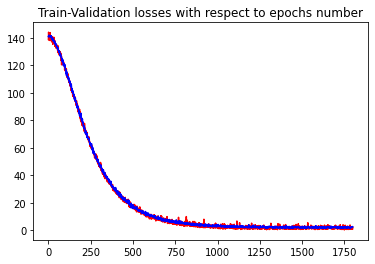

In [31]:
plt.figure()
plt.subplot(1, 1, 1)
plt.title("Train-Validation losses with respect to epochs number")
plt.plot(np.asarray(losses_train), 'r')
plt.plot(np.asarray(losses_val), 'b')
plt.show()

Although the above graph shows that there is no need for NN pruning, we also examined the results after pruning the network, as the deep learning model can suffer from overfitting problems (in case that the validation set is not representative). Kaggle's score was better without model pruning, so the code below is set as notes.

In [ ]:
# prune.random_unstructured(deep_regressor.fc1, name="weight", amount=0.3)
# prune.random_unstructured(deep_regressor.fc2, name="weight", amount=0.3)
# prune.random_unstructured(deep_regressor.fc3, name="weight", amount=0.3)
# prune.random_unstructured(deep_regressor.fc4, name="weight", amount=0.3)

In [32]:
preds = np.expm1(deep_regressor(torch.as_tensor(test_X_transformed).float().to("cuda:0")).detach().cpu().squeeze(1).numpy())

In [33]:
sample_submission = pd.read_csv('./sample_submission.csv')
output = pd.DataFrame({'Id': sample_submission.Id,
'SalePrice': preds})
output.to_csv('submission.csv', index=False)
output.head()

,Id,SalePrice
0,1461,155098.671875
1,1462,215271.968750
2,1463,215045.031250
3,1464,30049.585938
4,1465,150775.578125
